# SFL Small Library: HT-MEK Experimental Aggregation

In [176]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
from Bio import AlignIO
from Bio.Align import AlignInfo
import re
import ast
import sys
import copy
from tqdm import tqdm
import textwrap as tw

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from adjustText import adjust_text

# stats
from scipy.optimize import curve_fit
from scipy import optimize, interpolate
from scipy import stats
import scipy as scp
from scipy.stats import entropy
from sklearn.metrics import r2_score

from itertools import groupby

# parallelization
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# file exports
import os

# import clear output function
from IPython.display import clear_output

# import custom functions
from experiment_aggregation import aggregation

# remove display limit
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Import data

Import substrate turnover data

In [177]:
# Import Experiment for AcP Substrate
df_220405_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/HT-MEK_expts/hACYP2/220405_hACYP2_9mutsWT/processed data/All_processed_data/All_processed_data220405_S2d2_Acyp2_9mutWT_scalingFactor_standardSeries_Correction.csv')
# df_221022_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/221022/Interpretation/221022_AcP_workup.csv')
df_221201_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/221201_SFL_203/20221201_CraigAlbert/Interpretation/AcP/221201_AcP_workup.csv')
df_230207_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230207_SFL_AcyPs/Interpretation/AcP/230207_AcP_workup.csv')
df_230410_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230410_SFL_ACYPS/Interpretation/AcP/230410_AcP_workup.csv')
df_230419_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230419_SFL_AcyPs/Interpretation/AcP/230419_AcP_workup.csv')
df_230612_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/AcP/230612_AcP_workup.csv')
df_230622_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230622_SFL_ACYPs/Interpretation/AcP/230622_AcP_workup.csv')
df_230629_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230629_SFL_ACYPs/Interpretation/AcP/230629_AcP_workup.csv')
df_240418_SFL_AcP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/240418_SFL_AcyPs/d2/Interpretation/AcP/240418_AcP_workup.csv')

# Import Experiment for ATP Substrate
df_230419_SFL_ATP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230419_SFL_ACYPs/Interpretation/ATP/230419_ATP_workup.csv')
df_230612_SFL_ATP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/ATP/230612_ATP_workup.csv')
df_230622_SFL_ATP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230622_SFL_ACYPs/Interpretation/ATP/230622_ATP_workup.csv')

# Import Experiment for PEP Substrate
df_230419_SFL_PEP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230419_SFL_ACYPs/Interpretation/PEP/230419_PEP_workup.csv')
df_230612_SFL_PEP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/PEP/230612_PEP_workup.csv')

Import Experiment for DiFMUP Substrate
df_240322_SFL_DiFMUP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/240322_SFL_AcyPs/Interpretation/DiFMUP/240322_DiFMUP_workup.csv')

Correct formatting of 4/5/22 experiment

In [178]:
# if df variable is not defined, define it
try:
    # change column name for kcat/KM
    df_220405_SFL_AcP['kcat_over_KM_fit'] = df_220405_SFL_AcP['fit_mm_kcatoverKM_MMfit']

    # replace 'Missing["Nonexistent"]' with NaN
    df_220405_SFL_AcP['kcat_over_KM_fit'] = df_220405_SFL_AcP['kcat_over_KM_fit'].replace('Missing["Nonexistent"]', np.nan)

    # convert column to float and log transform
    df_220405_SFL_AcP['log_kcat_over_KM_fit'] = df_220405_SFL_AcP['kcat_over_KM_fit'].astype(float)
    
except:
    pass


In [179]:
# Add dfs to list of dfs
all_turnover_dfs = {
                    # '221022_AcP': df_221022_SFL_AcP.copy(),
                    '221201_AcP': df_221201_SFL_AcP.copy(),
                    '230207_AcP': df_230207_SFL_AcP.copy(),
                    '230410_AcP': df_230410_SFL_AcP.copy(),
                    '230419_AcP': df_230419_SFL_AcP.copy(),
                    '230612_AcP': df_230612_SFL_AcP.copy(),
                    '230622_AcP': df_230622_SFL_AcP.copy(),
                    '230629_AcP': df_230629_SFL_AcP.copy(),
                    '240418_AcP': df_240418_SFL_AcP.copy(),

                    '230419_ATP': df_230419_SFL_ATP.copy(),
                    '230612_ATP': df_230612_SFL_ATP.copy(),
                    '230622_ATP': df_230622_SFL_ATP.copy(),

                    '230419_PEP': df_230419_SFL_PEP.copy(),
                    '230612_PEP': df_230612_SFL_PEP.copy()
                      }

In [180]:
# add df tags
def add_df_tags(df):

    # create name column from MutantID; remove sample plate well number
    if 'MutantID' in df.columns:
        # if well number in name, remove it
        if df['MutantID'].str.contains('\d{1,2}[A-Za-z]{1,2}\d{1,2}', regex=True).any():
            # df['name'] = df.MutantID.str.split('_').str[1:].str.join("_").str.replace('_[A-H]\d{1,2}', '')
            df.loc[df['MutantID'].str.contains("^\d{1,2}[A-Za-z]{1,2}\d{1,2}", regex=True), 'name'] = df.MutantID.str.split('_').str[1:].str.join("_")
        else:
            df['name'] = df.MutantID
        
        df.loc[df['MutantID'].str.contains("BLANK", regex=True), 'name'] = "BLANK"

    if 'n_mutations' in df.columns:
        df['n_mutations'] = pd.to_numeric(df['n_mutations'])

    # replace hyphens in sequence data input
    df['name'] = df['name'].str.replace('-', ' ')
    df['name'] = df['name'].str.replace('.', ' ')

    # add mutation column if single mutant
    pattern = re.compile(r'([A-Z]\d{1,2}[A-Z])')
    df['mutation'] = df.name.str.extract(pattern, expand=True)

    # add species labels
    df.loc[df['MutantID'].str.contains("benthica"), 'species'] = 'sbenthica'
    df.loc[df['MutantID'].str.contains("hsapiens2"), 'species'] = 'hsapiens'
    df.loc[df['MutantID'].str.contains("human"), 'species'] = 'hsapiens'
    df.loc[df['MutantID'].str.contains("phorikoshii"), 'species'] = 'phorikoshii'
    df.loc[df['MutantID'].str.contains("hypf"), 'species'] = 'hypf'
    df.loc[df['MutantID'].str.contains("\w\d{5,10}\w", regex=True), 'species'] = 'uncharacterized' # matchs the naming convention that Clara used to describe the uncharacterized bacterial ACYPs
    df.loc[df['MutantID'].str.contains("cons"), 'species'] = 'consensus'
    df.loc[df['MutantID'].str.contains("acylphosphatase"), 'species'] = df['MutantID'].str.replace('_wt', '').str.split('acylphosphatase').str[-1].str.split('_').str[1].str.replace('-', ' ')

    # add origin labels
    df.loc[df['MutantID'].str.contains("[A-Z]\d{1,2}[A-Z]", regex=True), 'origin'] = 'mutant'
    df.loc[df['MutantID'].str.contains("wt", regex=False), 'origin'] = 'WT'
    df.loc[df['MutantID'].str.contains("pross"), 'origin'] = 'pross'
    df.loc[df['MutantID'].str.contains("lambda"), 'origin'] = 'progen'
    df.loc[df['MutantID'].str.contains("cons"), 'origin'] = 'consensus'
    df.loc[df['MutantID'].str.contains("acylphosphatase"), 'origin'] = 'WT'

    # extract replicate numbers from pross and progen chambers
    df.loc[df['MutantID'].str.contains('pross'), ['sampling_replicate']] = df['MutantID'].str.split('_').str[-1]
    df.loc[df['MutantID'].str.contains('lambda'), ['sampling_replicate']] = df['MutantID'].str.split('_').str[-1]

    # rename mutants
    df["MutantID"] = df["MutantID"].apply(lambda x: re.sub(r"human_ACYP2", "hsapiens2", x))

    # extract progen design features
    df.loc[df['MutantID'].str.contains('highlambda'), ['lambda']] = 'high'
    df.loc[df['MutantID'].str.contains('lowlambda'), ['lambda']] = 'low'
    df.loc[df['MutantID'].str.contains('highid'), ['seq_id']] = 'high'
    df.loc[df['MutantID'].str.contains('lowid'), ['seq_id']] = 'low'
    
    # reformat sequence column
    if 'sequence' in df.columns:
        df['protein_sequence'] = df['sequence']
        df = df.drop('sequence', axis=1)
        
        # add wt protein sequence to each row
        WT_df = df[(df['origin'] == 'WT') | (df['origin'] == 'consensus')]
        WT_df = WT_df.drop_duplicates(subset=['species'])

        # add wt sequence to each row
        df = pd.merge(df, WT_df[['species', 'protein_sequence']], on='species', suffixes=['', '_wt'])

    return df

# add tags to all dfs
for key in all_turnover_dfs:
    all_turnover_dfs[key] = add_df_tags(all_turnover_dfs[key])

### Concatenate all dfs

In [181]:
# change MM_kcat_over_KM_fit to kcat_over_KM_fit in columns
for k,v in all_turnover_dfs.items():
    v.rename(columns={'MM_kcat_over_KM_fit':'kcat_over_KM_fit'}, inplace=True)
    v.rename(columns={'MM_kcat_over_KM_fit_R2':'kcat_over_KM_fit_R2'}, inplace=True)

Import stability data

In [182]:
# Import Experiment
df_230207_SFL_DiFMUP = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230207/Interpretation/DiFMUP/230207_DiFMUP_workup.csv')

# add to list of dfs
all_stability_dfs = {
                    '230207_DiFMUP': df_230207_SFL_DiFMUP,
                    }

# add tags to each df
for key in all_stability_dfs.keys():
    all_stability_dfs[key] = aggregation.add_df_tags(all_stability_dfs[key])

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Data_T7/HT-MEK_data/ACYP/230207/Interpretation/DiFMUP/230207_DiFMUP_workup.csv'

Import substrate water rate data

In [183]:
# import water rates data
df_water_rates = pd.read_csv('/Volumes/Data_T7/HT-MEK_data/ACYP/230407_substrate_water_rates/Interpretation/230407_ACYP_substrate_water_rates_median.csv')

# format columns
df_water_rates['Substrate'] = df_water_rates['Condition'].str.split(' ').str[0]
df_water_rates['EDTA_Conc'] = df_water_rates['Condition'].str.split(' ').str[2].str[0]
df_water_rates = df_water_rates[df_water_rates['EDTA_Conc'] == '1']
df_water_rates = df_water_rates[['Substrate', 'Median Rate (uM/s)']]

Import literature rates

In [184]:
# import literature data
lit_df = pd.read_csv('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Data/Literature_reference/lit_collated_values.csv')

Import sequence information

In [11]:
# import protein sequences
full_protein_sequence_library = pd.read_csv('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Library-summaries/all-sequences-library.csv')

# import DNA sequences
full_DNA_sequence_library = pd.read_excel('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Data/full-optimized-oligo-library.xlsx')
full_DNA_sequence_library = full_DNA_sequence_library[['name', 'dna_sequence', 'oligo_len', 'average_ecoli_usage']]

# import single mutant log likelihoods
single_mutant_likelihoods = pd.read_csv('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Data/micah-single-mutant-seqs-022723.csv')
single_mutant_likelihoods['name'] = single_mutant_likelihoods['mutation'].apply(lambda x: 'hsapiens2_' + x)

# format sequence dataframes
full_protein_sequence_library = aggregation.add_df_tags(full_protein_sequence_library)
full_DNA_sequence_library = aggregation.add_df_tags(full_DNA_sequence_library)
single_mutant_likelihoods = aggregation.add_df_tags(single_mutant_likelihoods)

# convert all columns to object
full_protein_sequence_library = full_protein_sequence_library.astype(str)
full_DNA_sequence_library = full_DNA_sequence_library.astype(str)
single_mutant_likelihoods = single_mutant_likelihoods.astype(str)

# merge all sequence dataframes
full_sequence_library = full_protein_sequence_library.merge(full_DNA_sequence_library, how='left', on=np.intersect1d(full_protein_sequence_library.columns, full_DNA_sequence_library.columns).tolist())
full_sequence_library = full_sequence_library.merge(single_mutant_likelihoods, how='left', on=np.intersect1d(full_sequence_library.columns, single_mutant_likelihoods.columns).tolist())

# convert back to float if possible
full_sequence_library = full_sequence_library.apply(pd.to_numeric, errors='ignore')

### Merge sequence information with datasets

In [12]:
# add experiment tags to all dfs
for k,v in all_turnover_dfs.items():
    v['experiment'] = k

# concatenate all dfs
all_turnover_dfs_concat = pd.concat(all_turnover_dfs.values(), ignore_index=True)

In [13]:
columns_to_keep = ['name',	'n_mutations',	'ensemble_ll',	'predicted_tm',	'protein_sequence',	'protein_sequence_wt']

# remove well number from name and MutantID
pattern = r'(^\d{1,}\w{0,1}\d{1,}_)'
all_turnover_dfs_concat['MutantID'] = all_turnover_dfs_concat['MutantID'].str.replace(pattern, '')
all_turnover_dfs_concat['name'] = all_turnover_dfs_concat['name'].str.replace(pattern, '')

# remove well number from name in full sequence library
full_sequence_library['name'] = full_sequence_library['name'].str.replace(pattern, '')

# merge with full sequence library
all_turnover_dfs_concat = pd.merge(all_turnover_dfs_concat, full_sequence_library[columns_to_keep], how='left', on='name')

In [14]:
# remove well number from name and MutantID
pattern = r'(^\d{1,}\w{0,1}\d{1,}_)'
all_turnover_dfs_concat['MutantID'] = all_turnover_dfs_concat['MutantID'].str.replace(pattern, '')
all_turnover_dfs_concat['name'] = all_turnover_dfs_concat['name'].str.replace(pattern, '')

# set origin to 'mutant' if pattern matches
pattern = r'(^\d{1,}\w{0,1}\d{1,})'
for i in all_turnover_dfs_concat.index:
    if re.search(pattern, all_turnover_dfs_concat.loc[i, 'MutantID']):
        all_turnover_dfs_concat.loc[i, 'origin'] = 'mutant'

# if MutantID contains 'acylphosphatase' split MutantID and set species to last word
pattern = r'(acylphosphatase)'
for i in all_turnover_dfs_concat.index:
    if re.search(pattern, all_turnover_dfs_concat.loc[i, 'MutantID']):
        all_turnover_dfs_concat.loc[i, 'species'] = all_turnover_dfs_concat.loc[i, 'MutantID'].split('_')[-2].replace(' ', '_')


In [15]:
all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'] == '240418_AcP']
# all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'] == '230207_AcP']

,Unnamed: 0,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,kcat_over_KM_fit_R2,exclude_concs,local_bg_ratio,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM,initial_rate,initial_rate_intercept,two_point_fit,rate_fit_regime,GlobalExperimentIndex,Experiment,name,mutation,species,origin,sampling_replicate,lambda,seq_id,experiment,exponential_A_list,exponential_kobs_list,exponential_y0_list,exponential_R2_list,exponential_kcat_over_km_list,MM_points_to_fit,local_bg_substrate_conc,kobs_kcat_over_KM,num_points_fit_vo_list,num_points_fit_vo,exponential_A,exponential_kobs,exponential_y0,exponential_R2,kobs_kcat_KM,local_bg_substrate_conc_x,local_bg_substrate_conc_y,local_bg_substrate_conc_x.1,local_bg_substrate_conc_y.1,local_bg_substrate_conc_x.2,local_bg_substrate_conc_y.2,local_bg_substrate_conc_x.3,local_bg_substrate_conc_y.3,max_exp_R2,n_mutations,ensemble_ll,predicted_tm,protein_sequence,protein_sequence_wt
39672,0,1,1,"01,01",hypf_highlambda_highid_2,AcP,0.241920,False,"[0, 10, 50, 75, 100, 200, 300]","[0.0006533333333333332, 0.0002613333333333282,...",5.999239e+02,0.000249,1.031291,1.719036e+03,0.686559,"[10, 50, 75]",5.166235,200.0,48384,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[516, 518, 521, 522, 522, 524, 524, 522, 521, ...","[0, 6, 15, 30, 75, 150]","[1344, 2215, 4845, 4726, 4967, 5305]",[2.38043861e+02 9.65954114e-14 1.55915538e+01 ...,"[-2.5859999999999985, -2.5859999999999985, -2....",0.000029,-2.598732,False,2.0,240418_S7_d2_AcP,AcyP_SFL_203,hypf_highlambda_highid_2,NaN,hypf,progen,2,high,high,240418_AcP,"[0.4140114383765991, 0.20810885570347007, 0.29...","[0.0013260738504922345, 0.0040966598934539, 0....","[7.819521722775615, 11.623332307577341, -1.326...","[0.8238490881345824, 0.5001689418638728, 0.792...","[5481456.061889197, 16933944.665401373, 612838...",4.0,NaN,6.128387e+05,"[4.0, 4.0, 4.0, 15.0, 15.0, 15.0, 15.0]",15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,-1.773808289,79.87565002,MVRGRVSMIKARRINIKGIVQGVGFRPFVFNIAQKYNLKGFVYNNS...,MVRGRVPQIQARQINIFGIVQGVGFRPFVFNIAQKYNLKGIVYNNS...
39673,1,1,2,"01,02",BLANK,AcP,0.350250,False,"[0, 10, 50, 75, 100, 200, 300]","[0.0011759999999999896, 0.0007840000000000606,...",5.999164e+02,0.000275,0.784547,1.307760e+03,0.652478,"[10, 50, 75, 200]",0.562500,0.0,70050,"[0, 75, 150, 225, 300, 376, 451, 526, 601, 676...","[3234, 3250, 3254, 3277, 3286, 3274, 3270, 327...","[0, 6, 15, 30, 75, 150]","[1558, 1721, 3889, 4004, 4152, 4335]",[1.62149125e+02 1.01452413e-17 1.74142816e+01 ...,"[12.212000000000003, 12.310000000000002, 12.31...",0.001176,12.202200,False,1.0,240418_S7_d2_AcP,AcyP_SFL_203,BLANK,NaN,NaN,NaN,NaN,NaN,NaN,240418_AcP,"[0.8397894072812562, 0.3298608400194075, nan, ...","[0.00038880798554815943, 0.003732618331363151,...","[12.310099335726733, 15.352365009088976, nan, ...","[0.9138229162172627, 0.8353703539371099, nan, ...","[1110087.039395173, 10657011.652714206, nan, 2...",3.0,NaN,NaN,"[4.0, 4.0, 4.0, 15.0, 15.0, 15.0, 15.0]",4.0,8.397894e-01,3.888080e-04,12.310099,0.913823,1.110087e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39674,2,1,3,"01,03",sbenthica_pross_2,AcP,0.240630,False,"[0, 10, 50, 75, 100, 200, 300]","[0.0020906666666666764, 0.0037893333333333225,...",3.155222e-09,0.001326,5.509152,1.746043e+15,0.045991,"[200, 50, 75]",0.666667,50.0,48126,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[943, 949, 950, 954, 956, 954, 951, 952, 955, ...","[0, 6, 15, 30, 75, 150]","[1694, 1691, 2880, 3098, 3313, 3470]",[8.32543875e+01 9.79813278e-15 2.04187121e+01 ...,"[-6.799999999999997, -6.701999999999998, -6.70...",0.000784,-6.790200,False,1.0,240418_S7_d2_AcP,AcyP_SFL_203,sbenthica_pross_2,NaN,sbenthica,pross,2,NaN,NaN,240418_AcP,"[1.0910064844732736, 0.9777155361196646, 0.181...","[0.0013578844200

## Define export path

In [16]:
figure_export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/Shared drives/FordyceLab/manuscripts/Micah/Designed_AcyPs_manuscript/Plots'

## Create reference dictionary for names of all sequences

In [17]:
# add design replicate column to each full_protein_sequence_libraryaframe
full_protein_sequence_library['design_rep'] = full_protein_sequence_library['name']
for index, row in full_protein_sequence_library.iterrows():
    if row['origin'] == 'progen':
        full_protein_sequence_library.loc[index, 'design_rep'] = str(row['seq_id'][0]).upper() + str(row['lambda'][0]).upper() + row['name'].split('_')[-1]
    elif row['origin'] == 'WT':
        full_protein_sequence_library.loc[index, 'design_rep'] = 'WT'
    elif row['origin'] == 'pross':
        full_protein_sequence_library.loc[index, 'design_rep'] = str(row['name'].split('_')[-1])
    elif row['origin'] == 'mutant':
        full_protein_sequence_library.loc[index, 'design_rep'] = row['mutation']
    else:
        pass

# add design replicate column to each of all_turnover_dfs
for key in all_turnover_dfs.keys():
    all_turnover_dfs[key]['design_rep'] = all_turnover_dfs[key]['name']
    for index, row in all_turnover_dfs[key].iterrows():
        if row['origin'] == 'progen':
            all_turnover_dfs[key].loc[index, 'design_rep'] = str(row['seq_id'][0]).upper() + str(row['lambda'][0]).upper() + '\n' + row['name'].split('_')[-1]
        elif row['origin'] == 'WT':
            all_turnover_dfs[key].loc[index, 'design_rep'] = 'WT'
        elif row['origin'] == 'pross':
            all_turnover_dfs[key].loc[index, 'design_rep'] = str(row['name'].split('_')[-1])
        elif row['origin'] == 'mutant':
            all_turnover_dfs[key].loc[index, 'design_rep'] = row['mutation']
        else:
            pass

Create reference dictionary for designed sequences

In [18]:
# create reference dictionary for each species
names_reference_dictionary = {}

dat = full_protein_sequence_library

# create a dictionary of all the names for each species
for species in dat['species'].unique():
    names_reference_dictionary[species] = {}
    for origin in dat['origin'].unique():
        if origin == 'WT':
            names_reference_dictionary[species][origin] = ['WT']
        else:
            ids = dat[(dat['species'] == species) & (dat['origin'] == origin)]['design_rep'].unique().tolist()
            if len(ids) > 0:
                names_reference_dictionary[species][origin] = ids

log transform all MM kcat/KM values

In [19]:
# log transform kcat/KM
all_turnover_dfs_concat['kcat_over_KM_fit'] = np.log10(all_turnover_dfs_concat['kcat_over_KM_fit'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
all_turnover_dfs_concat.columns

Index(['Unnamed: 0', 'x', 'y', 'Indices', 'MutantID', 'substrate',
       'EnzymeConc', 'egfp_manual_flag', 'substrate_concs', 'initial_rates',
       'KM_fit', 'vmax_fit', 'kcat_fit', 'kcat_over_KM_fit',
       'kcat_over_KM_fit_R2', 'exclude_concs', 'local_bg_ratio',
       'substrate_conc_uM', 'summed_button_BGsub_Button_Quant', 'time_s',
       'kinetic_median_intensities', 'standard_concentration_uM',
       'standard_median_intensities', 'standard_popt',
       'kinetic_product_concentration_uM', 'initial_rate',
       'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
       'GlobalExperimentIndex', 'Experiment', 'name', 'mutation', 'species',
       'origin', 'sampling_replicate', 'lambda', 'seq_id', 'experiment',
       'exponential_A_list', 'exponential_kobs_list', 'exponential_y0_list',
       'exponential_R2_list', 'exponential_kcat_over_km_list',
       'MM_points_to_fit', 'local_bg_substrate_conc', 'kobs_kcat_over_KM',
       'num_points_fit_vo_list', 'num_poin

<AxesSubplot:xlabel='experiment', ylabel='kcat_over_KM_fit'>

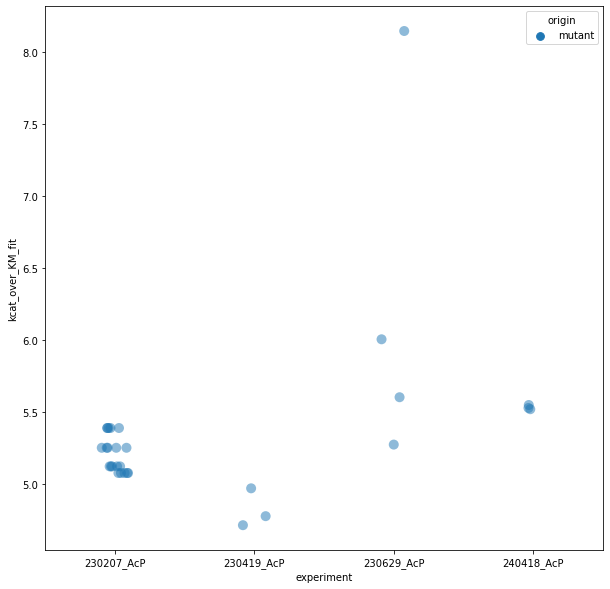

In [21]:
# filter for only WT and mutant data
dat = all_turnover_dfs_concat.copy()
dat = dat[dat['species'] == 'hsapiens']
dat = dat[dat['mutation'] == 'C21S']
dat = dat[dat['substrate'] == 'AcP']
remove_expts = ['221201_AcP', '230410_AcP', '230612_AcP', '230622_AcP']
dat = dat[~dat['experiment'].isin(remove_expts)]
# dat.drop_duplicates(subset=['Indices'], inplace=True)

# filter low local bg ratio
dat = dat[dat['local_bg_ratio'] > 2]

plt.figure(figsize=(10, 10))
sns.stripplot(data=dat, x='experiment', y='kcat_over_KM_fit', hue='origin', dodge=True, jitter=True, alpha=0.5, size=10)


### Plot several replicate MM curves from a single experiment

In [22]:
dat[dat['origin'] == 'mutant']

,Unnamed: 0,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,kcat_over_KM_fit_R2,exclude_concs,local_bg_ratio,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM,initial_rate,initial_rate_intercept,two_point_fit,rate_fit_regime,GlobalExperimentIndex,Experiment,name,mutation,species,origin,sampling_replicate,lambda,seq_id,experiment,exponential_A_list,exponential_kobs_list,exponential_y0_list,exponential_R2_list,exponential_kcat_over_km_list,MM_points_to_fit,local_bg_substrate_conc,kobs_kcat_over_KM,num_points_fit_vo_list,num_points_fit_vo,exponential_A,exponential_kobs,exponential_y0,exponential_R2,kobs_kcat_KM,local_bg_substrate_conc_x,local_bg_substrate_conc_y,local_bg_substrate_conc_x.1,local_bg_substrate_conc_y.1,local_bg_substrate_conc_x.2,local_bg_substrate_conc_y.2,local_bg_substrate_conc_x.3,local_bg_substrate_conc_y.3,max_exp_R2,n_mutations,ensemble_ll,predicted_tm,protein_sequence,protein_sequence_wt
9078,1910,7,47,"07,47",3B6_hsapiens2_C21S,AcP,32.238013,False,"[10, 25, 50, 75, 100]","[0.020515555555555544, 0.07372777777777782, 0....",11.401250,0.043906,1.361942,5.077206,NaN,"[25, 50, 75, 100]",2.071940e+00,10.0,17730907,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[9986, 11359, 12240, 12783, 13069, 13262, 1333...","[0, 1, 6, 15, 30, 75]","[5480, 6188, 10055, 16229, 20219, 20238]",[8.09170786e+02 7.71420193e-01 1.94513641e+01 ...,"[5.904250000000001, 7.779500000000002, 8.98158...",0.020516,6.016444,False,1.0,230207_S7_d2_AcP,AcyP_SFL_203,human_ACYP2_C21S,C21S,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[4.918913313607126, 13.374890155593032, 0.2770...","[0.006504410582665624, 0.007542578027219455, 0...","[5.904847250676965, 15.052719968461934, 21.869...","[0.9969264482394131, 0.9926367365735767, 0.298...","[201762.1445121839, 233965.35298339228, 155096...",1.0,25.0,201762.144512,"[3, 2, 2, 2, 0]",3.0,4.918913,0.006504,5.904847,0.996926,2.017621e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9079,1911,7,47,"07,47",3B6_hsapiens2_C21S,AcP,32.238013,False,"[10, 25, 50, 75, 100]","[0.020515555555555544, 0.07372777777777782, 0....",11.401250,0.043906,1.361942,5.077206,NaN,"[25, 50, 75, 100]",2.071940e+00,25.0,17730907,"[0, 75, 150, 227, 304, 381, 458, 536, 613, 690...","[16292, 18743, 19584, 19877, 19973, 20019, 200...","[0, 1, 6, 15, 30, 75]","[5480, 6188, 10055, 16229, 20219, 20238]",[8.09170786e+02 7.71420193e-01 1.94513641e+01 ...,"[15.08816666666667, 20.617750000000004, 24.272...",0.073728,15.088167,True,1.0,230207_S7_d2_AcP,AcyP_SFL_203,human_ACYP2_C21S,C21S,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[4.918913313607126, 13.374890155593032, 0.2770...","[0.006504410582665624, 0.007542578027219455, 0...","[5.904847250676965, 15.052719968461934, 21.869...","[0.9969264482394131, 0.9926367365735767, 0.298...","[201762.1445121839, 233965.35298339228, 155096...",1.0,25.0,201762.144512,"[3, 2, 2, 2, 0]",2.0,13.374890,0.007543,15.052720,0.992637,2.339654e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9080,1912,7,47,"07,47",3B6_hsapiens2_C21S,AcP,32.238013,False,"[10, 25, 50, 75, 100]","[0.020515555555555544, 0.07372777777777782, 0....",11.401250,0.043906,1.361942,5.077206,NaN,"[25, 50, 75, 100]",2.071940e+00,50.0,17730907,"[0, 75, 150, 226, 301, 378, 456, 534, 611, 688...","[19095, 19167, 19148, 19202, 19147, 19165, 191...","[0, 1, 6, 15, 30, 75]","[5480, 6188, 10055, 16229, 20219, 20238]",[8.09170786e+02 7.71420193e-01 1.94513641e+01 ...,"[21.86791666666667, 22.204500000000007, 22.108...",0.004488,21.867917,True,2.0,230207_S7_d2_AcP,AcyP_SFL_203,human_ACYP2_C21S,C21S,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[4.918913313607126, 13.374890155593032, 0.2770...","[0.006504410582665624, 0.007542578027219455, 0...","[5.904847250676965, 15.052719968461934, 21.869...","[0.9969264482394131, 0.9926

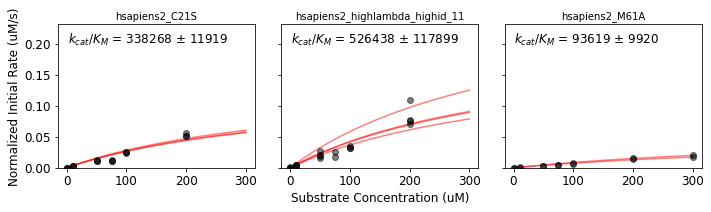

In [23]:
# for every mutantid in dat, plot MM plot

experiment = '240418_AcP'
dat = all_turnover_dfs[experiment].copy()

variant_selections = [
    'hsapiens2_C21S', # WT-like variant
    'hsapiens2_highlambda_highid_11', # progen selection
    'hsapiens2_M61A', # perturbed variant
]

# filter dat for high quality measurements
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 1]


# create figure
fig, axs = plt.subplots(1, len(variant_selections), figsize=(10, 3), sharey=True)

# add horizontal space between subplots
# fig.subplots_adjust(wspace=0.5)

# initialize max vi
max_vi = 0

for i, v in enumerate(variant_selections):
    # get data where MutantID contains v
    dat_mut = dat[dat['MutantID'].str.contains(v)]

     # define MM function
    def MM(vmax, KM, S):
        return (vmax * S) / (KM + S)

    # for each replicate, plot the kcat/KM fit
    for index, row in dat_mut.iterrows():

        # get data
        vi_list = ast.literal_eval(row['initial_rates'])
        s_list = ast.literal_eval(row['substrate_concs'])
        max_S = max(s_list)

        # get max vi
        if max(vi_list) > max_vi:
            max_vi = max(vi_list)
        
        ### Plot Curve Fit ###
        E0 = row['EnzymeConc']
        KM = row['KM_fit']
        kcat = row['kcat_fit']
        vmax = row['vmax_fit']/E0
        x = np.linspace(0, max_S, 1000)
        y = MM(vmax, KM, x)
        axs[i].plot(x, y, color='red', alpha=0.5, zorder=1)

        ### Plot Points ###
        exclude_concs = ast.literal_eval(row['exclude_concs'])
        exclude_indices = [i for i, x in enumerate(s_list) if x in exclude_concs]
        vi_list = np.array([i for j, i in enumerate(vi_list) if j not in exclude_indices])
        s_list = np.array([i for j, i in enumerate(s_list) if j not in exclude_indices])

        # normalize vi_list by E0
        vi_list = vi_list / E0

        # plot points
        axs[i].scatter(s_list, vi_list, color='black', alpha=0.5, zorder=2)

    # get median and std kcat/KM, KM, kcat
    median_kcat_over_KM = dat_mut['kcat_over_KM_fit'].median()
    std_kcat_over_KM = dat_mut['kcat_over_KM_fit'].std()
    median_KM = dat_mut['KM_fit'].median()
    std_KM = dat_mut['KM_fit'].std()
    median_kcat = dat_mut['kcat_fit'].median()
    std_kcat = dat_mut['kcat_fit'].std()

    # add kcat/KM as text labels in upper left corner
    text = f'$k_{{cat}}/K_M$ = {median_kcat_over_KM:.0f} $\pm$ {std_kcat_over_KM:.0f}'
    axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes, verticalalignment='top', size=12)
    # text = f'$K_M$ = {median_KM:.0f} $\pm$ {std_KM:.0f} (lower limit)'
    # axs[i].text(0.05, 0.84, text, transform=axs[i].transAxes, verticalalignment='top', size=11)
    # text = f'$k_{{cat}}$ = {median_kcat:.0f} $\pm$ {std_kcat:.0f}'
    # axs[i].text(0.05, 0.75, text, transform=axs[i].transAxes, verticalalignment='top', size=11)

    # add title
    axs[i].set_title(v, fontsize=10)

# set y limit a bit higher than max vi so label doesn't overlap with data
axs[0].set_ylim(0, 1.05*max_vi)

# add labels to correct subplots
axs[0].set_ylabel('Normalized Initial Rate (uM/s)', fontsize=12)
axs[1].set_xlabel('Substrate Concentration (uM)', fontsize=12)

# increase font size
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

# tight layout
plt.tight_layout()

# set facecolor to white
fig.patch.set_facecolor('white')

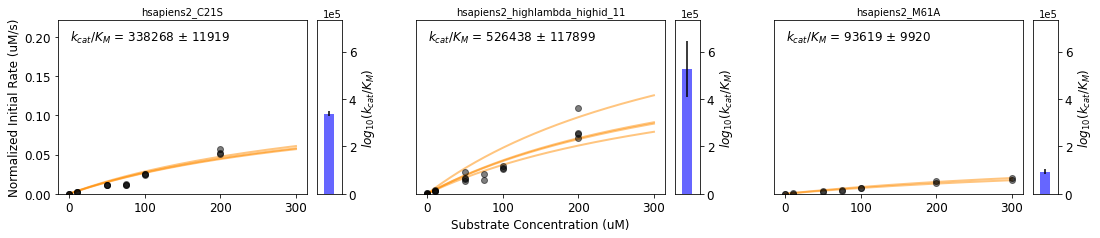

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# Assuming `all_turnover_dfs` is already defined and contains your data
experiment = '240418_AcP'
dat = all_turnover_dfs[experiment].copy()

variant_selections = [
    'hsapiens2_C21S',  # WT-like variant
    'hsapiens2_highlambda_highid_11',  # progen selection
    'hsapiens2_M61A',  # perturbed variant
]

# Filter dat for high quality measurements
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 1]

# Create figure with additional space for bar charts
n_variants = len(variant_selections)
fig, axs = plt.subplots(1, 2*n_variants, figsize=(15, 3), 
                        gridspec_kw={'width_ratios': [5 if i % 2 == 0 else 0.5 for i in range(2*n_variants)]})

# Function to plot Michaelis-Menten curve
def MM(vmax, KM, S):
    return (vmax * S) / (KM + S)

# Get max kcat/KM to set y limit on bar charts
max_kcat_over_KM = 0
for i, v in enumerate(variant_selections):
    # Get data where MutantID contains v
    dat_mut = dat[dat['MutantID'].str.contains(v)]
    current_max = max(max_kcat_over_KM, dat_mut['kcat_over_KM_fit'].max())
    if current_max > max_kcat_over_KM:
        max_kcat_over_KM = current_max

# Get max vi to set y limit on MM plots
max_vi = 0
for i, v in enumerate(variant_selections):
    # Get data where MutantID contains v
    dat_mut = dat[dat['MutantID'].str.contains(v)]
    for index, row in dat_mut.iterrows():
        # Get data
        vi_list = ast.literal_eval(row['initial_rates'])
        max_vi = max(max_vi, max(vi_list))
        if max(vi_list) > max_vi:
            max_vi = max(vi_list)

# import pylab
import pylab

# Tight layout (have to do this before plotting to avoid messing with the repositioning of subplots)
plt.tight_layout()

# Plot scatter plots and bar charts
for i, v in enumerate(variant_selections):
    # Get data where MutantID contains v
    dat_mut = dat[dat['MutantID'].str.contains(v)]

    # Michaelis-Menten plot
    ax_mm = axs[2*i]
    for index, row in dat_mut.iterrows():
        # Get data
        vi_list = ast.literal_eval(row['initial_rates'])
        s_list = ast.literal_eval(row['substrate_concs'])
        max_S = max(s_list)

        # Get max vi
        if max(vi_list) > max_vi:
            max_vi = max(vi_list)

        # Plot curve fit
        E0 = row['EnzymeConc']
        KM = row['KM_fit']
        kcat = row['kcat_fit']
        vmax = row['vmax_fit']/E0
        x = np.linspace(0, max_S, 1000)
        y = MM(vmax, KM, x)
        # color in dark orange
        ax_mm.plot(x, y, color='darkorange', alpha=0.5, zorder=1, linewidth=2)

        # Plot points
        exclude_concs = ast.literal_eval(row['exclude_concs'])
        exclude_indices = [i for i, x in enumerate(s_list) if x in exclude_concs]
        vi_list = np.array([i for j, i in enumerate(vi_list) if j not in exclude_indices])
        s_list = np.array([i for j, i in enumerate(s_list) if j not in exclude_indices])
        vi_list = vi_list / E0
        ax_mm.scatter(s_list, vi_list, color='black', alpha=0.5, zorder=2)

        # Adjust ylim
        ax_mm.set_ylim(0, max_vi)

        # Remove y ticks if not first subplot
        if i > 0:
            ax_mm.set_yticks([])

    # Get median and std kcat/KM
    median_kcat_over_KM = dat_mut['kcat_over_KM_fit'].median()
    std_kcat_over_KM = dat_mut['kcat_over_KM_fit'].std()

    # Add kcat/KM as text labels in upper left corner
    text = f'$k_{{cat}}/K_M$ = {median_kcat_over_KM:.0f} $\pm$ {std_kcat_over_KM:.0f}'
    ax_mm.text(0.05, 0.95, text, transform=ax_mm.transAxes, verticalalignment='top', size=12)

    # Add title
    ax_mm.set_title(v, fontsize=10)

    # Bar chart for kcat/KM
    ax_bar = axs[2*i + 1]
    ax_bar.bar([0], [median_kcat_over_KM], yerr=[std_kcat_over_KM], color='blue', alpha=0.6, width=0.2)
    ax_bar.set_xlim(-0.25, 0.25)
    ax_bar.set_xticks([])
    ax_bar.set_ylim(0, max_kcat_over_KM)
    ax_bar.yaxis.tick_right()
    ax_bar.yaxis.set_label_position("right")
    ax_bar.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax_bar.set_ylabel('$log_{10}(k_{cat}/K_M)$', fontsize=12)

    # Adjust position of the bar chart to reduce spacing with the scatter plot
    bbox = ax_bar.get_position()
    offset = -0.03
    ax_bar.set_position([bbox.x0 + offset, bbox.y0, bbox.width, bbox.height])

# Add labels to correct subplots
axs[0].set_ylabel('Normalized Initial Rate (uM/s)', fontsize=12)
axs[-4].set_xlabel('Substrate Concentration (uM)', fontsize=12)

# Increase font size
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

# Set facecolor to white
fig.patch.set_facecolor('white')

plt.show()

### Compare measured kcat/KM values to literature Cm values

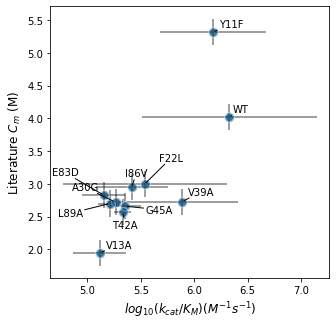

In [25]:
Chiti_measurements = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Chiti_1999_hACYP2_stability_measurements.xlsx')

Chiti_measurements['Cm_mean'] = Chiti_measurements['Cm (M)'].str.split('±')
Chiti_measurements[['Cm_mean', 'Cm_error']] = pd.DataFrame(Chiti_measurements['Cm_mean'].tolist(), index=Chiti_measurements.index)

Chiti_measurements['Cm_mean'] = pd.to_numeric(Chiti_measurements['Cm_mean'], errors='coerce')
Chiti_measurements['Cm_error'] = pd.to_numeric(Chiti_measurements['Cm_error'], errors='coerce')
Chiti_measurements['mutation'] = Chiti_measurements['Mutant']
Chiti_measurements = Chiti_measurements.replace(to_replace=r'wild type', value='WT', regex=True)

# add additional columns
Chiti_measurements['comparison'] = 'literature'
Chiti_measurements['Cm (M)'] = Chiti_measurements['Cm_mean']
Chiti_measurements = Chiti_measurements[['mutation', 'Cm (M)', 'comparison', 'Cm_error', 'm value']]
Chiti_measurements

## Get activity data ##
experiment = '230629_AcP'
dat = all_turnover_dfs[experiment].copy()

# filter for only WT and mutant data
origins = ['WT', 'mutant']
dat = dat[dat['origin'].isin(origins)]

# set mutation column to be WT for WT data
dat.loc[dat['origin'] == 'WT', 'mutation'] = 'WT'

# filter for only high quality measurements
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 1]

# merge with Chiti measurements
dat = pd.merge(dat, Chiti_measurements, how='left', on='mutation')

# log transform kcat/KM
dat['kcat_over_KM_fit'] = np.log10(dat['kcat_over_KM_fit'])

# get median and std for each mutation
dat_grouped = dat.groupby(['mutation', 'comparison']).agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()
dat_grouped.columns = ['mutation', 'comparison', 'median_kcat_over_KM', 'std_kcat_over_KM']

# add Cm data to each mutation
dat_grouped = pd.merge(dat_grouped, Chiti_measurements, how='left', on='mutation')

# drop NAs
dat_grouped = dat_grouped.dropna()

# plot scatter with error bars in seaborn
plt.figure(figsize=(5, 5))
sns.scatterplot(data=dat_grouped, x='median_kcat_over_KM', y='Cm (M)', s=100, alpha=0.5, zorder=2)

# add error bars
for i, row in dat_grouped.iterrows():
    plt.errorbar(row['median_kcat_over_KM'], row['Cm (M)'], 
                 xerr=row['std_kcat_over_KM'], yerr=row['Cm_error'], fmt='o', color='black', alpha=0.5, zorder=1)

# add is_WT columns
dat_grouped['is_WT'] = dat_grouped['mutation'] == 'WT'

# label each point with AdjustText
texts = []
for i, row in dat_grouped.iterrows():
    texts.append(plt.text(row['median_kcat_over_KM'], row['Cm (M)'], row['mutation'], fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), 
            expand_points=(1.5, 1.5), expand_text=(1.5, 1.5), 
            force_text=(0.5, 0.5))

# add labels
plt.xlabel('$log_{10}(k_{cat}/K_M) (M^{-1}s^{-1})$', fontsize=12)
plt.ylabel('Literature $C_m$ (M)', fontsize=12)

# set facecolor to white
plt.gcf().set_facecolor('white')

In [26]:
# export all dfs concat for craig
all_turnover_df_export = all_turnover_dfs_concat.copy()
all_turnover_df_export.to_csv('/Users/micaholivas/Desktop/all_turnover_df_export_forCraig_24_6_2.csv')

### Plot n_mutations vs kcat/KM

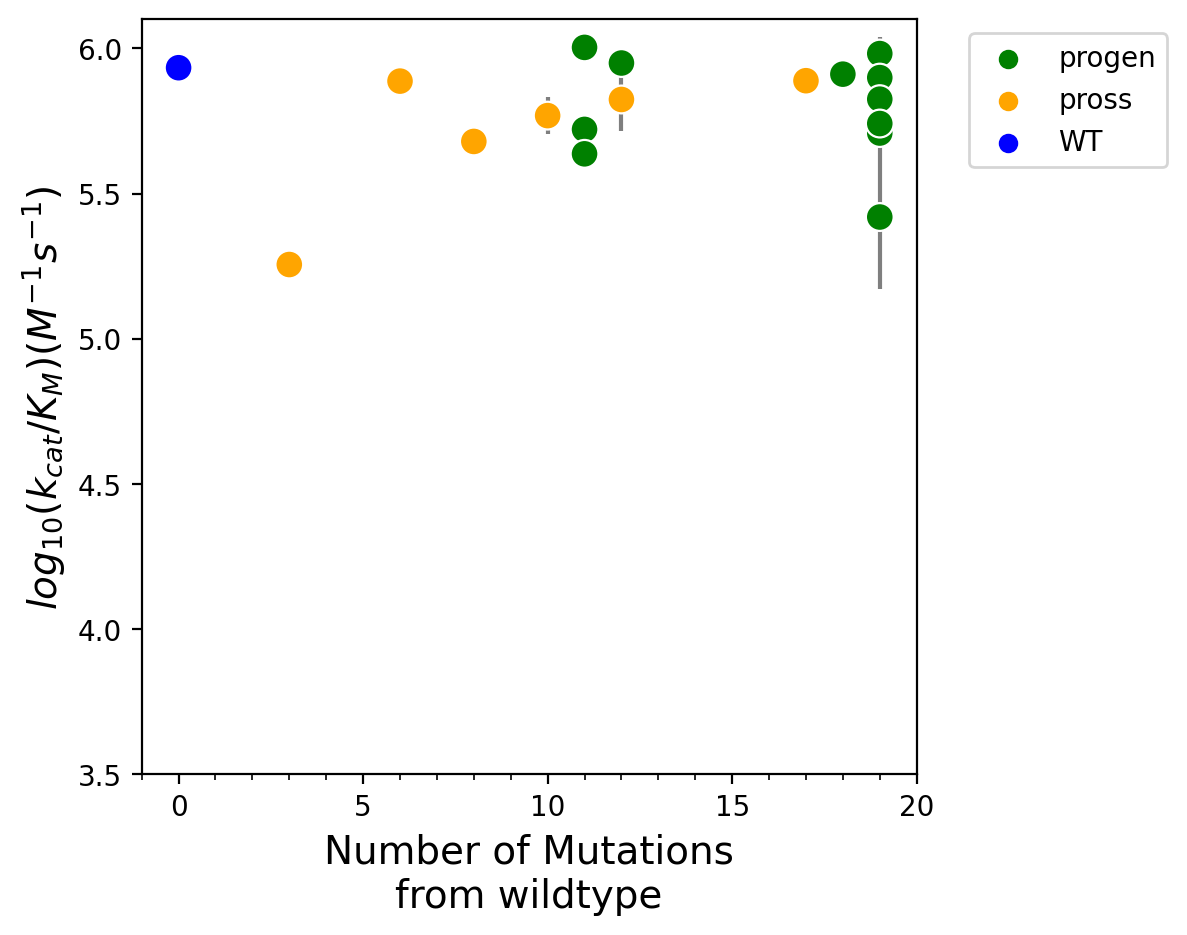

In [27]:
# filter for substrate
substrate = 'AcP'

# select experiments from all_turnover_dfs_concat
expt_selections = [
                    '230207_AcP',
                    '230410_AcP',
                    '230419_AcP',
                    '230612_AcP',
                    '230622_AcP',
                    '230629_AcP',
                    '240418_AcP',


                    # '230419_ATP',
                    # '230612_ATP',
                    # '230622_ATP',

                    # '230419_PEP',
                    # '230612_PEP'
                    ]

df = all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'].isin(expt_selections)]

# select only progen sequences
origins_to_keep = [
    'progen',
    'pross',
    'mutant',
    'WT'
]

origin_color_dict = {
    'progen': 'green',
    'pross': 'orange',
    'mutant': 'red',
    'WT': 'blue'
}

df = df[df['origin'].isin(origins_to_keep)]

# keep only hsapiens
df = df[df['species'] == 'hsapiens']

# convert n_mutations column to float
df['n_mutations'] = df['n_mutations'].astype(float)

# change mutant origin to na in df
df.loc[df['origin'] == 'mutant', 'origin'] = np.nan

# now for any row where n_mutations is 1, set origin to 'mutant'
df.loc[df['n_mutations'] == 1, 'origin'] = 'mutant'

# # filter bad measurements out
df = df[df['local_bg_ratio'] > 3]
df = df[df['EnzymeConc'] > 0.15]

# remove points with a low goodness of fit
df = df[df['kcat_over_KM_fit_R2'] > 0.95]

# get median and sem of kcat/KM
df_grouped = df.groupby(['name', 'n_mutations', 'origin',]).agg({'kcat_over_KM_fit': ['median', 'sem']}).reset_index()
df_grouped.columns = ['name', 'n_mutations', 'origin', 'median_kcat_over_KM', 'sem_kcat_over_KM']

# plot scatter of kcat/KM vs n_mutations
plt.figure(figsize=(5, 5), dpi=200)
datx = df_grouped['n_mutations'].to_numpy()
daty = df_grouped['median_kcat_over_KM'].to_numpy()
erry = df_grouped['sem_kcat_over_KM'].to_numpy()
plt.errorbar(datx, daty, yerr=erry, fmt='o', color='black', alpha=0.5, zorder=1)
sns.scatterplot(data=df_grouped, x='n_mutations', y='median_kcat_over_KM', hue='origin', s=100, alpha=1, zorder=2, palette=origin_color_dict)

# move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# add labels
plt.xlabel('Number of Mutations\nfrom wildtype', fontsize=14)
plt.ylabel('$log_{10}(k_{cat}/K_M) (M^{-1}s^{-1})$', fontsize=14)

# # label the human WT point with adjust text
# texts = []
# for i, row in df_grouped.iterrows():
#     if row['origin'] == 'WT':
#         texts.append(plt.text(row['n_mutations'], row['median_kcat_over_KM'], 'Human WT', fontsize=10))

# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'),
#             expand_points=(1.5, 1.5), expand_text=(1.5, 1.5),
#             force_text=(0.5, 0.5))

# manually adjust limits and ticks
plt.ylim(3.5, 6.1)
plt.xlim(-1, 20)

# set minor x ticks every one position, major ticks every 5
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))

### kcat/KM vs ProGen2 ELL

In [28]:
dat = df[df['origin'] == 'mutant']
dat = dat.merge(single_mutant_likelihoods[['name', 'mutation']], on='name')
plt.scatter(dat['kcat_over_KM_fit_median'], dat['ensemble_ll'], alpha=0.5)

# fit line and plot
slope, intercept, r_value, p_value, std_err = stats.linregress(dat['kcat_over_KM_fit_median'], dat['ensemble_ll'])
x = np.linspace(dat['kcat_over_KM_fit_median'].min(), dat['kcat_over_KM_fit_median'].max(), 100)
y = slope*x + intercept
plt.plot(x, y, color='red')
plt.title("$R^2$ = " + str(r_value**2))

# label with adjust text
texts = []
for i, row in dat.iterrows():
    texts.append(plt.text(row['kcat_over_KM_fit_median'], row['ensemble_ll'], row['mutation'], fontsize=10))


adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'),
            expand_points=(1.5, 1.5), expand_text=(1.5, 1.5),
            force_text=(0.5, 0.5))

KeyError: 'kcat_over_KM_fit_median'

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_25913/3579718114.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['limit'] = df['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_25913/3579718114.py:90: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df['MutantID'].str.contains(pattern), 'origin'] = 'mutant'


IndexError: list index out of range

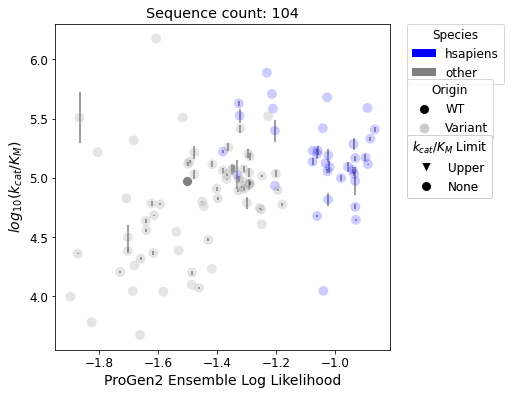

In [ ]:
# import Patch
from matplotlib.patches import Patch

# filter for substrate
substrate = 'AcP'

# select experiments from all_turnover_dfs_concat
expt_selections = [
                    '230207_AcP',
                    # '230410_AcP',
                    # '230419_AcP',
                    # '230612_AcP',
                    # '230622_AcP',
                    # '230629_AcP',
                    '240418_AcP',


                    # '230419_ATP',
                    '230612_ATP',
                    # '230622_ATP',

                    # '230419_PEP',
                    # '230612_PEP'
                    ]

df = all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'].isin(expt_selections)]

# remove well number from name and MutantID 
pattern = r'^\d+[A-Z]{1,2}\d+_'

for index, row in df.iterrows():
    df.loc[index, 'MutantID'] = re.sub(pattern, '', row['MutantID'])
    df.loc[index, 'name'] = re.sub(pattern, '', row['name'])

# add limit column to dataframe
df['limit'] = df['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")

# filter for local bg ratio > 2, enzyme conc > 5 nM, and kcat/KM > 1
df = df[df['local_bg_ratio'] > 2]
df = df[df['EnzymeConc'] > 2]
df = df[df['kcat_over_KM_fit_R2'] > 0.95]
df = df[df['substrate'] == substrate]

# get medians and SEM for each MutantID and drop duplicates
df = df.groupby(['MutantID', 'limit']).agg({'kcat_over_KM_fit': ['median', 'sem']}).reset_index()
df.columns = ['MutantID', 'limit', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_sem']

# merge ensemble_ll data with df from above
df = pd.merge(df, all_turnover_dfs_concat[['MutantID', 'name', 'ensemble_ll', 'species', 'origin']].drop_duplicates(), on='MutantID', how='left').drop_duplicates()

# make floats
df['ensemble_ll'] = df['ensemble_ll'].astype(float)

# create color dictionary for species
species_color_dict = {
    'hsapiens': 'blue',
    'other': 'grey'
}

# color by origin
origin_color_dict = {
    'WT': 'black',
    'mutant': 'red',
    'other': 'grey'
}

# set marker dictionary for style
marker_dict = {
    'None': 'o',
    'Upper': 'v'
}

# define limits
df['limit'] = df['limit'].astype(str)

# set origin to 'none'
df['origin'] = 'none'

# if MutantID contains 'wt', set origin to 'WT'
df.loc[df['MutantID'].str.contains('wt'), 'origin'] = 'WT'

# if MutantID contains 'lambda', set origin to 'progen'
df.loc[df['MutantID'].str.contains('lambda'), 'origin'] = 'progen'

# if MutantID contains 'pross', set origin to 'pross'
df.loc[df['MutantID'].str.contains('pross'), 'origin'] = 'pross'

# if MutantID contains mutation designation (e.g. M61A), set origin to 'mutant'
pattern = r'([A-Z]\d{1,}[A-Z])'
df.loc[df['MutantID'].str.contains(pattern), 'origin'] = 'mutant'

# set value of ensemble ll based on name column in single_mutant_likelihoods
for index, row in df.iterrows():
    name = row['name']
    if name in single_mutant_likelihoods['name'].values:
        df.loc[index, 'ensemble_ll'] = single_mutant_likelihoods.loc[single_mutant_likelihoods['name'] == name, 'progen2-large'].values[0]


# replace species other than those in species_color_dict with 'other'
df.loc[~df['species'].isin(species_color_dict.keys()), 'species'] = 'other'

# replace origin other than those in origin_color_dict with 'other'
df.loc[~df['origin'].isin(origin_color_dict.keys()), 'origin'] = 'other'

# # initialize figure
# fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# perform Spearman correlation test
df['ensemble_ll'] = df['ensemble_ll'].astype(float)
df['ensemble_ll'] = df['ensemble_ll'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['ensemble_ll'])
df = df.dropna(subset=['kcat_over_KM_fit_median'])
spearman_corr = df[['ensemble_ll', 'kcat_over_KM_fit_median']].corr(method='spearman').iloc[0, 1]

# plot scatter of kcat/KM vs ensemble_ll, including errors
plt.figure(figsize=(6, 6))
xdat = df['ensemble_ll'].to_numpy()
ydat = df['kcat_over_KM_fit_median'].to_numpy()
yerr = df['kcat_over_KM_fit_sem'].to_numpy()
xerr = np.zeros(len(xdat))
plt.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='none', color='black', alpha=0.5, zorder=2)
sns.scatterplot(data=df[df['origin'] == 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, zorder=3, style='limit', markers=marker_dict, legend=False)
sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, color='white', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False)
sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, alpha=0.2, zorder=2, style='limit', markers=marker_dict, legend=False)

# sns.scatterplot(data=df[df['origin'] == 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='origin', palette=origin_color_dict, zorder=3, style='limit', markers=marker_dict, legend=False)
# sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, color='white', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False)
# sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='origin', palette=origin_color_dict, alpha=1, zorder=2, style='limit', markers=marker_dict, legend=False)


# add legend2 with colors for species
legend2_elements = [Patch(facecolor=color, label=species) for species, color in species_color_dict.items()]
legend2 = plt.legend(handles=legend2_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Species')
plt.gca().add_artist(legend2)

# add legend3 with shades for origin
legend3_elements = [
                    Line2D([0], [0], marker='o', color='w', label='WT', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Variant', markerfacecolor='black', alpha=0.2, markersize=10),
                    ]
legend3 = plt.legend(handles=legend3_elements, bbox_to_anchor=(1.05, 0.83), loc=2, borderaxespad=0., title='Origin')
plt.gca().add_artist(legend3)

# add legend1 with markers for limit
legend1_elements = [
                    Line2D([0], [0], marker='v', color='w', label='Upper', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='None', markerfacecolor='black', markersize=10),
                    ]
legend1 = plt.legend(handles=legend1_elements, bbox_to_anchor=(1.05, 0.66), loc=2, borderaxespad=0., title='$k_{cat}/K_M$ Limit')
plt.gca().add_artist(legend1)

# set axis labels
# plt.title('Ensemble Log Likelihood vs $k_{cat}/K_M$ \n for %s' % substrate + '\nExperiments: %s' % ', '.join([x for x in expt_selections if substrate in x]))
plt.title('Sequence count: %s' % len(df))
plt.xlabel('ProGen2 Ensemble Log Likelihood', fontsize=14)
plt.ylabel('$log_{10}(k_{cat}/K_M)$', fontsize=14)
# plt.ylabel('$log_{10}(k_{cat}/K_M)$ for %s' % substrate, fontsize=12)

# Add label to human WT with AdjustText
texts = []
for i, row in df[df['origin'] == 'WT'].iterrows():
    if row['species'] == 'hsapiens':
        texts.append(plt.text(row['ensemble_ll'], row['kcat_over_KM_fit_median'], '$H. sapiens$ WT', fontsize=12))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'),
            expand_points=(2, 1), expand_text=(1.5, 1.5),
            force_text=(0.5, 0.5))

# Add Spearman correlation to top left
plt.text(0.05, 0.95, f'Spearman Corr.: {spearman_corr:.2f}', transform=plt.gca().transAxes, verticalalignment='top', size=12)

# Expand plot limits a bit
min_x, max_x = plt.xlim()
min_y, max_y = plt.ylim()
plt.xlim(min_x - 0.1*(max_x - min_x), max_x + 0.1*(max_x - min_x))
plt.ylim(min_y - 0.1*(max_y - min_y), max_y + 0.1*(max_y - min_y))

# Increase font size
plt.tick_params(axis='both', which='major', labelsize=14)

# make borders black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    
# set facecolor to white
plt.gcf().set_facecolor('white')

plt.show()

# save figure to file
# plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.svg', dpi=300, bbox_inches='tight')
# plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.png', dpi=300, bbox_inches='tight')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

dat = all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'] == '240418_AcP']

### Filtering ###
# remove low local background ratio
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 1]

# dat = dat.sample(50)
dat.sort_values('species', ascending=False, inplace=True)

# replace other species with "other"
keep_species = ['hsapiens', 'sbenthica', 'phorikoshii', 'hypf']
dat.loc[~dat['species'].isin(keep_species), 'species'] = 'other'

# keep only human mutants
dat = dat[dat['species'] == 'hsapiens']
dat = dat[dat['origin'] == 'mutant']

# create species colormap
colormap = {
    'hsapiens': 'orange',
    'sbenthica': 'blue',
    'phorikoshii': 'red',
    'hypf': 'green',
    'other': 'gray',
}

# Create a subplot, which will allow us to layer multiple scatter plots
fig = make_subplots()

# Now overlay mean kcat/km as point with species color
grouped = dat.groupby('MutantID')['kcat_over_KM_fit'].agg(['mean', 'std']).reset_index()
grouped['species'] = [dat[dat['MutantID'] == MutantID]['species'].values[0] for MutantID in grouped['MutantID']]

# Add the mean values
fig.add_trace(
    go.Scatter(
        x=grouped['MutantID'], 
        y=grouped['mean'], 
        mode='markers', 
        marker=dict(
            color=[colormap[species] for species in grouped['species']],
            size=10,
            line=dict(
                color='black',
                width=0.5
            )
        ),
        name='Mean values'
    )
)

# Add the
fig.add_trace(
    go.Scatter(
        x=dat['MutantID'], 
        y=dat['kcat_over_KM_fit'],
        mode='markers', 
        marker=dict(
            color='grey',
            size=5,
            opacity=0.3
        ),
        name='All data points'
    )
)


# Set the layout of the figure
fig.update_layout(
    autosize=False,
    height=800,  # Adjust the height to your preference
    plot_bgcolor = 'white'
)

# Set the x-axis label
fig.update_xaxes(title_text="Mutant ID")

# Set the y-axis label
fig.update_yaxes(title_text="log10(kcat/KM)")

# Show the plot
fig.show()

['2B6_sbenthica_highlambda_highid_7', '1B9_hsapiens2_lowlambda_lowid_1', '1G9_phorikoshii_highlambda_lowid_7']


/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_29945/1183997462.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_mut.drop_duplicates(subset=['Indices'], inplace=True)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_29945/1183997462.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_mut.drop_duplicates(subset=['Indices'], inplace=True)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_29945/1183997462.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,MutantID,mean,sem,species
0,1A6_hsapiens2_pross_9,5.221490,0.042155,hsapiens
1,1B4_hsapiens2_highlambda_highid_8,5.136777,0.095674,hsapiens
2,1C11_phorikoshii_pross_4,5.255342,0.140065,phorikoshii
3,1C6_phorikoshii_wt,4.955700,0.031318,phorikoshii
4,1C7_phorikoshii_pross_9,5.068866,0.053393,phorikoshii
...,...,...,...,...
56,3E1_hsapiens2_E83D,5.115664,0.015413,hsapiens
57,3E2_hsapiens2_I86V,5.215505,0.043410,hsapiens
58,3E3_hsapiens2_L89A,5.210446,0.209804,hsapiens
59,3E4_hsapiens2_Y91F,5.388356,0.019893,hsapiens


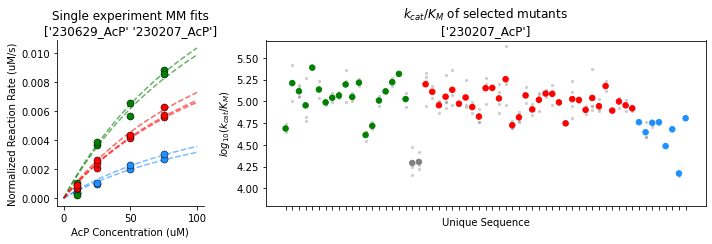

In [29]:
experiments = [
    '230207_AcP',
    '230629_AcP',
    # '230419_AcP',
    # '230612_AcP',
    # '230612_ATP',
    # '230419_ATP',
]

# define dat
dat = all_turnover_dfs_concat.copy()
dat = dat[dat['experiment'].isin(experiments)]
dat = dat[dat['MutantID'] != 'BLANK']

# if species is not in list, set to other
species = [
    'hsapiens', 
    'human', 
    'phorikoshii',
    'sbenthica',
    'hypf'
]

dat.loc[~dat['species'].isin(species), 'species'] = 'other'

# remove MM fits with R2 < 0.99
dat = dat[dat['kcat_over_KM_fit_R2'] > 0.95]

# filter for local bg ratio and EnzymeConc
dat = dat[dat['local_bg_ratio'] > 3]
dat = dat[dat['EnzymeConc'] > 3]

# filter our mutantids where kcat_over_KM_fit is too variable
for MutantID in dat['MutantID'].unique():
    mutant_dat = dat[dat['MutantID'] == MutantID]
    if mutant_dat['kcat_over_KM_fit'].sem() > 0.07:
        dat = dat[dat['MutantID'] != MutantID]

# filter out singlets
counts = dat['MutantID'].value_counts()
singlets = counts[counts == 1].index
dat = dat[~dat['MutantID'].isin(singlets)]

# define any desired mutants
mutant_selections = [

    "2B6_sbenthica_highlambda_highid_7",

    '1B9_hsapiens2_lowlambda_lowid_1',
    # '1B12_hsapiens2_lowlambda_lowid_4',
    # '3C10_human_ACYP2_T42A',

    '1G9_phorikoshii_highlambda_lowid_7',

]

# set target number of mutants
target_n_mutants = 3

# add random mutants to list
for i in range(target_n_mutants):
    if len(mutant_selections) < target_n_mutants:
        random_mutant = dat.sample(n=1)['MutantID'].values[0]

        mutant_selections.append(random_mutant)


color_map = {
    'sbenthica': 'dodgerblue',
    'hsapiens': 'green',
    'phorikoshii': 'red',
    'hypf': 'orange',
    'other': 'grey',
}

# sort dat by species
dat = dat.sort_values(by='species')

# initialize figure
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), gridspec_kw={'width_ratios': [1,3]})

print(mutant_selections)

# for each mutant, plot the MM fits
for i, MutantID in enumerate(mutant_selections):

    # filter for single experiment
    experiment = '230629_AcP'
    dat_mut = dat[dat['experiment'] == experiment]
    
    # filter all_turnover_dfs_concat, experiment, and MutantID
    dat_mut = dat[dat['MutantID'].str.contains(MutantID)]

    # drop Indices duplicates
    dat_mut.drop_duplicates(subset=['Indices'], inplace=True)

    # get species
    species = dat_mut['species'].values[0]

    # define MM function
    def MM(vmax, KM, S):
        return (vmax * S) / (KM + S)

    # for each replicate, plot the kcat/KM fit
    for index, row in dat_mut.iterrows():

        # skip if MM_points_to_fit is 2 or less
        points_fit = row['MM_points_to_fit']
        if points_fit <= 2:
            continue

        vi_list = ast.literal_eval(row['initial_rates'])
        s_list = ast.literal_eval(row['substrate_concs'])
        max_S = max(s_list)
        
        ### Plot Curve Fit ###
        E0 = row['EnzymeConc']
        KM = row['KM_fit']
        kcat = row['kcat_fit']
        vmax = row['vmax_fit']/E0
        x = np.linspace(0, max_S, 1000)
        y = MM(vmax, KM, x)
        axs[0].plot(x, y, color=color_map[species], label=MutantID, linestyle='--', alpha=0.6, zorder=0)

        ### Plot Points ###
        exclude_concs = ast.literal_eval(row['exclude_concs'])
        # exclude_concs = []
        exclude_indices = [i for i, x in enumerate(s_list) if x in exclude_concs]
        vi_list = np.array([i for j, i in enumerate(vi_list) if j not in exclude_indices])
        s_list = np.array([i for j, i in enumerate(s_list) if j not in exclude_indices])

        # normalize vi_list by E0
        vi_list = vi_list / E0

        axs[0].scatter(x=s_list, y=vi_list, color=color_map[species], s=50, linewidth=0.5, edgecolor='black', zorder=10)


# add labels
axs[0].set_xlabel('AcP Concentration (uM)')
axs[0].set_ylabel('Normalized Reaction Rate (uM/s)')
axs[0].set_title('Single experiment MM fits\n%s' % dat_mut['experiment'].unique())

# color borders black
for spine in axs[0].spines.values():
    spine.set_edgecolor('black')

# remove top and right borders
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)




##### plot boxplot of selected mutants #####

# filter for only selected mutants
dat_reps = dat[dat['experiment'] == '230207_AcP']
# dat_reps = dat.copy()
dat_reps = dat_reps.drop_duplicates(subset=['Indices'])

# increase stringency
dat_reps = dat_reps[dat_reps['local_bg_ratio'] > 2]
dat_reps = dat_reps[dat_reps['EnzymeConc'] > 3]

# remove singleton MutantIDs
counts = dat_reps['MutantID'].value_counts()
singlets = counts[counts == 1].index
dat_reps = dat_reps[~dat_reps['MutantID'].isin(singlets)]


axs[1].scatter(data=dat_reps, x='MutantID', y='kcat_over_KM_fit', s=5, zorder=3, color='grey', alpha=0.3)


# now overlay mean kcat/km as point with species color
grouped = dat_reps.groupby('MutantID')['kcat_over_KM_fit'].agg(['mean', stats.sem])
grouped = grouped.reset_index()
grouped['species'] = [dat_reps[dat_reps['MutantID'] == MutantID]['species'].values[0] for MutantID in grouped['MutantID']]
display(grouped)
axs[1].scatter(data=grouped, x='MutantID', y='mean', s=30, zorder=10, color=[color_map[species] for species in grouped['species']])

axs[1].set_xticklabels([])
axs[1].set_title('$k_{cat}/K_M$ of selected mutants\n%s' % dat_reps['experiment'].unique())
axs[1].set_ylabel('$log_{10}(k_{cat}/K_M)$')
axs[1].set_xlabel('Unique Sequence')
axs[1].set_ylim(3.8, 5.7)

# # remove legend
# axs[1].get_legend().remove()

# # add legend
# handles = []
# for i, MutantID in enumerate(mutant_selections):
#     handles.append(mpatches.Patch(color=color_map[MutantID], label=MutantID))
# axs[1].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title='Sequence')

# save figure
# plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_example_MM_fit_replicates_withinExpt/' + experiment + '_MM_fits.pdf', bbox_inches='tight')
fig.tight_layout()
fig.savefig('/Users/micaholivas/Downloads/AcP_MM_fits.pdf')

plt.show()

In [30]:
# filter data
species_list = [
       # 'Azospirillum_oryzae', 'Salinivibrio_costicola',
       # 'Nonomuraea_jiangxiensis', 'Klebsiella_michiganensis',
       # 'Providencia_rettgeri', 'Anaeromyxobacter_dehalogenans',
       # 'Streptomyces_bikiniensis', 'Lactobacillus_pobuzihii',
       # 'Methylocystis_rosea', 'Rhizobium_mesoamericanum',
       # 'Rhodopseudomonas_palustris',
       # 'sbenthica',
       # 'hsapiens',
       'hypf'
       ]
dat = all_turnover_dfs_concat[(all_turnover_dfs_concat['substrate'] == 'AcP') & (all_turnover_dfs_concat['species'].isin(species_list))]
subset_on = ['Indices', 'experiment']
dat = dat.drop_duplicates(subset=subset_on)

# dat = dat[dat['local_bg_ratio'] > 2]
# dat = dat[dat['kcat_over_KM_fit_R2'] > 0.9]

# select experiment
experiment = '230207_AcP'
dat = dat[dat['experiment'] == experiment]

## plot replicates within experiment

# init replicate_dict
replicate_dict = dict(zip(dat['MutantID'].unique(), range(len(dat['MutantID'].unique()))))

for k in replicate_dict.keys():
       replicate_dict[k] = []

# iterate through dict
for i in range(10):
       for seq in replicate_dict.keys():
              dat_spec = dat[dat['MutantID'] == seq]

              if len(dat_spec) > 1:
                     dat_reps = dat_spec.sample(2, replace=False)

                     # store activities in dictionary
                     activities = dat_reps['exponential_kcat_over_km_list_0'].to_list()
                     replicate_dict[seq].append(activities)

fig, ax = plt.subplots(figsize=(4, 4))

# plot points
for k,v in replicate_dict.items():
       for i in v:
              ax.scatter(x=i[0], y=i[1])

min = 3
max = 7

ax.set_xlim(min, max)
ax.set_ylim(min, max)


plt.show()

KeyError: 'exponential_kcat_over_km_list_0'

<AxesSubplot:xlabel='experiment', ylabel='kcat_over_KM_fit'>

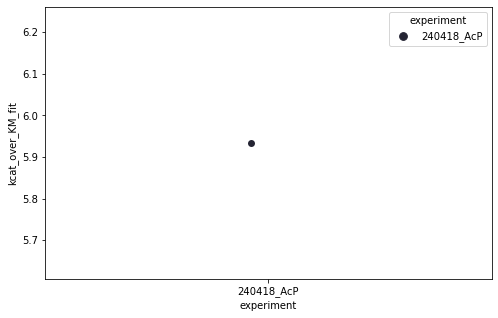

In [31]:
# get stripplot of kcat/KM for hsapiens2 WT in each experiment
fig, ax = plt.subplots(figsize=(8, 5))

# filter data
dat = all_turnover_dfs_concat[(all_turnover_dfs_concat['species'] == 'hsapiens') & (all_turnover_dfs_concat['origin'] == 'WT') & (all_turnover_dfs_concat['substrate'] == 'AcP')]

# filter local background
dat = dat[dat['local_bg_ratio'] > 2]

sns.stripplot(data=dat, x='experiment', y='kcat_over_KM_fit', hue='experiment', dodge=True, color='blue', ax=ax, jitter=0.4, size=7)

{'240418_AcP': [6.118368755210546, 6.547454042156874, 5.933777979051895, 6.436758909164415, 6.203574707377027]}


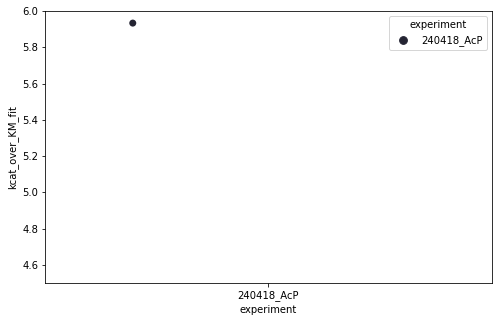

In [32]:
# get stripplot of kcat/KM for hsapiens2 WT in each experiment
fig, ax = plt.subplots(figsize=(8, 5))

# filter data
dat = all_turnover_dfs_concat[(all_turnover_dfs_concat['species'] == 'hsapiens') & (all_turnover_dfs_concat['origin'] == 'WT') & (all_turnover_dfs_concat['substrate'] == 'AcP')]

# remove experiments
remove_expts = ['221201_AcP', '230410_AcP', '230622_AcP']
dat = dat[~dat['experiment'].isin(remove_expts)]

# drop duplicates
dat = dat.drop_duplicates(subset=['Indices', 'experiment'])

# filter local background
dat = dat[dat['local_bg_ratio'] > 1]

sns.stripplot(data=dat, x='experiment', y='kcat_over_KM_fit', hue='experiment', dodge=True, color='blue', ax=ax, jitter=0.4, size=7)

plt.ylim(4.5, 6)

# export data to dictionary, with experiment as key and kcat/KM as value
export_dict = {}
for experiment in dat['experiment'].unique():
    export_dict[experiment] = dat[dat['experiment'] == experiment]['kcat_over_KM_fit'].to_list()
print(export_dict)

Format exponentials for each experiment

In [33]:
# in all_turnover_dfs['230629_AcP'], expand exponential_kcat_over_km_list to multiple columns
exp_list = [    
            # '221201_AcP',
            '230207_AcP', 
            '230410_AcP', 
            '230419_AcP', 
            '230612_AcP', 
            # '230622_AcP', 
            '230629_AcP', 
        
            '230419_ATP',
            '230612_ATP',
            # '230622_ATP',

            '230419_PEP', 
            '230612_PEP',
                ]

for col in all_turnover_dfs_concat.columns:
    if 'exponential_kcat_over_km_list_' in col:
        del all_turnover_dfs_concat[col]

for index, row in all_turnover_dfs_concat.iterrows():
    if row['exponential_kcat_over_km_list'] != []:
        if 'nan' not in str(row['exponential_kcat_over_km_list']) and 'nan' not in str(row['exponential_R2_list']) and 'nan' not in str(row['exponential_A_list']):
            curr_list = ast.literal_eval(str(row['exponential_kcat_over_km_list']))
            curr_R2_list = ast.literal_eval(str(row['exponential_R2_list']))
            curr_A_list = ast.literal_eval(str(row['exponential_A_list']))
            for i, item in enumerate(curr_list):
                if curr_R2_list[i] > 0.9:
                    item = np.log10(item)
                    all_turnover_dfs_concat.loc[index, 'exponential_kcat_over_km_list_' + str(i)] = item


/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_29945/433159332.py:31: RuntimeWarning: invalid value encountered in log10
  item = np.log10(item)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_29945/433159332.py:31: RuntimeWarning: invalid value encountered in log10
  item = np.log10(item)


### Plot mutational composition of designed sequences

AttributeError: 'DataFrame' object has no attribute 'append'

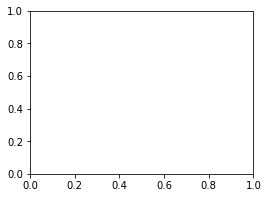

In [34]:
# create dict to contain distance of design from WT
distance_dict = {}

# iterate through each sequence in full_protein_sequence_library and get mutational distance from WT, then add to dict
for index, row in full_protein_sequence_library.iterrows():
    # get species and origin
    species = row['species']
    origin = row['origin']

    if species not in distance_dict.keys():
        distance_dict[species] = {}
    if origin not in distance_dict[species].keys():
        distance_dict[species][origin] = []

    if (row['origin'] == 'progen') or (row['origin'] == 'pross'):
        # get sequence and wt sequence
        seq = row['protein_sequence']
        wt_seq = row['protein_sequence_wt']

        # get distance
        dist = 0
        for i in range(len(seq)):
            if seq[i] != wt_seq[i]:
                dist += 1

        distance_dict[species][origin].append(dist)

# plot stripplot of distance from distance dict, with species as y axis bin and origin as hue
fig, ax = plt.subplots(figsize=(4, 3))

# create dataframe from distance dict
distance_df = pd.DataFrame(columns=['species', 'origin', 'distance'])
for species in distance_dict.keys():
    for origin in distance_dict[species].keys():
        for dist in distance_dict[species][origin]:
            distance_df = distance_df.append({'species': species, 'origin': origin, 'distance': dist}, ignore_index=True)

# plot stripplot
palette = {'pross': 'blue', 'progen': 'orange'}
sns.stripplot(data=distance_df, x='distance', y='species', hue='origin', dodge=True, palette=palette, ax=ax, jitter=0.1, size=7, alpha=0.7, linewidth=0.5, edgecolor='black')

# legend
handles = [
    mpatches.Patch(color='blue', label='PROSS'),
    mpatches.Patch(color='orange', label='ProGen2'),
]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title='Model')

# add vertical gridlines
for i in range(0, 50, 10):
    ax.axvline(i, color='lightgrey', linewidth=1)

# add title and labels
ax.set_title('Mutational distance of designed sequences from WT')
ax.set_xlabel('Mutational distance from WT (aa)')
ax.set_ylabel('Species')

# set y tick labels from dictionary
species_dict = {
    'hsapiens': 'Human AcyP2',
    'sbenthica': '$S. benthica$ AcyP',
    'hypf': '$C. subterraneus$ HypF-ACP',
    'phorikoshii': '$P. horikoshii$ AcyP',
}
ax.set_yticklabels([species_dict[item.get_text()] for item in ax.get_yticklabels()])

# make borders black
for _, spine in ax.spines.items():
    spine.set_color('black')

# set xlim to 0-1
ax.set_xlim(0, 50)

# set facecolor to white
plt.gca().set_facecolor('white')

# save figure
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/Library_information/Mutation_counts_by_species/percent_identity_to_WT.pdf', bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/Library_information/Mutation_counts_by_species/percent_identity_to_WT.png', bbox_inches='tight', dpi=300)



### Compare effects of SDS wash on enzymatic rates

In [ ]:
# import Decimal
from decimal import Decimal

# import Patch
from matplotlib.patches import Patch

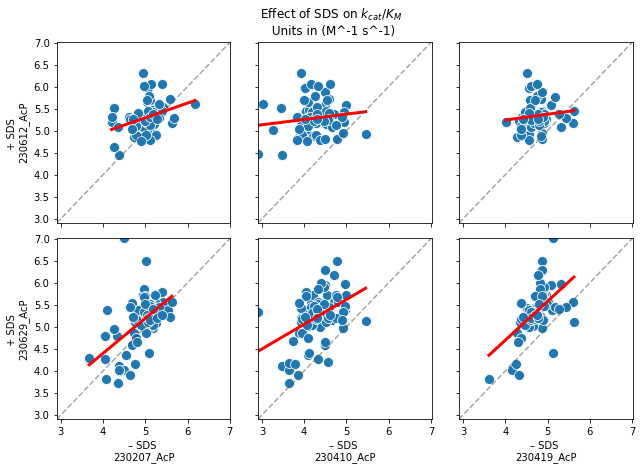

In [35]:
substrate = 'AcP'
low_enzyme_conc = 2
local_bg_ratio = 2
kcat_over_KM_R2 = 0.95

# create concatenated dataframe
df = all_turnover_dfs_concat.copy()
df = df[df['substrate'] == substrate]
df = df[df['EnzymeConc'] > low_enzyme_conc]
df = df[df['local_bg_ratio'] > local_bg_ratio]
df = df[df['kcat_over_KM_fit_R2'] > kcat_over_KM_R2]

# select experiments to plot and SDS added
AcP_SDS_experiments = {
    '230207_AcP': False,
    '230410_AcP': False,
    '230419_AcP': False,
    '230612_AcP': True,
    # '230622_AcP': True,
    '230629_AcP': True,

    '230419_ATP': False,
    '230612_ATP': True,

    '230419_PEP': False,
    '230612_PEP': True
}

df = df[df['experiment'].isin(AcP_SDS_experiments.keys())]
df['SDS_added'] = df['experiment'].apply(lambda x: AcP_SDS_experiments[x])

# get medians within each experiment and replace valyues with medians
df = df.groupby(['MutantID', 'experiment']).agg({'kcat_over_KM_fit': 'median', 'kcat_over_KM_fit_R2': 'median', 'local_bg_ratio': 'median', 'SDS_added': 'median'}).reset_index()

# pivot dataframe using MutantID as index, experiment as columns, and kcat/KM as values
df = df.pivot(index='MutantID', columns='experiment', values='kcat_over_KM_fit')

# plot the scatter matrix
def plot_sds_scatter_matrix(df, AcP_SDS_experiments):
    # Separate columns based on SDS addition
    cols_without_SDS = [col for col in df.columns if col in AcP_SDS_experiments and not AcP_SDS_experiments[col]]
    cols_with_SDS = [col for col in df.columns if col in AcP_SDS_experiments and AcP_SDS_experiments[col]]

    # Select only those columns
    df_selected = df[cols_without_SDS + cols_with_SDS]
    
    # Create a grid for pairplot. Only plot experiments with SDS on y-axis and without SDS on x-axis
    g = sns.PairGrid(df_selected, x_vars=cols_without_SDS, y_vars=cols_with_SDS, height=3)
    g.map(sns.scatterplot, s=100)
    g.map(sns.regplot, scatter=False, color='red', line_kws={'lw': 3}, ci=None)
    
    # Calculate absolute min and max values for the dataset
    absolute_min = df_selected.min().min()
    absolute_max = df_selected.max().max()

    # Set properties and labels
    for row_axes in g.axes:
        for ax in row_axes:
            # Set x and y limits using absolute min and max
            ax.set_xlim(absolute_min, absolute_max)
            ax.set_ylim(absolute_min, absolute_max)

            # Add 1:1 line
            ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", alpha=0.5)
            # Set spines
            for _, spine in ax.spines.items():
                spine.set_visible(True)

    # Modify axis labels
    for ax in g.axes[-1, :]:
        xlabel = ax.get_xlabel()
        SDS_added = AcP_SDS_experiments.get(xlabel, False)
        if SDS_added:
            ax.set_xlabel('+ SDS \n' + xlabel)
        else:
            ax.set_xlabel('– SDS \n' + xlabel)

    for ax in g.axes[:, 0]:
        ylabel = ax.get_ylabel()
        SDS_added = AcP_SDS_experiments.get(ylabel, False)
        if SDS_added:
            ax.set_ylabel('+ SDS \n' + ylabel)
        else:
            ax.set_ylabel('– SDS \n' + ylabel)

    # set facecolor to white
    g.fig.set_facecolor('white')
    
    plt.suptitle('Effect of SDS on $k_{cat}/K_M$ \n Units in (M^-1 s^-1)', y=1.05)
    plt.show()

plot_sds_scatter_matrix(df, AcP_SDS_experiments)

,Unnamed: 0,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,kcat_over_KM_fit_R2,exclude_concs,local_bg_ratio,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM,initial_rate,initial_rate_intercept,two_point_fit,rate_fit_regime,GlobalExperimentIndex,Experiment,name,mutation,species,origin,sampling_replicate,lambda,seq_id,experiment,exponential_A_list,exponential_kobs_list,exponential_y0_list,exponential_R2_list,exponential_kcat_over_km_list,MM_points_to_fit,local_bg_substrate_conc,kobs_kcat_over_KM,num_points_fit_vo_list,num_points_fit_vo,exponential_A,exponential_kobs,exponential_y0,exponential_R2,kobs_kcat_KM,local_bg_substrate_conc_x,local_bg_substrate_conc_y,local_bg_substrate_conc_x.1,local_bg_substrate_conc_y.1,local_bg_substrate_conc_x.2,local_bg_substrate_conc_y.2,local_bg_substrate_conc_x.3,local_bg_substrate_conc_y.3,max_exp_R2,n_mutations,ensemble_ll,predicted_tm,protein_sequence,protein_sequence_wt,exponential_kcat_over_km_list_0,exponential_kcat_over_km_list_1,exponential_kcat_over_km_list_2,exponential_kcat_over_km_list_4,exponential_kcat_over_km_list_3,exponential_kcat_over_km_list_6,exponential_kcat_over_km_list_5
52743,80,1,21,"01,21",1C9_phorikoshii_pross_3,PEP,42.366767,False,"[50, 100, 250, 500]","[0.004714985571277888, 0.00478815706410333, 0....",10.000000,0.005063,0.119514,4.077420,0.305692,[],8.467290,50.0,7626018,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[5851, 5967, 6155, 6373, 6636, 6892, 7143, 740...","[1, 6, 15, 30, 75]","[12073, 12500, 21957, 24834, 25691]",[7.47099347e+02 2.86592357e-17 1.98136011e+01 ...,"[-5.570999999999998, -5.420399999999997, -5.16...",0.004715,-5.892692,False,2.0,230419_S2_d2_PEP,AcyP_SFL_203,phorikoshii_pross_3,NaN,phorikoshii,mutant,3,NaN,NaN,230419_PEP,"[136.94789571441729, 263.01195823435785, 139.3...","[3.5523137802952506e-05, 1.8355491569521023e-0...","[-5.924464726433911, -5.483891783973761, -3.83...","[0.9990190378497258, 0.9986881090415145, 0.998...","[16.769340970691257, 4.332521222102786, 3.2683...",NaN,NaN,16.769341,NaN,NaN,136.947896,0.000036,-5.924465,0.999019,16.769341,500.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.999019,3.0,-1.499566317,79.51148453,MAIVRAHLFIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,MAIVRAHLKIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,1.224516,0.636741,0.51433,NaN,0.415286,NaN,NaN
52767,104,1,27,"01,27",1C11_phorikoshii_pross_4,PEP,44.685400,False,"[50, 100, 250, 500]","[0.0008277848549186129, 0.0007399141306911997,...",10.000001,0.000770,0.017222,3.236093,0.994043,[],3.315789,50.0,8043372,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[5733, 5785, 5797, 5845, 5883, 5931, 5962, 600...","[1, 6, 15, 30, 75]","[11264, 12321, 21875, 24374, 25130]",[7.94122521e+02 1.62870976e-19 1.89444719e+01 ...,"[-4.516799999999996, -4.4666, -4.4666, -4.3661...",0.000828,-4.575740,False,2.0,230419_S2_d2_PEP,AcyP_SFL_203,phorikoshii_pross_4,NaN,phorikoshii,mutant,4,NaN,NaN,230419_PEP,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,-1.477865946,79.09047775,MAIVRAHLFIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,MAIVRAHLKIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52791,128,1,33,"01,33",1E3_phorikoshii_lowlambda_highid_13,PEP,35.488528,False,"[50, 100, 250, 500]","[0.008513570920584749, 0.008966051889898593, 0...",10.000000,0.009552,0.269165,4.430019,0.394631,[],14.689076,50.0,6387935,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[4294, 4506, 4833, 5276, 5736, 6244, 6755, 727...","[1, 6, 15, 30, 75]","[6654, 9637, 17038, 18652, 19238]",[7.51324504e+02 3.55871511e-16 1.73720493e+01 ...,"[-1.7557999999999971, -1.4545999999999992, -1....",0.008514,-2.182847,False,2.0,230419_S2_d

{'1C9_phorikoshii_pross_3': [1.2245159953183005], '1C11_phorikoshii_pross_4': [1.4354409903045928], '1E3_phorikoshii_lowlambda_highid_13': [2.6961939909570605], '2E11_hypf_lowlambda_highid_9': [1.2009839156394846], '1F5_phorikoshii_highlambda_highid_13': [], '2D4_sbenthica_highlambda_lowid_7': [1.7387663892039893, 1.6236436818765565], '1C8_phorikoshii_pross_2': [1.201467997499331, 2.552756509803346], '2F1_hypf_lowlambda_highid_11': [1.5303163400746003], '1H10_sbenthica_lowlambda_highid_1': [], 'BLANK': [3.5080286041081763, -1.595002959093364, 1.0861262387388788], '1C4_hsapiens2_lowlambda_lowid_8': [2.4378313424305036], '3E4_hsapiens2_Y91F': [], '2D6_sbenthica_highlambda_lowid_9': [], '2G11_hypf_lowlambda_lowid_6': [], '3E3_hsapiens2_L89A': [3.0035454695122303, 1.7177101029603763], '1B8_hsapiens2_highlambda_highid_12': [2.8612592986176395], '1A5_hsapiens2_pross_6': [-14.845972571304033], '1A2_hsapiens2_pross_5': [], '1D10_phorikoshii_lowlambda_highid_8': [2.0940094669615728], '1D3_phori

,MutantID,replicate_1,replicate_2
0,2D4_sbenthica_highlambda_lowid_7,1.738766,1.623644
0,1C8_phorikoshii_pross_2,1.201468,2.552757
0,BLANK,3.508029,-1.595003
0,3E3_hsapiens2_L89A,3.003545,1.717710
0,1D3_phorikoshii_lowlambda_highid_1,-2.085338,3.033680
0,3C11_hsapiens2_G45A,2.695782,0.934313
0,3C10_hsapiens2_T42A,2.191677,2.732302
0,1C2_hsapiens2_lowlambda_lowid_6,2.745518,2.632463
0,3B7_hsapiens2_V9A,2.047624,2.021114
0,3E5_hsapiens2_F94L,1.852233,1.711594


Text(0, 0.5, 'Replicate 2')

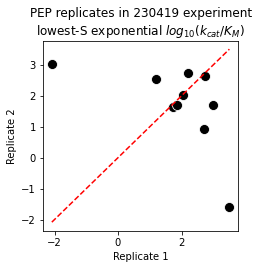

In [174]:
# plot replicates in the 0419 PEP experiment
# filter data
dat = all_turnover_dfs_concat[(all_turnover_dfs_concat['experiment'] == '230419_PEP') & (all_turnover_dfs_concat['substrate'] == 'PEP')]
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 2]

exponential_idx = 0

# drop duplicates
dat = dat.drop_duplicates(subset=['Indices'])

# get all unique MutantIDs
mutant_ids = dat['MutantID'].unique()

# create dictionary to store replicate data
replicate_dict = {}
for mutant_id in mutant_ids:
    replicate_dict[mutant_id] = []

# iterate through each MutantID and get replicate data
for mutant_id in mutant_ids:
    dat_mut = dat[dat['MutantID'] == mutant_id]
    for index, row in dat_mut.iterrows():
        # get kcat/KM values
        values = row['exponential_kcat_over_km_list']
        
        # repalce nan with 0
        values = values.replace('nan', '-1')
        values = ast.literal_eval(values)
        value = values[exponential_idx]
        if value != -1:
            # log it
            value = np.log10(value)
            replicate_dict[mutant_id].append(value)
    


print(replicate_dict)
# convert to dataframe
replicate_df = pd.DataFrame(columns=['MutantID', 'replicate_1', 'replicate_2'])
for mutant_id, replicates in replicate_dict.items():
    if len(replicates) == 2:
        # concatenate to dataframe
        replicate_df = pd.concat([replicate_df, pd.DataFrame({'MutantID': [mutant_id], 'replicate_1': [replicates[0]], 'replicate_2': [replicates[1]]})])
    elif len(replicates) > 2:
        # randomly sample 2 replicates
        replicates = np.random.choice(replicates, 2, replace=False)
        replicate_df = pd.concat([replicate_df, pd.DataFrame({'MutantID': [mutant_id], 'replicate_1': [replicates[0]], 'replicate_2': [replicates[1]]})])

display(replicate_df)

# plot scatterplot of replicates
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(data=replicate_df, x='replicate_1', y='replicate_2', ax=ax, s=100, color='black')

# plot 1:1 line from data
min_val = min(replicate_df['replicate_1'].min(), replicate_df['replicate_2'].min())
max_val = max(replicate_df['replicate_1'].max(), replicate_df['replicate_2'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# add title, labels and styling
ax.set_title('PEP replicates in 230419 experiment\nlowest-S exponential $log_{10}(k_{cat}/K_M)$')
ax.set_xlabel('Replicate 1')
ax.set_ylabel('Replicate 2')


In [175]:
all_turnover_dfs_concat['experiment'].unique()

array(['221201_AcP', '230207_AcP', '230410_AcP', '230419_AcP',
       '230612_AcP', '230622_AcP', '230629_AcP', '240418_AcP',
       '230419_ATP', '230612_ATP', '230622_ATP', '230419_PEP',
       '230612_PEP'], dtype=object)

## Plot background between SDS experiments

In [75]:
# select experiments to plot and SDS added
SDS_experiments = {
    '230207_AcP': False,
    '230410_AcP': False,
    '230419_AcP': False,
    '230612_AcP': True,
    # '230622_AcP': True,
    '230629_AcP': True,

    '230419_ATP': False,
    '230612_ATP': True,

    '230419_PEP': False,
    '230612_PEP': True
}

# plot histograms for two experiments
df = all_turnover_dfs_concat.copy()
df = df[df['MutantID'] == 'BLANK']
df = df[['MutantID', 'Indices', 'experiment', 'EnzymeConc', 'initial_rates']].drop_duplicates()

# expand initial rates column with ast.literal_eval
for index, row in df.iterrows():
    if 'nan' not in row['initial_rates']:
        for n in range(len(ast.literal_eval(row['initial_rates']))):
            df.loc[index, 'initial_rates_' + str(n)] = ast.literal_eval(row['initial_rates'])[n]
df.drop('initial_rates', axis=1, inplace=True)

<AxesSubplot:xlabel='experiment', ylabel='initial_rates_1'>

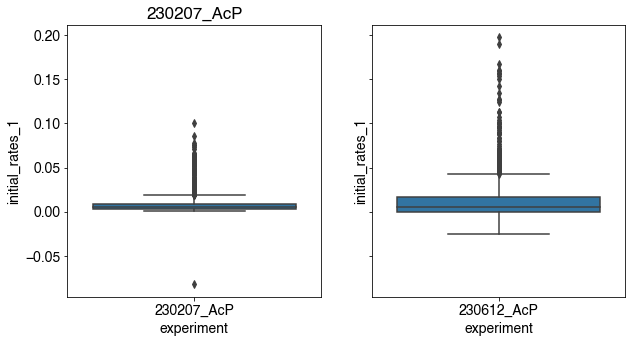

In [76]:
# 2 subplots, one for each experiment
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=False)

# plot boxplots for each experiment
val_expt1 = df[df['experiment'] == '230207_AcP']
sns.boxplot(x='experiment', y='initial_rates_1', data=val_expt1, ax=ax[0])
ax[0].set_title('230207_AcP')

val_expt2 = df[df['experiment'] == '230612_AcP']
sns.boxplot(x='experiment', y='initial_rates_1', data=val_expt2, ax=ax[1])

## Plot kcat/KM replicates

Next plot the log transformed values

In [78]:
dat = all_turnover_dfs_concat[['MutantID', 'protein_sequence',	'protein_sequence_wt', 'species', 'origin']].drop_duplicates()

# calculate number of mutations in each sequence compared to WT
def get_percent_ID(seq1, seq2):
    if seq1 == seq2:
        return 100
    else:
        return (sum(1 for a, b in zip(seq1, seq2) if a == b) / len(seq1) * 100)
    
dat['percent_ID'] = dat.parallel_apply(lambda x: get_percent_ID(x['protein_sequence'], x['protein_sequence_wt']), axis=1)

# remove consensus and uncharacterized from species
dat = dat[~dat['species'].isin(['consensus', 'uncharacterized'])]
dat = dat[~dat['origin'].isin(['WT', 'mutant'])]

# set plot size
plt.figure(figsize=(4, 4))

# plot stripplot of percent ID for each origin, subplots for each species
sns.stripplot(data=dat,
            x='species',
            y='percent_ID',
            hue='origin',
            size=10,
            alpha=0.5,
            )

plt.ylim(50, 100)
plt.ylabel('Percent ID to Self WT Protein Sequence')
plt.xlabel('Species')
plt.title('Percent ID to Starting WT \n for Each Designed AcyP')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Design\nAlgorithm')

# set facecolor to white
plt.gcf().set_facecolor('white')
                                   

TypeError: 'float' object is not iterable

<Figure size 1440x1440 with 0 Axes>

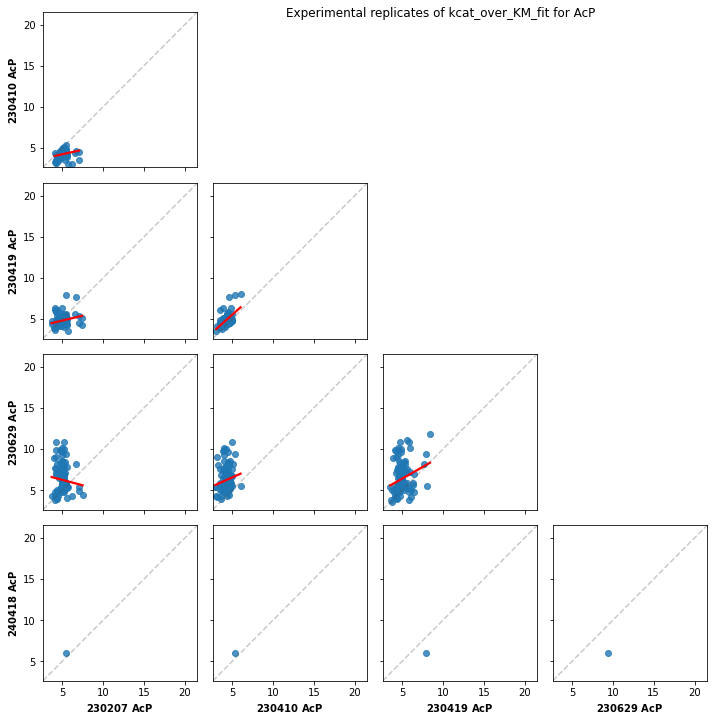

In [101]:
# select a parameter to plot
# param = 'kcat_fit'
# param = 'exponential_kcat_over_km_list_1'
param = 'kcat_over_KM_fit'
substrate = 'AcP'

# concatenate all dataframes into one
all_dat = all_turnover_dfs_concat.copy()
all_dat

# select only good experiments
expt_selections = [
                    '230207_AcP',
                    '230410_AcP',
                    '230419_AcP',
                    # '230612_AcP',
                    '230629_AcP',
                    '240418_AcP',

                    '230419_ATP',
                    '230612_ATP',

                    '230419_PEP',
                    '230612_PEP'
                    ]
all_dat = all_dat[all_dat['experiment'].isin(expt_selections)]

# filter for single substrate
dat = all_dat[all_dat['substrate'] == substrate]

# filter for local bg ratio > 2, enzyme conc > 5 nM, and kcat/KM > 1
dat = dat[dat['local_bg_ratio'] > 2]
# dat = dat[dat['EnzymeConc'] > 1]

# # remove duplicates
# dat = dat.drop_duplicates(subset=['MutantID', 'experiment'])

# get medians within each experiment and replace valyues with medians
dat = dat.groupby(['MutantID', 'experiment']).agg({param: 'median'}).reset_index()

# pivot dataframe using MutantID as index, experiment as columns, and kcat/KM as values
all_dat_kcatKM = dat.pivot(index='MutantID', columns='experiment', values=param)

# set figure size
plt.figure(figsize=(20, 20))

# plot scatter matrix, no diagonal plots, add regression line to each plot
g = sns.pairplot(all_dat_kcatKM, diag_kind='none', kind='reg', plot_kws={'line_kws':{'color':'red'}, 'ci': None})

# pick min and max values for x and y axes
min_val = all_dat_kcatKM.min().min() * 0.9
max_val = all_dat_kcatKM.max().max() * 1.1

# loop to set various ax attributes
for ax in g.axes.flat:
    # set spines
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    # set limits
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    # set facecolor to white
    ax.set_facecolor('white')

    # add 1:1 line to each plot as dotted line
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", alpha=0.3)

# remove the redundant plots (upper triangle and diagonal)
for i, j in zip(*np.triu_indices_from(g.axes)):
    g.axes[i, j].set_visible(False)

# Modify axis labels
for ax in g.axes[-1, :]:  # Only the bottom row for x-labels
    xlabel = ax.get_xlabel()
    ax.set_xlabel(r'$\mathbf{' + xlabel.replace('_', '\ ') + '}$')

for ax in g.axes[:, 0]:  # Only the first column for y-labels
    ylabel = ax.get_ylabel()
    ax.set_ylabel(r'$\mathbf{' + ylabel.replace('_', '\ ') + '}$')


# # use adjust_text to annotate outliers in each plot with MutantID
# for ax in g.axes.flat:

# Adjust space between plots
g.fig.subplots_adjust(wspace=0.1, hspace=0.1)

# add super title
g.fig.suptitle('Experimental replicates of %s for %s' % (param, substrate), y=0.8)

# set figure facecolor to white
g.fig.patch.set_facecolor('white')

# # save figure to file
# directory = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/Experimental_replicates'
# plt.savefig(directory + '/%s_%s_scatter_matrix.png' % (substrate, param), dpi=300, bbox_inches='tight')
# plt.savefig(directory + '/%s_%s_scatter_matrix.pdf' % (substrate, param), dpi=300, bbox_inches='tight')

plt.show()

## Substrate promiscuity

In [462]:
# add limit column
all_turnover_dfs_concat['limit'] = all_turnover_dfs_concat['local_bg_ratio'].apply(lambda x: True if x < 2 else False)

In [827]:
dat = all_turnover_dfs_concat[all_turnover_dfs_concat['substrate'] == 'ATP']
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 1]
dat[['name', 'experiment', 'local_bg_ratio', 'EnzymeConc', 'kcat_over_KM_fit']].sample(20).sort_values('name')

,name,experiment,local_bg_ratio,EnzymeConc,kcat_over_KM_fit
48812,BLANK,230622_ATP,2.311475,2.744360,4.101676
45207,WP_025744656 1_647301065_acylphosphatase_Salin...,230612_ATP,7.539671,8.437155,2.254304
49777,hsapiens2_F22L,230622_ATP,5.846154,26.884940,-0.219784
44475,hsapiens2_highlambda_highid_5,230612_ATP,18.790068,3.776015,2.798192
43549,hsapiens2_lowlambda_lowid_1,230612_ATP,13.964161,5.308635,2.917256
44022,hypf_lowlambda_lowid_7,230612_ATP,4.333333,3.665015,2.041067
46951,hypf_pross_6,230622_ATP,5.428571,1.909560,3.017060
46952,hypf_pross_6,230622_ATP,5.428571,1.909560,3.017060
44196,phorikoshii_highlambda_highid_2,230612_ATP,8.392822,2.428780,3.000343
43161,phorikoshii_highlambda_highid_3,230419_ATP,2.176471,27.873747,3.098426


In [1124]:
# select experiments
experiments_to_plot = [
                        '230207_AcP',
                        # '230410_AcP',
                        # '230419_AcP',
                        # '230612_AcP',
                        '230629_AcP',
                        '240418_AcP',

                        # '230419_ATP',
                        '230612_ATP',

                        '230419_PEP',
                        '230612_PEP'
                        ]

# select parameters to plot
params_list = [
                'kcat_fit',
                'kcat_over_KM_fit',
                # 'exponential_kcat_over_km_list_0',
                # 'exponential_kcat_over_km_list_1',
                ]

# select only those experiments
df = all_turnover_dfs_concat
df = df[df['experiment'].isin(experiments_to_plot)]

# Store 'origin' and 'species' information in a separate dataframe
origin_species_df = df[['name', 'origin', 'species']].drop_duplicates()

# filter for local bg ratio > 2, enzyme conc > 5 nM
df = df[df['local_bg_ratio'] > 3]
df = df[df['EnzymeConc'] > 1]

# filter for exponential R2 > 0.9
for index, row in df.iterrows():
    if 'nan' not in row['exponential_R2_list']:
        if ast.literal_eval(row['exponential_R2_list'])[0] < 0.9:
            df.drop(index, inplace=True)

df.head()

,Unnamed: 0,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,kcat_over_KM_fit_R2,exclude_concs,local_bg_ratio,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM,initial_rate,initial_rate_intercept,two_point_fit,rate_fit_regime,GlobalExperimentIndex,Experiment,name,mutation,species,origin,sampling_replicate,lambda,seq_id,experiment,exponential_A_list,exponential_kobs_list,exponential_y0_list,exponential_R2_list,exponential_kcat_over_km_list,MM_points_to_fit,local_bg_substrate_conc,kobs_kcat_over_KM,num_points_fit_vo_list,num_points_fit_vo,exponential_A,exponential_kobs,exponential_y0,exponential_R2,kobs_kcat_KM,local_bg_substrate_conc_x,local_bg_substrate_conc_y,local_bg_substrate_conc_x.1,local_bg_substrate_conc_y.1,local_bg_substrate_conc_x.2,local_bg_substrate_conc_y.2,local_bg_substrate_conc_x.3,local_bg_substrate_conc_y.3,max_exp_R2,n_mutations,ensemble_ll,predicted_tm,protein_sequence,protein_sequence_wt,limit
7198,30,1,7,"01,07",3C2_hsapiens2_Y25A,AcP,37.879427,False,"[10, 25, 50, 75, 100]","[0.03750499999999999, 0.1080272222222222, 0.0,...",50.0,0.304271,8.032627,5.205888,1.0,"[50, 75, 100]",22.48283,10.0,20833685,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[6558, 9017, 10254, 10811, 11037, 11165, 11227...","[0, 1, 6, 15, 30, 75]","[4803, 5393, 8828, 13924, 17349, 17361]",[7.51617673e+02 1.47338974e+00 1.86161205e+01 ...,"[2.6345833333333353, 6.288916666666669, 8.2603...",0.037505,2.915069,False,1.0,230207_S7_d2_AcP,AcyP_SFL_203,hsapiens2_Y25A,Y25A,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[7.501214207375257, 20.63724440222235, 10.1586...","[0.00882900282152196, 0.010066456949809168, 0....","[2.654453054688434, 7.386726580008094, 14.0344...","[0.995255058308343, 0.994008122304375, 0.99465...","[233081.7400684074, 265749.9776153399, 1319977...",2.0,25.0,233081.740068,"[3, 3, 1, 1, 1]",3.0,7.501214,0.008829,2.654453,0.995255,2.330817e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,nan,MSTAQSLKSVDYEVFGRVQGVCFRMATEDEARKIGVVGWVKNTSKG...,MSTAQSLKSVDYEVFGRVQGVCFRMYTEDEARKIGVVGWVKNTSKG...,False
7199,31,1,7,"01,07",3C2_hsapiens2_Y25A,AcP,37.879427,False,"[10, 25, 50, 75, 100]","[0.03750499999999999, 0.1080272222222222, 0.0,...",50.0,0.304271,8.032627,5.205888,1.0,"[50, 75, 100]",22.48283,25.0,20833685,"[0, 75, 150, 227, 304, 381, 458, 536, 613, 690...","[9726, 15143, 16558, 16955, 17058, 17105, 1709...","[0, 1, 6, 15, 30, 75]","[4803, 5393, 8828, 13924, 17349, 17361]",[7.51617673e+02 1.47338974e+00 1.86161205e+01 ...,"[7.442916666666669, 18.069333333333336, 23.647...",0.108027,8.284375,False,1.0,230207_S7_d2_AcP,AcyP_SFL_203,hsapiens2_Y25A,Y25A,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[7.501214207375257, 20.63724440222235, 10.1586...","[0.00882900282152196, 0.010066456949809168, 0....","[2.654453054688434, 7.386726580008094, 14.0344...","[0.995255058308343, 0.994008122304375, 0.99465...","[233081.7400684074, 265749.9776153399, 1319977...",2.0,25.0,233081.740068,"[3, 3, 1, 1, 1]",3.0,20.637244,0.010066,7.386727,0.994008,2.657500e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,nan,MSTAQSLKSVDYEVFGRVQGVCFRMATEDEARKIGVVGWVKNTSKG...,MSTAQSLKSVDYEVFGRVQGVCFRMYTEDEARKIGVVGWVKNTSKG...,False
7200,32,1,7,"01,07",3C2_hsapiens2_Y25A,AcP,37.879427,False,"[10, 25, 50, 75, 100]","[0.03750499999999999, 0.1080272222222222, 0.0,...",50.0,0.304271,8.032627,5.205888,1.0,"[50, 75, 100]",22.48283,50.0,20833685,"[0, 75, 150, 226, 301, 378, 456, 534, 611, 688...","[13477, 16640, 16659, 16666, 16661, 16630, 166...","[0, 1, 6, 15, 30, 75]","[4803, 5393, 8828, 13924, 17349, 17361]",[7.51617673e+02 1.47338974e+00 1.86161205e+01 ...,"[14.030333333333335, 24.12783333333334, 24.224...",0.000000,14.030333,False,2.0,230207_S7_d2_AcP,AcyP_SFL_203,hsapiens2_Y25A,Y25A,hsapiens,mutant,NaN,NaN,NaN,230207_AcP,"[7.501214207375257, 20.63724440222235,

Now, get medians and SEM

In [1125]:
# get name median and std error, replace values with medians
for param in params_list:
    if param == params_list[0]:
        df_new = df.groupby(['name', 'origin', 'substrate', 'species', 'limit']).agg({param: ['median', 'sem']}).reset_index()
        df_new.columns = ['name', 'origin', 'substrate', 'species', 'limit', 'median_' + param, 'sem_' + param]
    else:
        df_curr = df.groupby(['name', 'origin', 'substrate', 'species', 'limit']).agg({param: ['median', 'sem']}).reset_index()
        df_curr.columns = ['name', 'origin', 'substrate', 'species', 'limit', 'median_' + param, 'sem_' + param]
        df_new = pd.merge(df_new, df_curr, how='left', on=['name', 'origin', 'substrate', 'species', 'limit'])

df_new.head()

# now copy to df
df = df_new.copy()

# also copy this to df_wide
df_wide = df.copy()

In [1126]:
# sort df by limit
df = df.sort_values(by='limit', ascending=True) # this puts the 'False' values first, in case there are any measurements with a local_bg_ratio < 2

# now drop duplicates, keeping the first instance of each name
df = df.drop_duplicates(subset=['name', 'substrate'])

# now sort by name
df = df.sort_values(by='name', ascending=True)
df.head()

,name,origin,substrate,species,limit,median_kcat_fit,sem_kcat_fit,median_kcat_over_KM_fit,sem_kcat_over_KM_fit
0,AEX04981 1_365909528_acylphosphatase_Klebsiell...,mutant,ATP,Klebsiella_michiganensis,False,0.282525,0.231240,2.210771,0.500626
1,AEX04981 1_365909528_acylphosphatase_Klebsiell...,mutant,AcP,Klebsiella_michiganensis,False,66.683757,53.417032,6.036025,1.089353
2,EFE54834 1_291314381_acylphosphatase_Providenc...,WT,AcP,acylphosphatase,False,15.174348,NaN,4.402959,NaN
4,EFE54834 1_291314381_acylphosphatase_Providenc...,mutant,AcP,Providencia_rettgeri,False,6.205894,NaN,4.792804,NaN
3,EFE54834 1_291314381_acylphosphatase_Providenc...,mutant,ATP,Providencia_rettgeri,False,0.056152,NaN,1.749456,NaN


For each substrate, select desired parameter

In [1127]:
params_by_substrate = {
    'AcP': 'kcat_over_KM_fit',
    'ATP': 'kcat_over_KM_fit',
    'PEP': 'kcat_fit',
}

# now add new median and sem columns to all_turnover_dfs_concat, using parameters from params_by_substrate
for substrate in params_by_substrate.keys():
    # if first substrate, create the df_new
    if substrate == list(params_by_substrate.keys())[0]:
        param = params_by_substrate[substrate]
        df_sub = df[df['substrate'] == substrate]

        # remove median and sem columns that do not contain desired param
        for col in df_sub.columns:
            if ('sem' in col) or ('median' in col):
                if param not in col:
                    df_sub.drop(col, axis=1, inplace=True)

        # now rename median and sem columns to 'median' and 'sem'
        for col in df_sub.columns:
            if 'median' in col:
                df_sub.rename(columns={col: 'median'}, inplace=True)
            elif 'sem' in col:
                df_sub.rename(columns={col: 'sem'}, inplace=True)

        # now make df_new
        df_new = df_sub.copy()

    else:
        param = params_by_substrate[substrate]

        # filter df for substrate
        df_sub = df[df['substrate'] == substrate]

        # remove median and sem columns that do not contain desired param
        for col in df_sub.columns:
            if ('sem' in col) or ('median' in col):
                if param not in col:
                    df_sub.drop(col, axis=1, inplace=True)

        # now rename median and sem columns to 'median' and 'sem'
        for col in df_sub.columns:
            if 'median' in col:
                df_sub.rename(columns={col: 'median'}, inplace=True)
            elif 'sem' in col:
                df_sub.rename(columns={col: 'sem'}, inplace=True)

        # now concatenate with df_new
        df_new = pd.concat([df_new, df_sub], axis=0, ignore_index=True)


df = df_new.copy()
df.head()

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_25913/3513746234.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(col, axis=1, inplace=True)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_25913/3513746234.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(col, axis=1, inplace=True)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_25913/3513746234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,name,origin,substrate,species,limit,median,sem
0,AEX04981 1_365909528_acylphosphatase_Klebsiell...,mutant,AcP,Klebsiella_michiganensis,False,6.036025,1.089353
1,EFE54834 1_291314381_acylphosphatase_Providenc...,WT,AcP,acylphosphatase,False,4.402959,NaN
2,EFE54834 1_291314381_acylphosphatase_Providenc...,mutant,AcP,Providencia_rettgeri,False,4.792804,NaN
3,WP_025744656 1_647301065_acylphosphatase_Salin...,WT,AcP,acylphosphatase,False,4.443954,NaN
4,WP_025744656 1_647301065_acylphosphatase_Salin...,mutant,AcP,Salinivibrio_costicola,False,4.494396,0.157960


In [1128]:
# pivot dataframe using MutantID as index, substrate as columns, and kcat/KM and std error as values
df = df.pivot(index=['name', 'limit'], columns='substrate', values=['median', 'sem'])

# remove multiindex
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()
df.head()

,name,limit,median_ATP,median_AcP,median_PEP,sem_ATP,sem_AcP,sem_PEP
0,AEX04981 1_365909528_acylphosphatase_Klebsiell...,False,2.210771,6.036025,NaN,0.500626,1.089353,NaN
1,EFE54834 1_291314381_acylphosphatase_Providenc...,False,NaN,4.402959,NaN,NaN,NaN,NaN
2,EFE54834 1_291314381_acylphosphatase_Providenc...,False,1.749456,4.792804,NaN,NaN,NaN,NaN
3,WP_012632113 1_501745461_acylphosphatase_Anaer...,False,NaN,NaN,0.306246,NaN,NaN,0.0
4,WP_025744656 1_647301065_acylphosphatase_Salin...,False,NaN,4.443954,NaN,NaN,NaN,NaN


In [1129]:
# Merge back the 'origin' and 'species' information
df = df.merge(origin_species_df, on='name', how='left')
df.head()

,name,limit,median_ATP,median_AcP,median_PEP,sem_ATP,sem_AcP,sem_PEP,origin,species
0,AEX04981 1_365909528_acylphosphatase_Klebsiell...,False,2.210771,6.036025,NaN,0.500626,1.089353,NaN,mutant,Klebsiella_michiganensis
1,EFE54834 1_291314381_acylphosphatase_Providenc...,False,NaN,4.402959,NaN,NaN,NaN,NaN,WT,acylphosphatase
2,EFE54834 1_291314381_acylphosphatase_Providenc...,False,1.749456,4.792804,NaN,NaN,NaN,NaN,mutant,Providencia_rettgeri
3,WP_012632113 1_501745461_acylphosphatase_Anaer...,False,NaN,NaN,0.306246,NaN,NaN,0.0,mutant,Anaeromyxobacter_dehalogenans
4,WP_025744656 1_647301065_acylphosphatase_Salin...,False,NaN,4.443954,NaN,NaN,NaN,NaN,WT,acylphosphatase


In [1130]:
# get WT values in dataframe
df_WT = df[df['origin'] == 'WT']

# convert actvities to fold change from WT using WT values for each species
for species in df['species'].unique():
    # get WT kcat/KM values for each substrate
    try:
        WT_AcP = df_WT['AcP'].loc[df_WT['species'] == species].values[0]
    except:
        WT_AcP = np.nan
    
    try:
        WT_ATP = df_WT['ATP'].loc[df_WT['species'] == species].values[0]
    except:
        WT_ATP = np.nan

    try:
        WT_PEP = df_WT['PEP'].loc[df_WT['species'] == species].values[0]
    except:
        WT_PEP = np.nan

df.head()

,name,limit,median_ATP,median_AcP,median_PEP,sem_ATP,sem_AcP,sem_PEP,origin,species
0,AEX04981 1_365909528_acylphosphatase_Klebsiell...,False,2.210771,6.036025,NaN,0.500626,1.089353,NaN,mutant,Klebsiella_michiganensis
1,EFE54834 1_291314381_acylphosphatase_Providenc...,False,NaN,4.402959,NaN,NaN,NaN,NaN,WT,acylphosphatase
2,EFE54834 1_291314381_acylphosphatase_Providenc...,False,1.749456,4.792804,NaN,NaN,NaN,NaN,mutant,Providencia_rettgeri
3,WP_012632113 1_501745461_acylphosphatase_Anaer...,False,NaN,NaN,0.306246,NaN,NaN,0.0,mutant,Anaeromyxobacter_dehalogenans
4,WP_025744656 1_647301065_acylphosphatase_Salin...,False,NaN,4.443954,NaN,NaN,NaN,NaN,WT,acylphosphatase


In [1131]:
# # add WT ATP data from literature
# WT_ATP_rate = np.log10(1811) # M^-1 s^-1; from Paoli et al. 2000
# WT_ATP_sem = np.std([np.log10(1811-36), np.log10(1811+36)])/np.sqrt(2) # 36 M^-1 s^-1; from Paoli et al. 2000
# WT_ATP = [WT_ATP_rate, WT_ATP_sem]
# df.loc[(df['origin'] == 'WT') & (df['species'] == 'hsapiens'), 'median_ATP'] = WT_ATP[0]
# df.loc[(df['origin'] == 'WT') & (df['species'] == 'hsapiens'), 'sem_ATP'] = WT_ATP[1]
# df

(4.206810606006897, 5.988599816552747)
(1.5882080780353325, 3.3699972885811826)


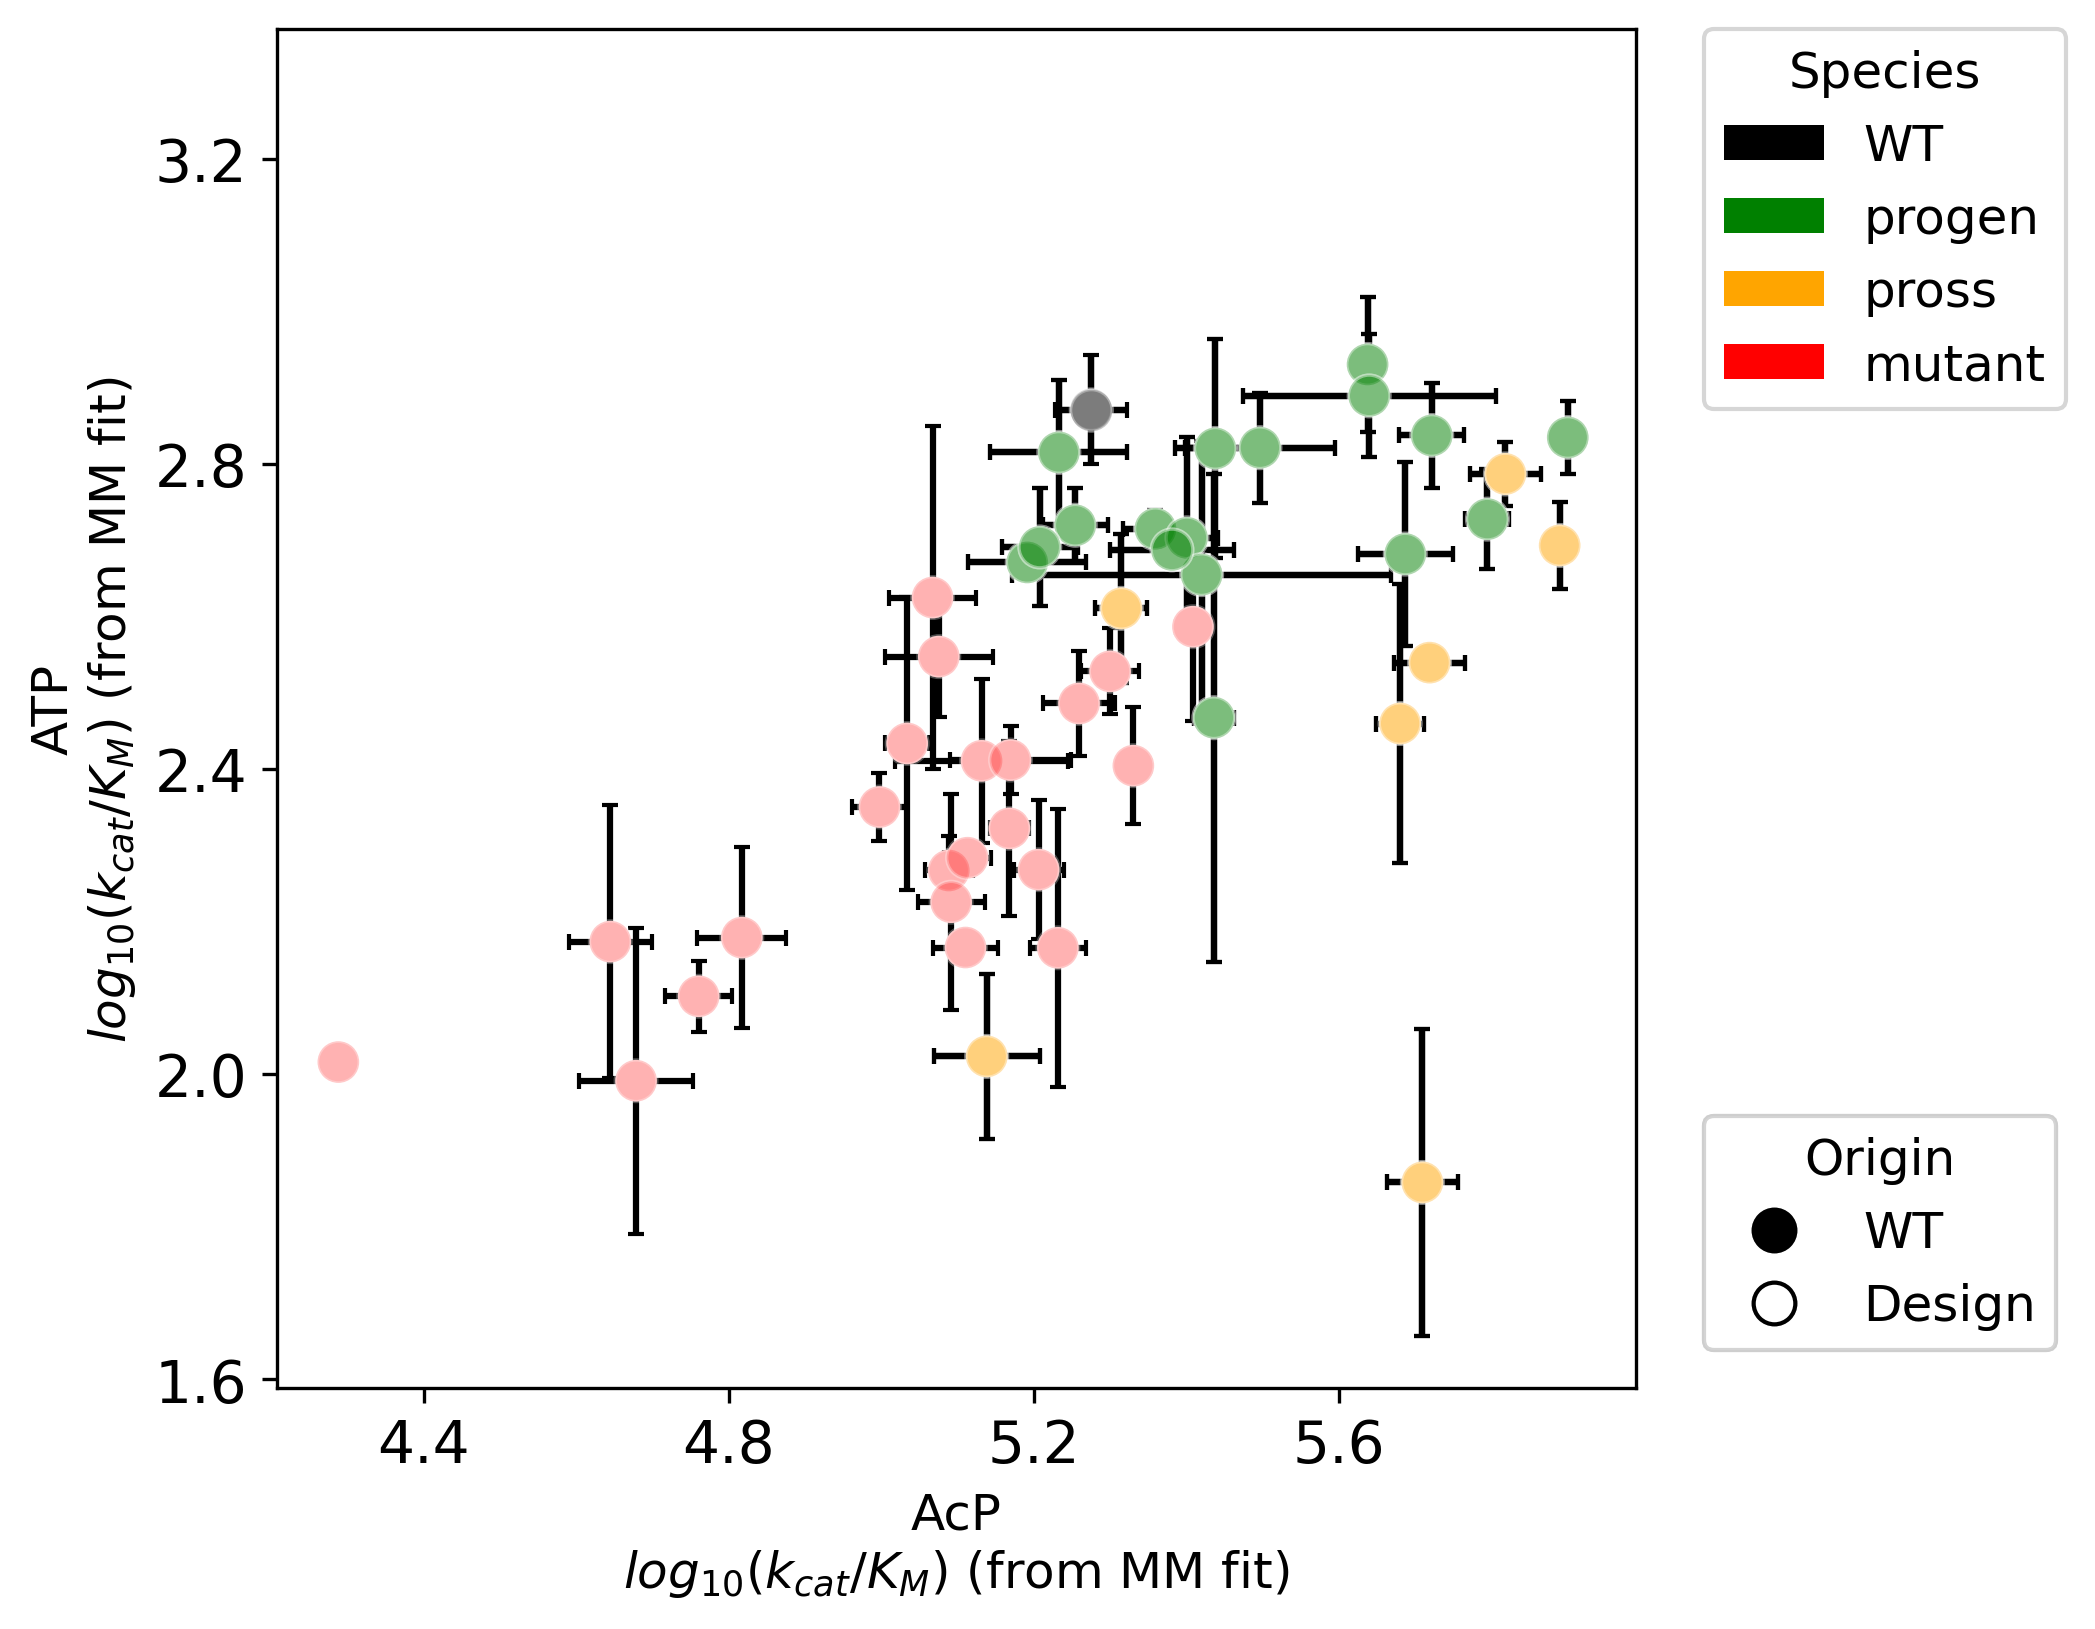

(4.206810606006897, 5.988599816552747)
(1.5882080780353325, 3.3699972885811826)


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


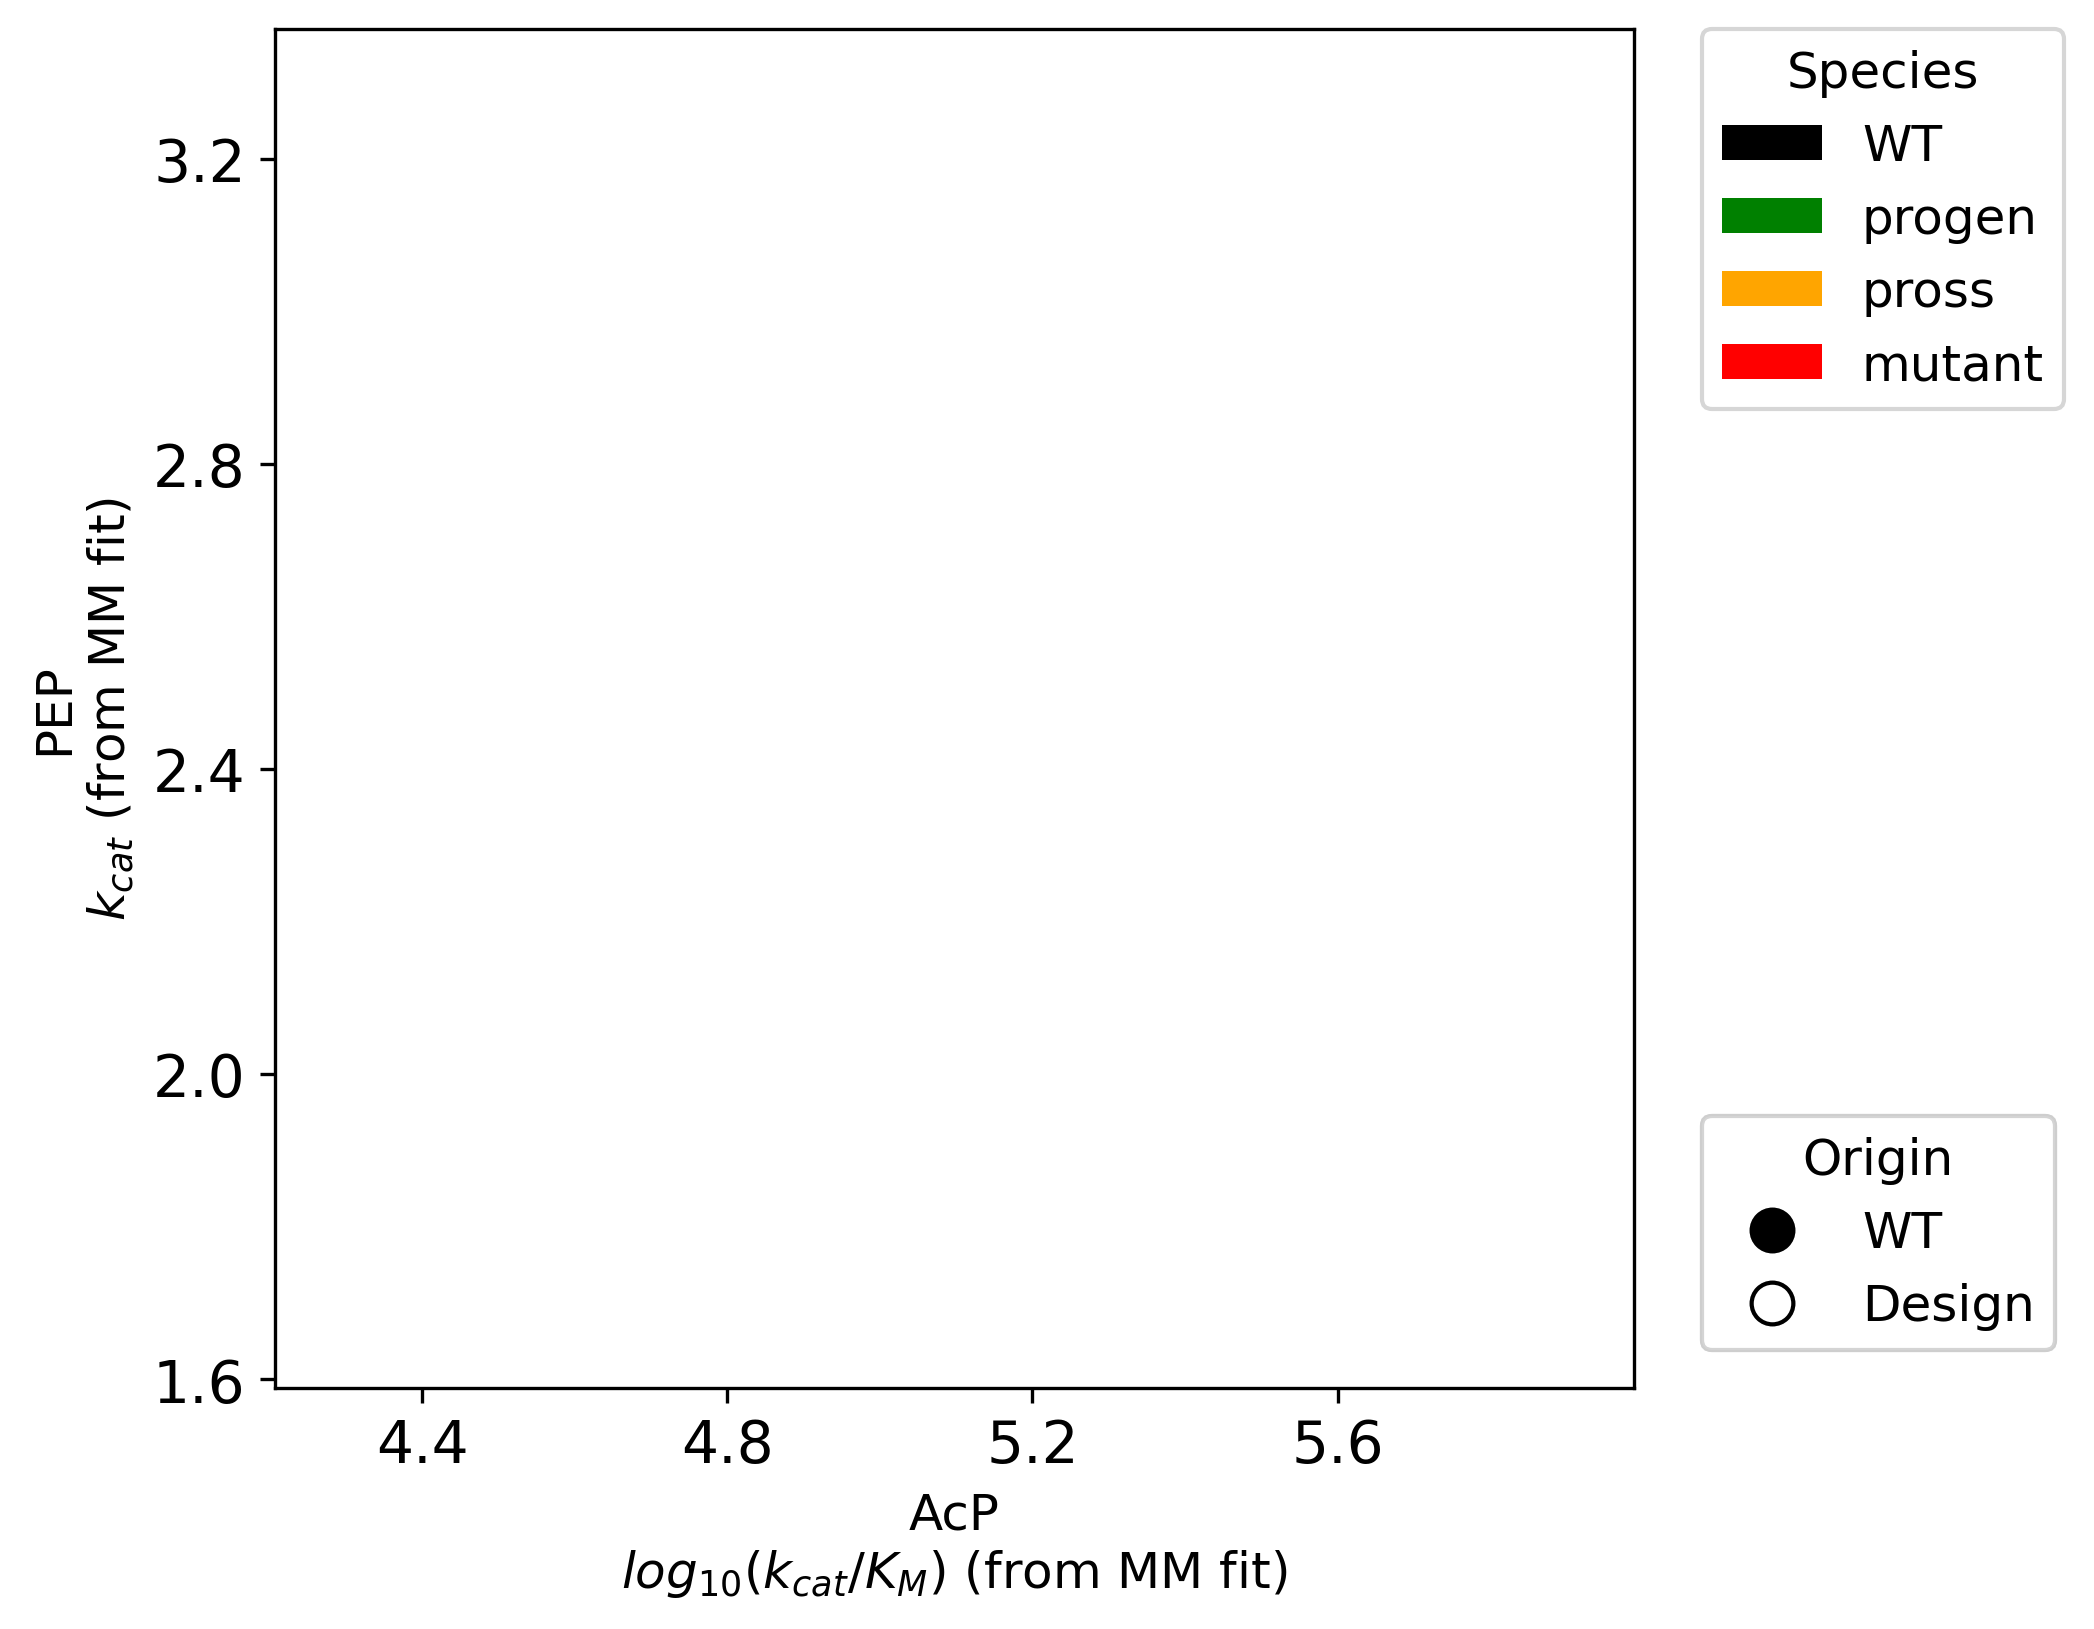

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(4.206810606006897, 5.988599816552747)
(1.5882080780353325, 3.3699972885811826)


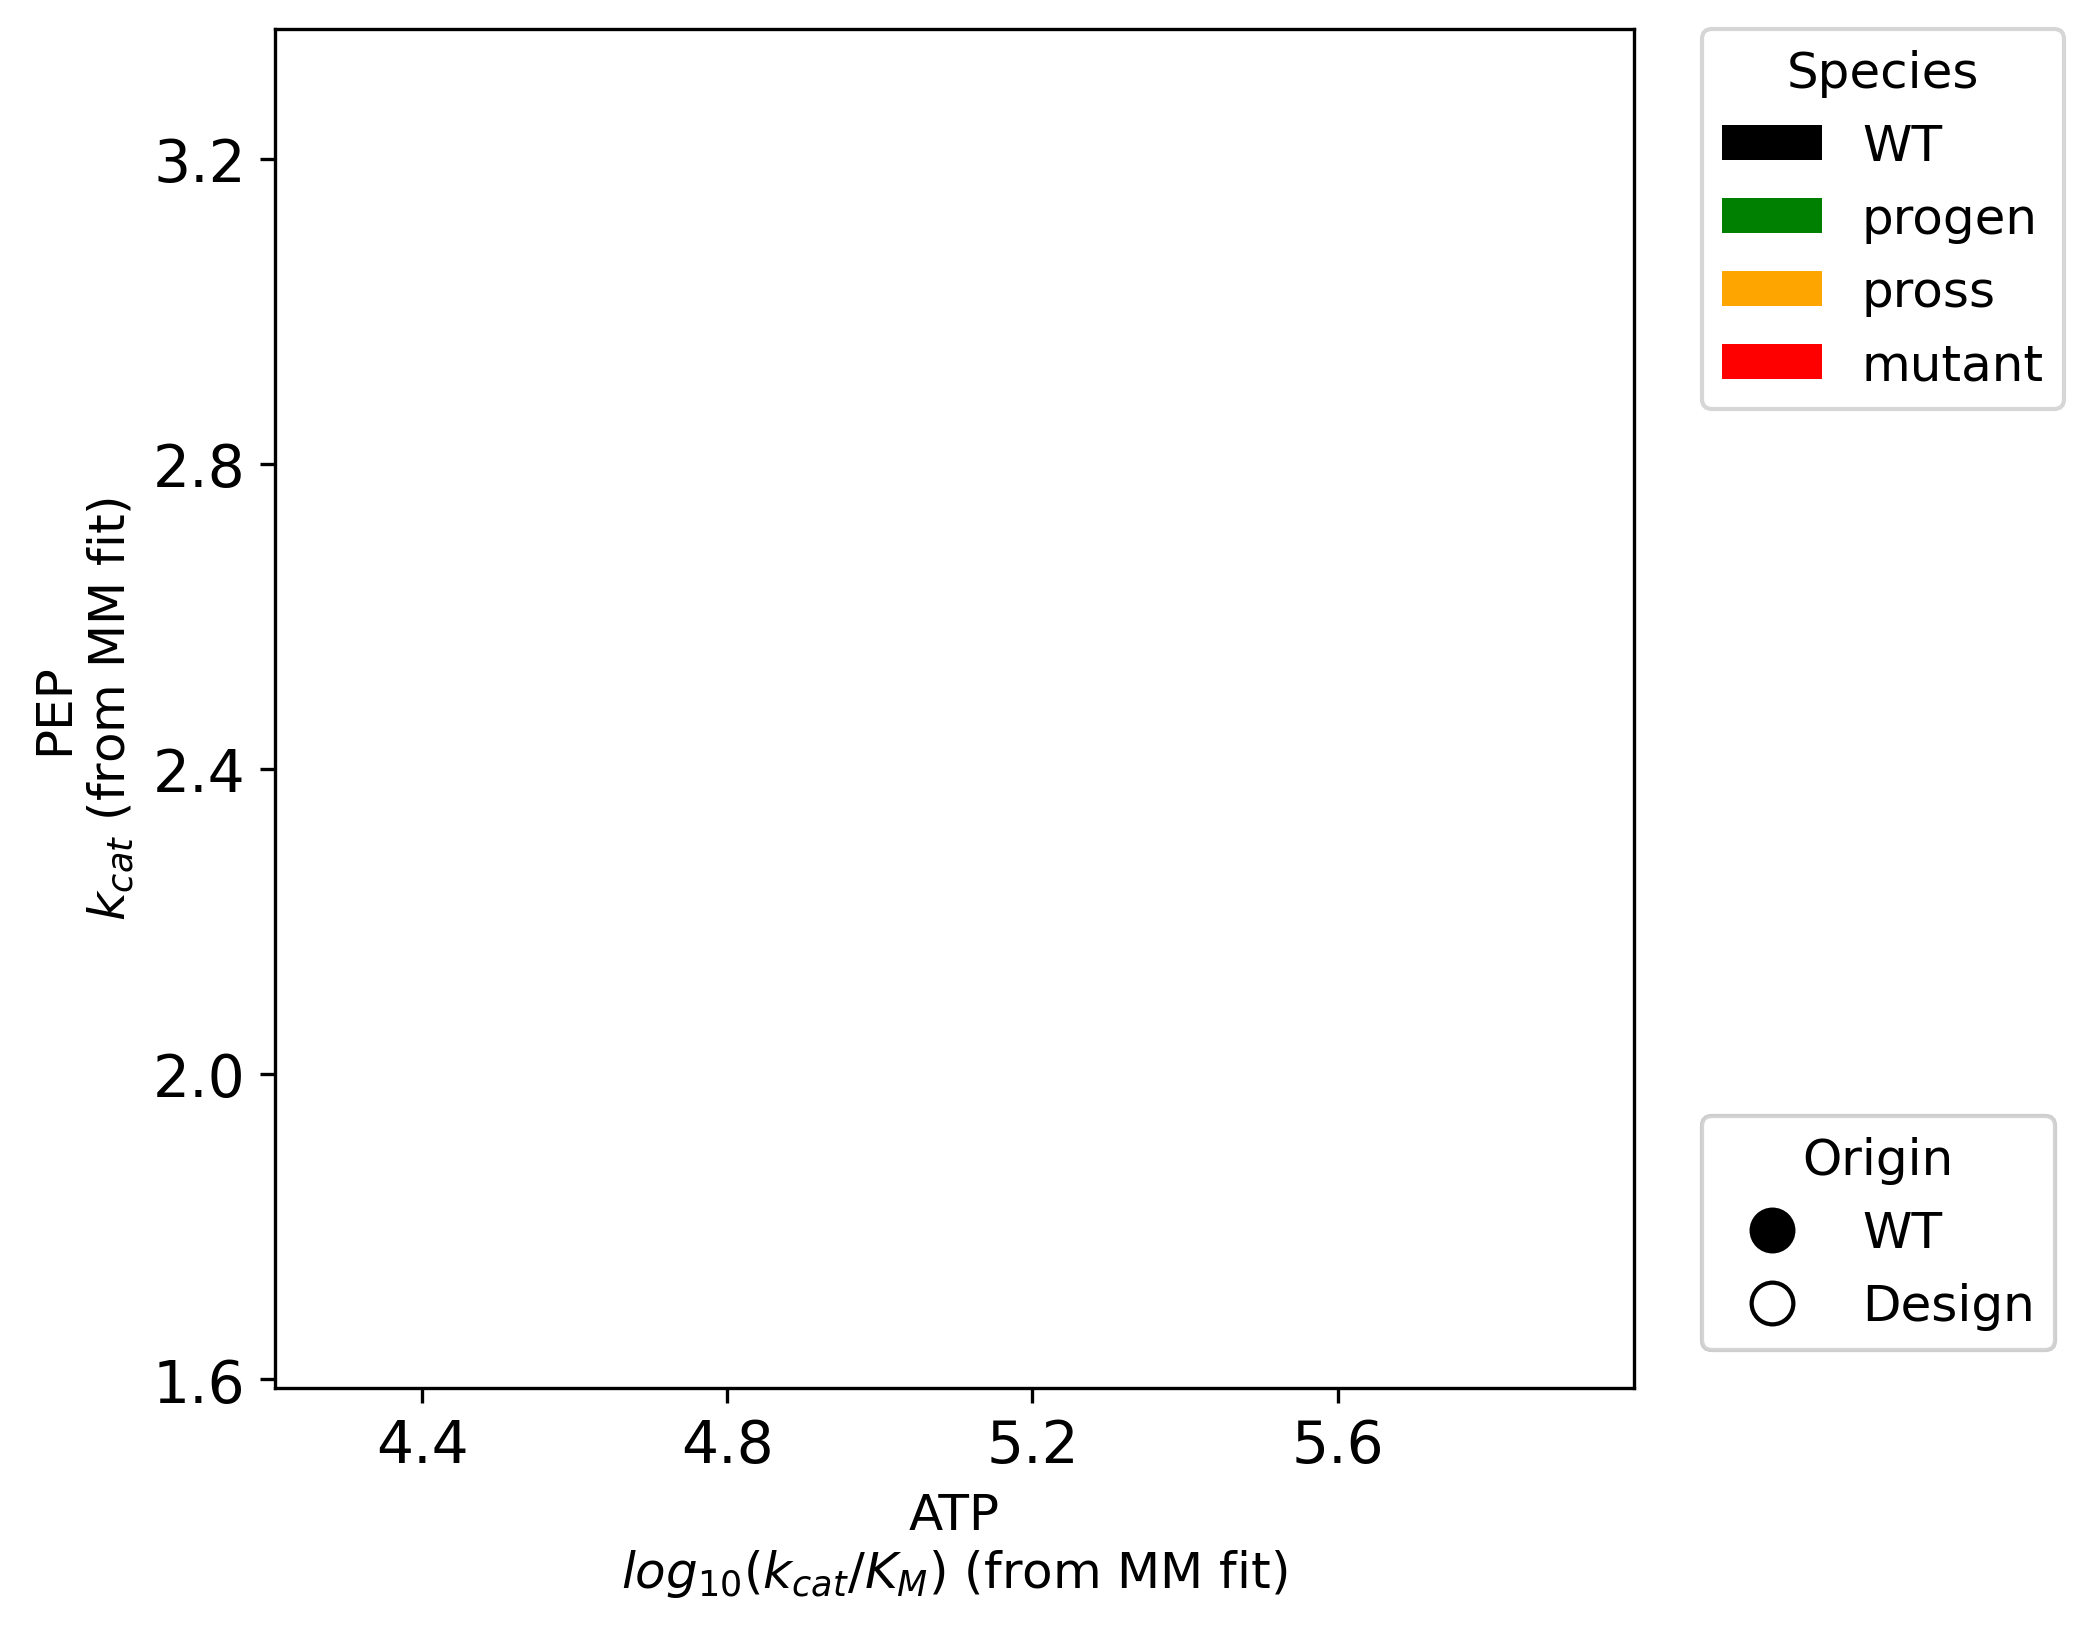

In [1139]:
# Create color dictionary for species
species_color_dict = {
    'hsapiens': 'cornflowerblue',
    'phorikoshii': 'red',
    'sbenthica': 'blue',
    'hypf': 'green',
    'Salinivibrio_costicola': 'grey',
    'Rhodopseudomonas_palustris': 'grey',
    'Providencia_rettgeri': 'grey',
    'Azospirillum_oryzae': 'grey',
    'Klebsiella_michiganensis': 'grey',
    'Rhizobium_mesoamericanum': 'grey',
    'Anaeromyxobacter_dehalogenans': 'grey',
    'Lactobacillus_pobuzihii': 'grey',
    'Methylocystis_rosea': 'grey',
    'Streptomyces_bikiniensis': 'grey',
    'Nonomuraea_jiangxiensis': 'grey',
}

origin_color_dict = {
    'WT': 'black',
    'progen': 'green',
    'pross': 'orange',
    'mutant': 'red',
}

# drop all species but main ones
keep_species = 'hsapiens'
# keep_species = 'phorikoshii'
# keep_species = 'sbenthica'
df_curr = df[df['species'] == keep_species]
species_color_dict = {k: v for k, v in species_color_dict.items() if k in keep_species}

# create a dictionary to rename kinetic param to something more readable
param_name_dict = {
    'exponential_kcat_over_km_list_0': '$log_{10}(k_{cat}/K_M)$ (from $k_{obs}$ fit of $[S]_0$)',
    'exponential_kcat_over_km_list_1': '$log_{10}(k_{cat}/K_M)$ (from $k_{obs}$ fit of $[S]_1$)',
    'exponential_kcat_over_km_list_2': '$log_{10}(k_{cat}/K_M)$ (from $k_{obs}$ fit of $[S]_2$)',
    'exponential_kcat_over_km_list_3': '$log_{10}(k_{cat}/K_M)$ (from $k_{obs}$ fit of $[S]_3$)',
    'kcat_over_KM_fit': '$log_{10}(k_{cat}/K_M)$ (from MM fit)',
    'kcat_fit': '$k_{cat}$ (from MM fit)',
}

# Assign grey to uncharacterized species
species_color_dict.update({species: '#d3d3d3' for species in df_curr['species'][df_curr['species'].str.contains('uncharacterized')].unique()})

# merge ensemble_ll data back into df
df_curr = pd.merge(df_curr, full_sequence_library[['name', 'ensemble_ll']], on='name', how='left')

# set value of ensemble ll based on name column in single_mutant_likelihoods
for index, row in df_curr.iterrows():
    name = row['name']
    if name in single_mutant_likelihoods['name'].values:
        df_curr.loc[index, 'ensemble_ll'] = single_mutant_likelihoods.loc[single_mutant_likelihoods['name'] == name, 'progen2-large'].values[0]

# correct origins
df_curr.loc[df_curr['name'].str.contains('pross'), 'origin'] = 'pross'
df_curr.loc[df_curr['name'].str.contains('lambda'), 'origin'] = 'progen'

# drop hsapeins2_wt and change C21S to WT
df_curr = df_curr[~df_curr['name'].str.contains('hsapiens2_wt')]
df_curr.loc[df_curr['name'].str.contains('C21S'), 'origin'] = 'WT'

# define function to plot each sequence activity in each substrate
def plot_substrates(data, model_type, substrate_1, substrate_2, colormap=None):

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(6,6), dpi=300)

    #### Plot the progen data using matplotlib scatter ####
    ## plot points above the limit
    WT_data = data[(data['origin'] == 'WT')]
    # model_data = data[(data['origin'] == model_type)]
    model_data = data

    if (colormap is None) or (colormap == 'species'):
        # plot progen sequences as lighter circles
        xdat = model_data[f'median_{substrate_1}'].to_numpy()
        ydat = model_data[f'median_{substrate_2}'].to_numpy()
        xerr = model_data[f'sem_{substrate_1}'].to_numpy()
        yerr = model_data[f'sem_{substrate_2}'].to_numpy()
        sns.scatterplot(data=model_data, x=f'median_{substrate_1}', y=f'median_{substrate_2}', hue='species', palette=species_color_dict, s=100, ax=ax, alpha=0.3, zorder=2)
        ax.scatter(x=xdat, y=ydat, color='white', s=100, edgecolor='none', zorder=1)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=2, zorder=0)

        # plot WT sequences as darker circles
        xdat = WT_data[f'median_{substrate_1}'].to_numpy()
        ydat = WT_data[f'median_{substrate_2}'].to_numpy()
        xerr = WT_data[f'sem_{substrate_1}'].to_numpy()
        yerr = WT_data[f'sem_{substrate_2}'].to_numpy()
        sns.scatterplot(data=WT_data, x=f'median_{substrate_1}', y=f'median_{substrate_2}', hue='species', palette=species_color_dict, s=100, ax=ax)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=0, zorder=0)

         #### Legends ####
        # add legend 1 with markers for species
        import matplotlib.lines as mlines
        legend1_elements = [mpatches.Patch(facecolor=color, label=species) for species, color in species_color_dict.items()]
        legend1 = plt.legend(handles=legend1_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Species')
        plt.gca().add_artist(legend1)

        # add legend2 with markers for limit
        legend2_elements = [
                mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, markerfacecolor='black', markeredgecolor='black', label='WT'),
                mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, markerfacecolor='white', markeredgecolor='black', label=model_type),
        ]
        legend2 = plt.legend(handles=legend2_elements, bbox_to_anchor=(1.05, 0.2), loc=2, borderaxespad=0., title='Origin')
        plt.gca().add_artist(legend2)

    elif colormap == 'ensemble_ll':
        from matplotlib.colors import Normalize

        display(model_data)

        # coerce ensemble_ll to be float
        model_data['ensemble_ll'] = model_data['ensemble_ll'].astype(float)

        # plot same scatter but now colormap ensemble log likelihood
        xdat = model_data[f'median_{substrate_1}'].to_numpy()
        ydat = model_data[f'median_{substrate_2}'].to_numpy()
        xerr = model_data[f'sem_{substrate_1}'].to_numpy()
        yerr = model_data[f'sem_{substrate_2}'].to_numpy()

        # create custom colormap based on viridis
        norm = Normalize(vmin=model_data['ensemble_ll'].min(), vmax=model_data['ensemble_ll'].max())
        scatter = ax.scatter(x=model_data[f'median_{substrate_1}'], y=model_data[f'median_{substrate_2}'], 
                             c=model_data['ensemble_ll'], cmap='viridis', s=50, zorder=2, norm=norm)
        ax.scatter(x=xdat, y=ydat, color='white', s=50, edgecolor='none', zorder=1)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=0, zorder=0)

        # add colorbar
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1, shrink=0.5, aspect=7)
        cbar.set_label('Ensemble Log Likelihood')

        # plot WT
        xdat = WT_data[f'median_{substrate_1}'].to_numpy()
        ydat = WT_data[f'median_{substrate_2}'].to_numpy()
        xerr = WT_data[f'sem_{substrate_1}'].to_numpy()
        yerr = WT_data[f'sem_{substrate_2}'].to_numpy()
        sns.scatterplot(data=WT_data, x=f'median_{substrate_1}', y=f'median_{substrate_2}', hue='ensemble_ll', palette='viridis', s=50, ax=ax)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=0, zorder=0)

        # remove legend
        plt.legend().remove()
    
    elif colormap == 'origin':
        # remove 'mutant' from origin
        # model_data = model_data[model_data['origin'] != 'mutant']

        # plot progen sequences as lighter circles
        xdat = model_data[f'median_{substrate_1}'].to_numpy()
        ydat = model_data[f'median_{substrate_2}'].to_numpy()
        xerr = model_data[f'sem_{substrate_1}'].to_numpy()
        yerr = model_data[f'sem_{substrate_2}'].to_numpy()
        sns.scatterplot(data=model_data, x=f'median_{substrate_1}', y=f'median_{substrate_2}', hue='origin', palette=origin_color_dict, s=100, ax=ax, alpha=0.3, zorder=2)
        ax.scatter(x=xdat, y=ydat, color='white', s=100, edgecolor='none', zorder=1)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=2, zorder=0)

        # plot WT sequences as darker circles
        xdat = WT_data[f'median_{substrate_1}'].to_numpy()
        ydat = WT_data[f'median_{substrate_2}'].to_numpy()
        xerr = WT_data[f'sem_{substrate_1}'].to_numpy()
        yerr = WT_data[f'sem_{substrate_2}'].to_numpy()
        sns.scatterplot(data=WT_data, x=f'median_{substrate_1}', y=f'median_{substrate_2}', hue='origin', palette=origin_color_dict, s=100, ax=ax, alpha=0.3, zorder=2)
        ax.errorbar(x=xdat, y=ydat, xerr=xerr, yerr=yerr, fmt='o', color='k', ls='none', capsize=0, zorder=0)

         #### Legends ####
        # add legend 1 with markers for species
        import matplotlib.lines as mlines
        legend1_elements = [mpatches.Patch(facecolor=color, label=origin) for origin, color in origin_color_dict.items()]
        legend1 = plt.legend(handles=legend1_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Species')
        plt.gca().add_artist(legend1)

        # add legend2 with markers for limit
        legend2_elements = [
                mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, markerfacecolor='black', markeredgecolor='black', label='WT'),
                mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, markerfacecolor='white', markeredgecolor='black', label='Design'),
        ]
        legend2 = plt.legend(handles=legend2_elements, bbox_to_anchor=(1.05, 0.2), loc=2, borderaxespad=0., title='Origin')
        plt.gca().add_artist(legend2)

    #### Change axis labels ####
    # get param name from param_name_dict
    ax.set_xlabel(f'{substrate_1}\n{param_name_dict[params_by_substrate[substrate_1]]}')
    ax.set_ylabel(f'{substrate_2}\n{param_name_dict[params_by_substrate[substrate_2]]}')

    # # set axis ranges to be the same and make axes square
    plt.axis('square')
    plt.gca().set_aspect('equal', adjustable='box', anchor='C')

    # 
    ax.set_xlim(4.206810606006897, 5.988599816552747)
    ax.set_ylim(1.5882080780353325, 3.3699972885811826)

    # # use adjust text to label the WT
    # if len(WT_data) > 0:
    #     texts = []
    #     for i, txt in enumerate(WT_data['name']):
    #         if keep_species == 'hsapiens':
    #             texts.append(ax.text(WT_data[f'median_{substrate_1}'].iloc[i], WT_data[f'median_{substrate_2}'].iloc[i], 'Human WT (C21S)', fontsize=8))
    #         elif keep_species == 'phorikoshii':
    #             texts.append(ax.text(WT_data[f'median_{substrate_1}'].iloc[i], WT_data[f'median_{substrate_2}'].iloc[i], 'P. horikoshii WT', fontsize=8))
        
    #     # # also add labels for other sequences
    #     # for i, txt in enumerate(model_data['name']):
    #     #     texts.append(ax.text(model_data[f'median_{substrate_1}'].iloc[i], model_data[f'median_{substrate_2}'].iloc[i], txt, fontsize=8))

            
    #     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'),
    #                 force_text=(1.5, 3), force_points=(1.5, 3),
    #                 force_objects=(1.5, 3), expand_points=(1.5, 3))

    # increase font size of ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # # add title
    # plt.title(f'Model: {model_type}')

    # use same number of ticks on x and y axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    # Set figure facecolor to white
    fig.patch.set_facecolor('white')

    # print plot limits
    print(ax.get_xlim())
    print(ax.get_ylim())

    plt.show()

plot_substrates(df_curr, 'progen', 'AcP', 'ATP', colormap='origin')
plot_substrates(df_curr, 'progen', 'AcP', 'PEP', colormap='origin')
plot_substrates(df_curr, 'progen', 'ATP', 'PEP', colormap='origin')

# get plot limits

# Plot grouped barplot of kcat/KM for each substrate

In [1013]:
# first, filter df for WTs
df_WT = all_turnover_dfs_concat[all_turnover_dfs_concat['origin'] == 'WT']

# remove duplicate chambers per experiment
df_WT = df_WT.drop_duplicates(subset=['experiment', 'Indices'])

# filter by local bg ratio > 2 and enzyme conc > 5 nM
df_WT = df_WT[df_WT['local_bg_ratio'] > 2]
df_WT = df_WT[df_WT['EnzymeConc'] > 5]
df_WT = df_WT[df_WT['kcat_over_KM_fit'] > 0]

# remove limits
df_WT = df_WT[df_WT['limit'] == False]

ValueError: min() arg is an empty sequence

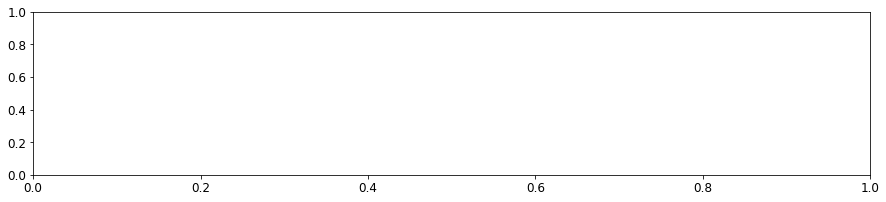

In [1014]:
# sort hsapiens, phorikoshii, sbenthica, hypf to top of df
df_WT = df_WT.sort_values(by=['species'], ascending=False)

# in species name, abbreviate first name to first initial
for index, row in df_WT.iterrows():
    if '_' in row['species']:
        df_WT.loc[index, 'species'] = row['species'].split('_')[0][0] + '. ' + row['species'].split('_')[1]

# define ax with size 5, 3
fig, ax = plt.subplots(figsize=(15, 3))

# Assuming df_WT is your DataFrame
# First, create the catplot without error bars
g = sns.barplot(data=df_WT, x='species', 
                # y='exponential_kcat_over_km_list_0',
                y='kcat_over_KM_fit',
                hue='substrate', ax=ax, ci='sd',
                palette={'AcP': 'orange', 'ATP': 'blue', 'PEP': 'green'})

# Adjust plot appearance
ax.set_xlabel('')
ax.set_ylabel('$log_{10}(k_{cat}/K_M)$ (M^-1 s^-1)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Substrate')
ax.set_title('WT AcyPs')
for item in ax.get_xticklabels():
    item.set_rotation(25)

# Display the plot
plt.show()

# kcat/KM vs log-likelihood

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_77261/2100142310.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['limit'] = df['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/AcP_ELL_vs_kcatKM.svg'

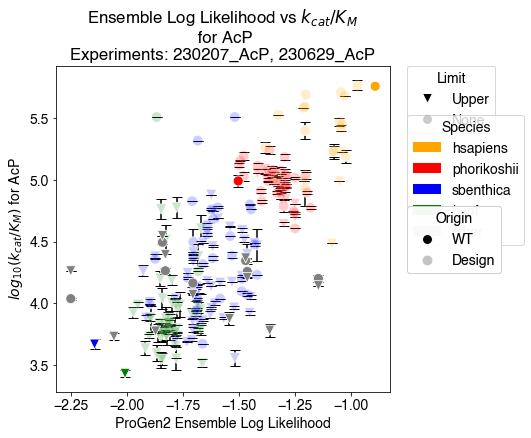

In [94]:
# filter for substrate
substrate = 'AcP'

# select experiments from all_turnover_dfs_concat
expt_selections = [
                    '230207_AcP',
                    # '230410_AcP',
                    # '230419_AcP',
                    # '230612_AcP',
                    # '230622_AcP',
                    '230629_AcP',

                    '230419_ATP',
                    '230612_ATP',
                    # '230622_ATP',

                    '230419_PEP',
                    '230612_PEP'
                    ]
df = all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'].isin(expt_selections)]

# add limit column to dataframe
df['limit'] = df['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")

# filter for local bg ratio > 2, enzyme conc > 5 nM, and kcat/KM > 1
# df = df[df['local_bg_ratio'] > 2]
df = df[df['EnzymeConc'] > 5]
df = df[df['kcat_over_KM_fit_R2'] > 0.999]
df = df[df['substrate'] == substrate]

# get medians and SEM for each MutantID and drop duplicates
df = df.groupby(['MutantID', 'limit']).agg({'kcat_over_KM_fit': ['median', 'sem']}).reset_index()
df.columns = ['MutantID', 'limit', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_sem']

# merge ensemble_ll data with df from above
df = pd.merge(df, all_turnover_dfs_concat[['MutantID', 'ensemble_ll', 'species', 'origin']].drop_duplicates(), on='MutantID', how='left').drop_duplicates()

# create color dictionary for species
species_color_dict = {
    'hsapiens': 'orange',
    'phorikoshii': 'red',
    'sbenthica': 'blue',
    'hypf': 'green',
    'other': 'grey'
}

# set marker dictionary for style
marker_dict = {
    'None': 'o',
    'Upper': 'v'
}

# replace species other than those in species_color_dict with 'other'
df.loc[~df['species'].isin(species_color_dict.keys()), 'species'] = 'other'

# plot scatter of kcat/KM vs ensemble_ll, including errors
plt.figure(figsize=(6, 6))
plt.errorbar(x=df['ensemble_ll'], y=df['kcat_over_KM_fit_median'], yerr=df['kcat_over_KM_fit_sem'], fmt='none', ecolor='black', capsize=5, zorder=1)
sns.scatterplot(data=df[df['origin'] == 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, zorder=3, style='limit', markers=marker_dict, legend=False)
sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, color='white', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False)
sns.scatterplot(data=df[df['origin'] != 'WT'], x='ensemble_ll', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, alpha=0.2, zorder=2, style='limit', markers=marker_dict, legend=False)


# add legend1 with markers for limit
legend1_elements = [
                    Line2D([0], [0], marker='v', color='w', label='Upper', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='None', markerfacecolor='black', markersize=10),
                    ]
legend1 = plt.legend(handles=legend1_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Limit')
plt.gca().add_artist(legend1)

# add legend2 with colors for species
legend2_elements = [Patch(facecolor=color, label=species) for species, color in species_color_dict.items()]
legend2 = plt.legend(handles=legend2_elements, bbox_to_anchor=(1.05, 0.85), loc=2, borderaxespad=0., title='Species')
plt.gca().add_artist(legend2)

# add legend3 with shades for origin
legend3_elements = [
                    Line2D([0], [0], marker='o', color='w', label='WT', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Design', markerfacecolor='black', alpha=0.2, markersize=10),
                    ]
legend3 = plt.legend(handles=legend3_elements, bbox_to_anchor=(1.05, 0.57), loc=2, borderaxespad=0., title='Origin')
plt.gca().add_artist(legend3)


# set axis labels
plt.xlabel('ProGen2 Ensemble Log Likelihood')
plt.ylabel('$log_{10}(k_{cat}/K_M)$ for %s' % substrate)
plt.title('Ensemble Log Likelihood vs $k_{cat}/K_M$ \n for %s' % substrate + '\nExperiments: %s' % ', '.join([x for x in expt_selections if substrate in x]))

# make borders black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    
# set facecolor to white
plt.gcf().set_facecolor('white')

# save figure to file
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.svg', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/Model_outcomes/ELL_performance/' + substrate + '_ELL_vs_kcatKM.png', dpi=300, bbox_inches='tight')

## kcat/KM vs mutational distance

In [95]:
all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'].isin(expt_selections)].head(2)

,Unnamed: 0,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,kcat_over_KM_fit_R2,exclude_concs,local_bg_ratio,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM,initial_rate,initial_rate_intercept,two_point_fit,rate_fit_regime,GlobalExperimentIndex,Experiment,name,mutation,species,origin,sampling_replicate,lambda,seq_id,experiment,exponential_A_list,exponential_kobs_list,exponential_y0_list,exponential_R2_list,exponential_kcat_over_km_list,MM_points_to_fit,local_bg_substrate_conc,kobs_kcat_over_KM,num_points_fit_vo_list,num_points_fit_vo,exponential_A,exponential_kobs,exponential_y0,exponential_R2,kobs_kcat_KM,local_bg_substrate_conc_x,local_bg_substrate_conc_y,local_bg_substrate_conc_x.1,local_bg_substrate_conc_y.1,local_bg_substrate_conc_x.2,local_bg_substrate_conc_y.2,local_bg_substrate_conc_x.3,local_bg_substrate_conc_y.3,max_exp_R2,n_mutations,ensemble_ll,predicted_tm,protein_sequence,protein_sequence_wt,exponential_kcat_over_km_list_0,exponential_kcat_over_km_list_1,exponential_kcat_over_km_list_2,exponential_kcat_over_km_list_4,exponential_kcat_over_km_list_3,limit
7168,0,1,1,"01,01",phorikoshii_pross_2,AcP,0.238887,False,"[10, 25, 50, 75, 100]","[0.0006411111111111196, 0.0019233333333333403,...",49.921765,0.005383,22.533433,5.654537,1.0,"[50, 75, 100]",0.75,10.0,131388,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[5780, 5814, 5840, 5874, 5885, 5943, 5950, 597...","[0, 1, 6, 15, 30, 75]","[4475, 5019, 8235, 12948, 16133, 16120]",[7.09382363e+02 1.60208119e+00 1.84577071e+01 ...,"[2.105666666666668, 2.1537500000000023, 2.2018...",0.000641,2.105667,False,1.0,230207_S7_d2_AcP,AcyP_SFL_203,phorikoshii_pross_2,NaN,phorikoshii,pross,2,NaN,NaN,230207_AcP,"[8.667065241338358, 9.366244099012269, 20.7799...","[6.331175629528516e-05, 0.00018150550480968517...","[2.113533781774074, 5.907870672948526, 10.6133...","[0.9989860345914776, 0.9993753386982855, 0.999...","[265027.749584489, 759795.6255162333, 659339.2...",2.0,25.0,265027.749584,"[3, 3, 2, 2, 2]",3.0,8.667065,0.000063,2.113534,0.998986,265027.749584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-1.493722,81.223185,MAIVRAHLFIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,MAIVRAHLKIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,NaN,NaN,NaN,NaN,NaN,True
7169,1,1,1,"01,01",phorikoshii_pross_2,AcP,0.238887,False,"[10, 25, 50, 75, 100]","[0.0006411111111111196, 0.0019233333333333403,...",49.921765,0.005383,22.533433,5.654537,1.0,"[50, 75, 100]",0.75,25.0,131388,"[0, 75, 150, 227, 304, 381, 458, 536, 613, 690...","[8159, 8244, 8335, 8398, 8468, 8546, 8627, 868...","[0, 1, 6, 15, 30, 75]","[4475, 5019, 8235, 12948, 16133, 16120]",[7.09382363e+02 1.60208119e+00 1.84577071e+01 ...,"[5.904250000000001, 6.048500000000001, 6.19275...",0.001923,5.904250,False,1.0,230207_S7_d2_AcP,AcyP_SFL_203,phorikoshii_pross_2,NaN,phorikoshii,pross,2,NaN,NaN,230207_AcP,"[8.667065241338358, 9.366244099012269, 20.7799...","[6.331175629528516e-05, 0.00018150550480968517...","[2.113533781774074, 5.907870672948526, 10.6133...","[0.9989860345914776, 0.9993753386982855, 0.999...","[265027.749584489, 759795.6255162333, 659339.2...",2.0,25.0,265027.749584,"[3, 3, 2, 2, 2]",3.0,9.366244,0.000182,5.907871,0.999375,759795.625516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-1.493722,81.223185,MAIVRAHLFIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,MAIVRAHLKIYGRVQGVGFRWSMQREARKLGVNGWVRNLPDGSVEA...,NaN,NaN,NaN,NaN,NaN,True


/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_77261/1927712988.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(all_turnover_dfs_concat[(all_turnover_dfs_concat['MutantID'] == 'hsapiens2_wt') & (all_turnover_dfs_concat['experiment'] == '230629_AcP')])


FileNotFoundError: [Errno 2] No such file or directory: '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/Mutational_distance_vs_kcatKM/AcP_mutational_distance_vs_kcatKM.svg'

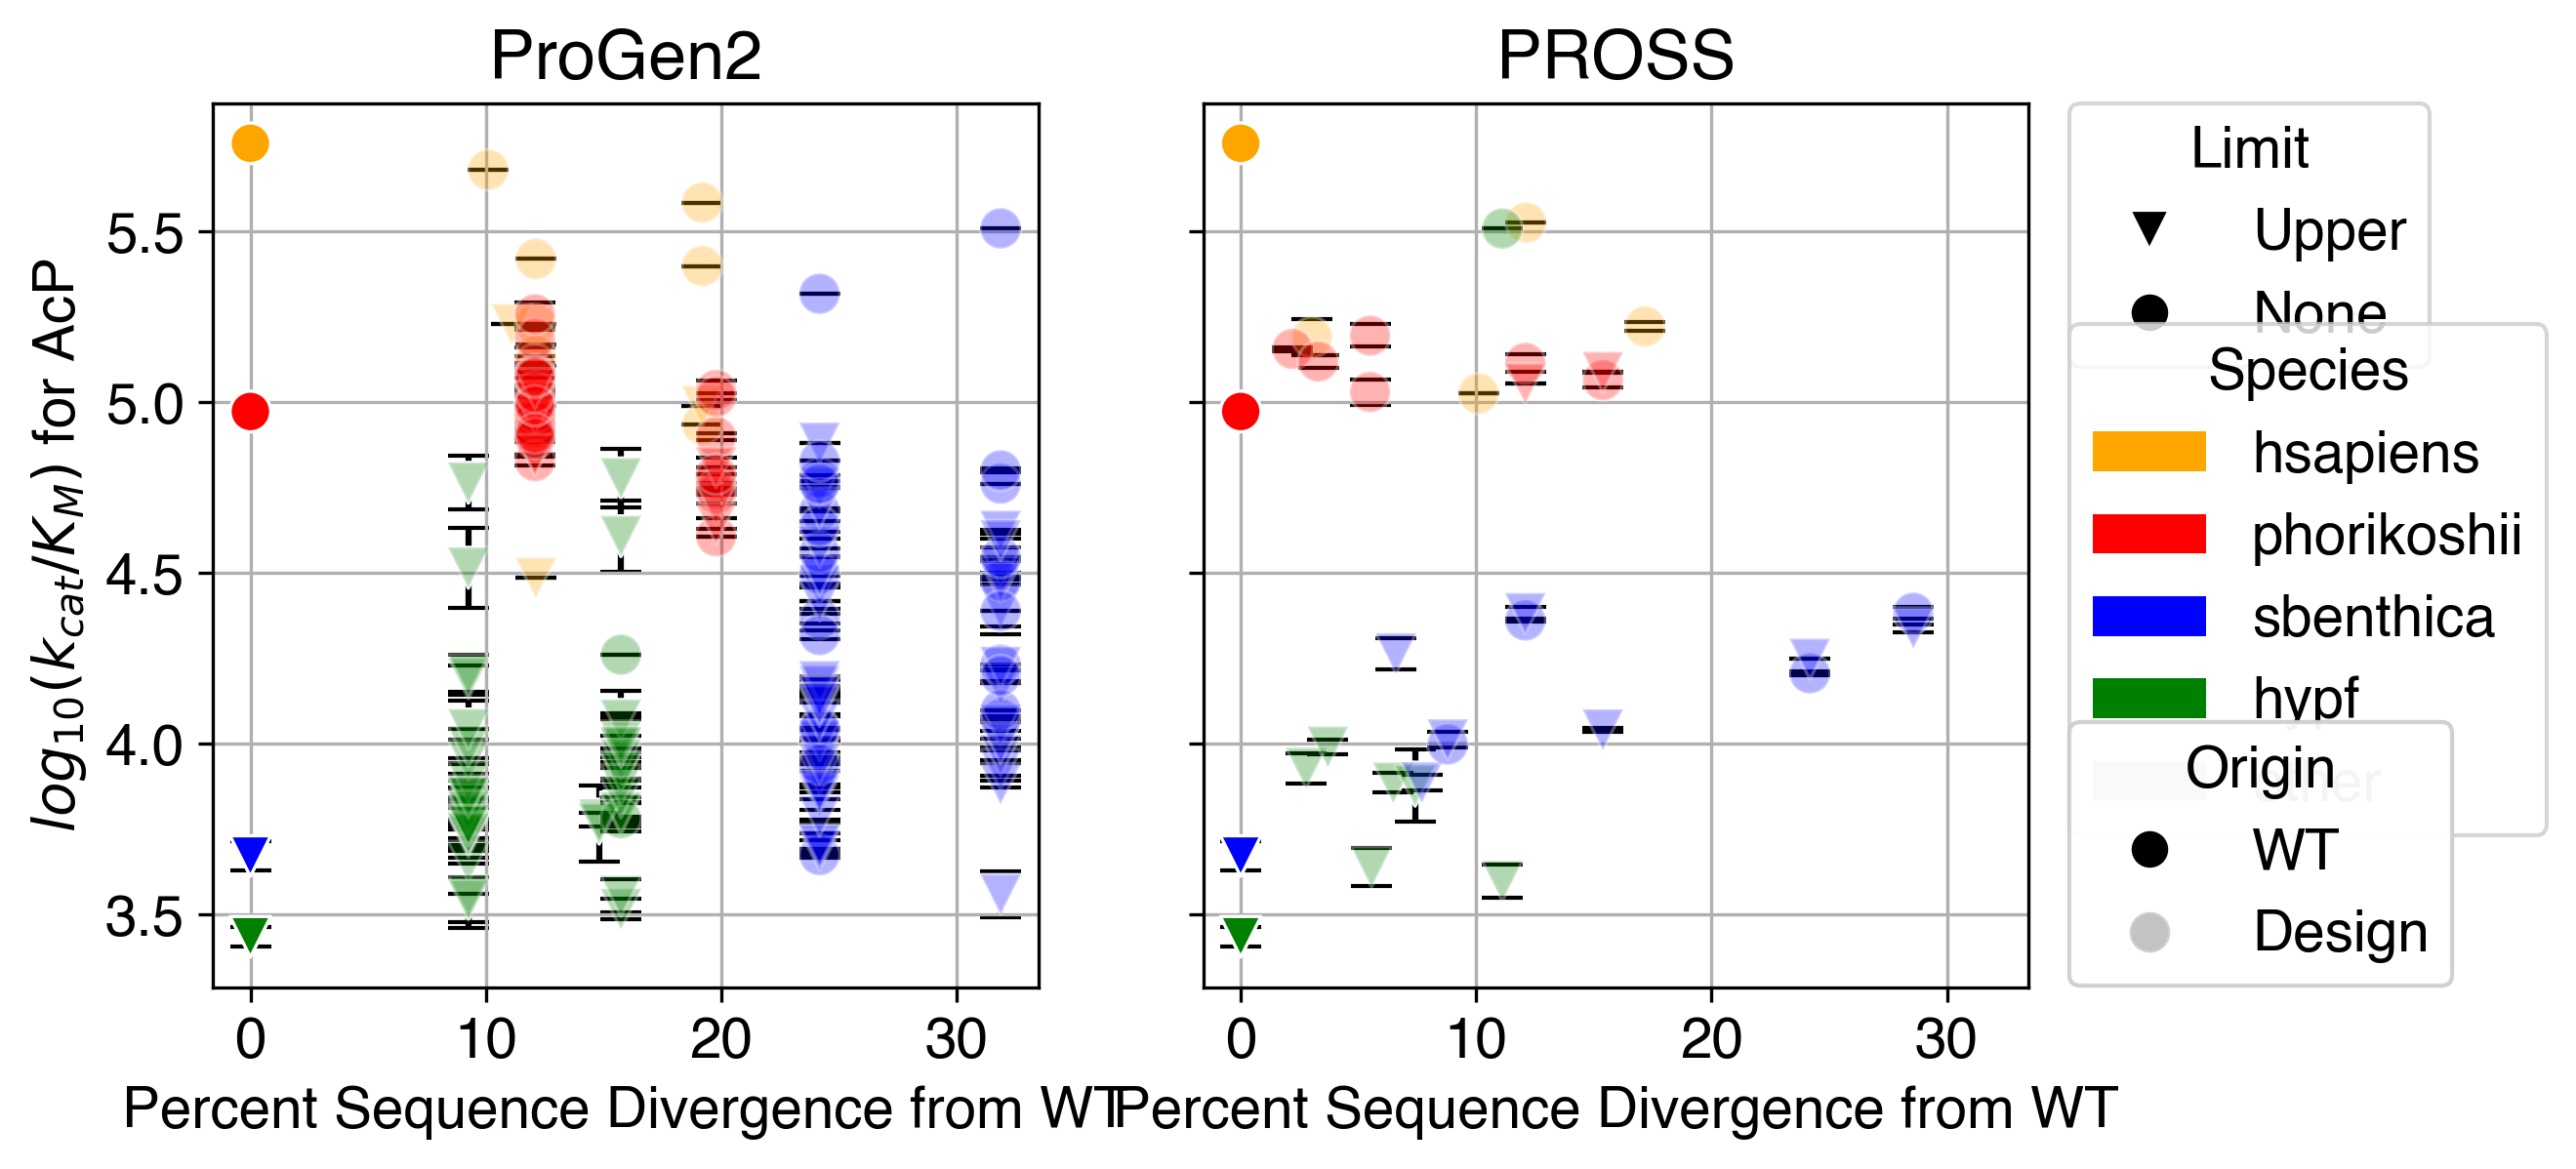

In [96]:
# filter for substrate
substrate = 'AcP'

# select experiments from all_turnover_dfs_concat
expt_selections = [
                    '230207_AcP',
                    # '230629_AcP',
                    # '230410_AcP',

                    ]
df = all_turnover_dfs_concat[all_turnover_dfs_concat['experiment'].isin(expt_selections)]

# add human WT measurements from 230629_AcP
df = df.append(all_turnover_dfs_concat[(all_turnover_dfs_concat['MutantID'] == 'hsapiens2_wt') & (all_turnover_dfs_concat['experiment'] == '230629_AcP')])

# add limit column to dataframe
df['limit'] = df['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")

# add mutational distance column
for index, row in df.iterrows():
    # get WT sequence and mutant sequence
    wt_seq = row['protein_sequence_wt']
    mut_seq = row['protein_sequence']
    
    # calculate mutational distance
    if type(wt_seq) == str and type(mut_seq) == str:
        df.loc[index, 'mutational_distance'] = 100 * sum(1 for a, b in zip(wt_seq, mut_seq) if a != b)/len(wt_seq)

# remove species other than hsapiens, phorikoshii, sbenthica, and hypf
df = df[df['species'].isin(['hsapiens', 'phorikoshii', 'sbenthica', 'hypf'])]

# filter for enzyme conc > 5 nM, and kcat/KM > 1
df = df[df['EnzymeConc'] > 5]
df = df[df['kcat_over_KM_fit_R2'] > 0.99]
df = df[df['substrate'] == substrate]

# get medians and SEM for each MutantID and drop duplicates
df = df.groupby(['MutantID', 'limit', 'mutational_distance']).agg({'kcat_over_KM_fit': ['median', 'sem']}).reset_index()
df.columns = ['MutantID', 'limit', 'mutational_distance', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_sem']

# merge ensemble_ll data with df from above
df = pd.merge(df, all_turnover_dfs_concat[['MutantID', 'ensemble_ll', 'species', 'origin']].drop_duplicates(), on='MutantID', how='left').drop_duplicates()

# create color dictionary for species
species_color_dict = {
    'hsapiens': 'orange',
    'phorikoshii': 'red',
    'sbenthica': 'blue',
    'hypf': 'green',
    'other': 'grey'
}

# set marker dictionary for style
marker_dict = {
    'None': 'o',
    'Upper': 'v'
}

# plot 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True, dpi=300)

axs[0].errorbar(x=df[(df['origin'] == 'progen') | (df['origin'] == 'WT')]['mutational_distance'], y=df[(df['origin'] == 'progen') | (df['origin'] == 'WT')]['kcat_over_KM_fit_median'], yerr=df[(df['origin'] == 'progen') | (df['origin'] == 'WT')]['kcat_over_KM_fit_sem'], fmt='none', ecolor='black', capsize=5, zorder=1)
sns.scatterplot(data=df[df['origin'] == 'WT'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, zorder=3, style='limit', markers=marker_dict, legend=False, ax=axs[0])
sns.scatterplot(data=df[df['origin'] == 'progen'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, color='white', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False, ax=axs[0])
sns.scatterplot(data=df[df['origin'] == 'progen'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, alpha=0.3, zorder=2, style='limit', markers=marker_dict, legend=False, ax=axs[0])
axs[0].set_title('ProGen2')
axs[0].set_ylabel('$log_{10}(k_{cat}/K_M)$ for %s' % substrate)
axs[0].set_xlabel('Percent Sequence Divergence from WT')

axs[1].errorbar(x=df[(df['origin'] == 'pross') | (df['origin'] == 'WT')]['mutational_distance'], y=df[(df['origin'] == 'pross') | (df['origin'] == 'WT')]['kcat_over_KM_fit_median'], yerr=df[(df['origin'] == 'pross') | (df['origin'] == 'WT')]['kcat_over_KM_fit_sem'], fmt='none', ecolor='black', capsize=5, zorder=1)
sns.scatterplot(data=df[df['origin'] == 'WT'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, zorder=3, style='limit', markers=marker_dict, legend=False, ax=axs[1])
sns.scatterplot(data=df[df['origin'] == 'pross'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, color='white', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False, ax=axs[1])
sns.scatterplot(data=df[df['origin'] == 'pross'], x='mutational_distance', y='kcat_over_KM_fit_median', s=100, hue='species', palette=species_color_dict, alpha=0.3, zorder=2, style='limit', markers=marker_dict, legend=False, ax=axs[1])
axs[1].set_title('PROSS')
axs[1].set_xlabel('Percent Sequence Divergence from WT')

# add gridlines
axs[0].grid()
axs[1].grid()

# add black border on all sides of plots
for ax in axs:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

# add legend1 with markers for limit
legend1_elements = [
                    Line2D([0], [0], marker='v', color='w', label='Upper', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='None', markerfacecolor='black', markersize=10),
                    ]
legend1 = plt.legend(handles=legend1_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Limit')
plt.gca().add_artist(legend1)

# add legend2 with colors for species
legend2_elements = [Patch(facecolor=color, label=species) for species, color in species_color_dict.items()]
legend2 = plt.legend(handles=legend2_elements, bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title='Species')
plt.gca().add_artist(legend2)

# add legend3 with shades for origin
legend3_elements = [
                    Line2D([0], [0], marker='o', color='w', label='WT', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Design', markerfacecolor='black', alpha=0.2, markersize=10),
                    ]
legend3 = plt.legend(handles=legend3_elements, bbox_to_anchor=(1.05, 0.3), loc=2, borderaxespad=0., title='Origin')
plt.gca().add_artist(legend3)


# set facecolor to white
plt.gcf().set_facecolor('white')

# save figure to file
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/Mutational_distance_vs_kcatKM/' + substrate + '_mutational_distance_vs_kcatKM.svg', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/Mutational_distance_vs_kcatKM/' + substrate + '_mutational_distance_vs_kcatKM.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/Mutational_distance_vs_kcatKM/' + substrate + '_mutational_distance_vs_kcatKM.png', dpi=300, bbox_inches='tight')


## Boxplot of all kcat/KM values

All sequences, separated by origin on x-axis

FileNotFoundError: [Errno 2] No such file or directory: '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/origin_on_xaxis/AcP_full_library_boxplot.svg'

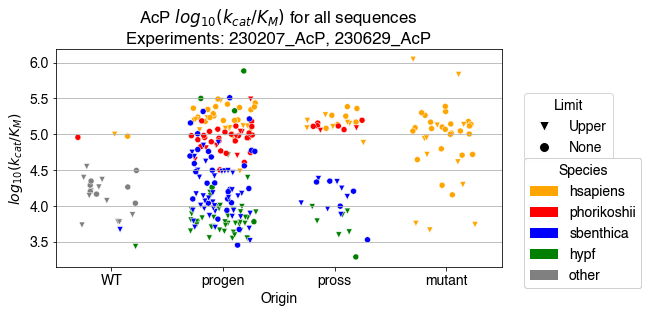

In [97]:
from matplotlib.patches import Patch

# plot boxplot of kcat/KM for each species
plt.figure(figsize=(8, 4))

dat = all_turnover_dfs_concat.copy()

# add limit column to dataframe
dat['limit'] = dat['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")

# filter for local bg ratio > 2, enzyme conc > 5 nM
# dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 10]

# filter to for experiments of interest
experiments_to_plot = [
                        '230207_AcP',
                        # '230410_AcP',
                        '230629_AcP',
                        ]
dat = dat[dat['experiment'].isin(experiments_to_plot)]

# drop experiment Indices duplicates
dat = dat.drop_duplicates(subset=['Indices', 'experiment'])

# get median df for each MutantID
dat = dat.groupby(['MutantID', 'species', 'origin', 'limit']).agg({'kcat_over_KM_fit': 'median'}).reset_index()

# set marker dictionary for style
marker_dict = {
    'None': 'o',
    'Upper': 'v'
}

# change species to 'other' if not hsapiens, phorikoshii, sbenthica, or hypf
dat.loc[~dat['species'].isin(['hsapiens', 'phorikoshii', 'sbenthica', 'hypf']), 'species'] = 'other'

# set species color dictionary
species_color_dict = {
    'hsapiens': 'orange',
    'phorikoshii': 'red',
    'sbenthica': 'blue',
    'hypf': 'green',
    'other': 'grey'
}

# plot stripplot in light gray, with median overlaid in red
ax = sns.scatterplot(data=dat, x='origin', y='kcat_over_KM_fit', 
                     hue='species', palette=species_color_dict, 
                     alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False)
for points in ax.collections:
    vertices = points.get_offsets().data
    if len(vertices) > 0:
        vertices[:, 0] += np.random.uniform(-0.3, 0.3, vertices.shape[0])
        points.set_offsets(vertices)
xticks = ax.get_xticks()
ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5) # the limits need to be moved to show all the jittered dots
# sns.despine()

# change facecolor to white
plt.gcf().set_facecolor('white')

# set axis labels
plt.xlabel('Origin')
plt.ylabel('$log_{10}(k_{cat}/K_M)$')

# legend
legend_elements = [
                    Line2D([0], [0], marker='v', color='w', label='Upper', markerfacecolor='black', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='None', markerfacecolor='black', markersize=10),
                    ]
legend1 = plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0., title='Limit')
plt.gca().add_artist(legend1)

# add horizontal gridlines
plt.grid(axis='y')

# set spine color to black
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')

# add second legend with colors for species
legend_elements = [Patch(facecolor=color, label=species) for species, color in species_color_dict.items()]
legend2 = plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0., title='Species')
plt.gca().add_artist(legend2)

# set title
plt.title('%s $log_{10}(k_{cat}/K_M)$ for all sequences' % substrate + '\nExperiments: %s' % ', '.join([x for x in experiments_to_plot if substrate in x]))

# save figure to file
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/origin_on_xaxis/' + substrate + '_full_library_boxplot.svg', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/origin_on_xaxis/' + substrate + '_full_library_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/origin_on_xaxis/' + substrate + '_full_library_boxplot.png', dpi=300, bbox_inches='tight')


plt.tight_layout()
plt.show()

Text(0, 0.5, 'AcP $log_{10}(k_{cat}/K_M)$')

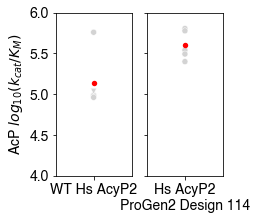

In [98]:
# plot hsapiens_lowlambda_lowid_4 against hsapiens2_wt
# ====================================================================================================

# plot boxplot of kcat/KM for each species
fig, axs = plt.subplots(1, 2, figsize=(3, 3), sharey=True)

dat = all_turnover_dfs_concat.copy()

# filter enzyme conc > 5 nM
dat = dat[dat['EnzymeConc'] > 5]

# add limit column to dataframe
dat['limit'] = dat['local_bg_ratio'].apply(lambda x: "Upper" if x < 2 else "None")

# filter to for experiments of interest
experiments_to_plot = [
                        '230207_AcP',
                        # '230410_AcP',
                        '230629_AcP',
                        ]
dat = dat[dat['experiment'].isin(experiments_to_plot)]

# drop experiment Indices duplicates
dat = dat.drop_duplicates(subset=['Indices', 'experiment'])

# remove BLANK MutantID
dat = dat[dat['MutantID'] != 'BLANK']

# set marker dictionary for style
marker_dict = {
    'None': 'o',
    'Upper': 'v'
}

# select desired MutantIDs
mutantIDs_to_plot = [
                        'hsapiens2_wt',
                        'hsapiens2_lowlambda_lowid_4',
                        ]
                        
dat = dat[dat['MutantID'].isin(mutantIDs_to_plot)]

# plot stripplot in light gray, with median overlaid in red
sns.scatterplot(data=dat[dat['MutantID'] == mutantIDs_to_plot[0]], y='kcat_over_KM_fit', x='MutantID',
                color='lightgrey', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False, ax=axs[0])
sns.pointplot(data=dat[dat['MutantID'] == mutantIDs_to_plot[0]], y='kcat_over_KM_fit', x='MutantID',
              color='red', join=False, ci=None, markers='.', 
              scale=1, zorder=10, ax=axs[0])

sns.scatterplot(data=dat[dat['MutantID'] == mutantIDs_to_plot[1]], y='kcat_over_KM_fit', x='MutantID',
                color='lightgrey', alpha=1, zorder=1, style='limit', markers=marker_dict, legend=False, ax=axs[1])
sns.pointplot(data=dat[dat['MutantID'] == mutantIDs_to_plot[1]], y='kcat_over_KM_fit', x='MutantID',
                color='red', join=False, ci=None, markers='.', 
                scale=1, zorder=10, ax=axs[1])

# create MutantID name dict and rename MutantIDs on x axis
mutantID_name_dict = {
                        'hsapiens2_wt': 'WT Hs AcyP2',
                        'hsapiens2_lowlambda_lowid_4': 'Hs AcyP2\nProGen2 Design 114',
                        }
axs[0].set_xticklabels([mutantID_name_dict[x.get_text()] for x in axs[0].get_xticklabels()])
axs[1].set_xticklabels([mutantID_name_dict[x.get_text()] for x in axs[1].get_xticklabels()])


# set axis limits
axs[0].set_ylim(4, 6)

# set axis labels
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[0].set_ylabel('AcP $log_{10}(k_{cat}/K_M)$')


All sequences, separated by sequence on x-axis

FileNotFoundError: [Errno 2] No such file or directory: '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/sequence_on_xaxis/AcP_full_library_boxplot.svg'

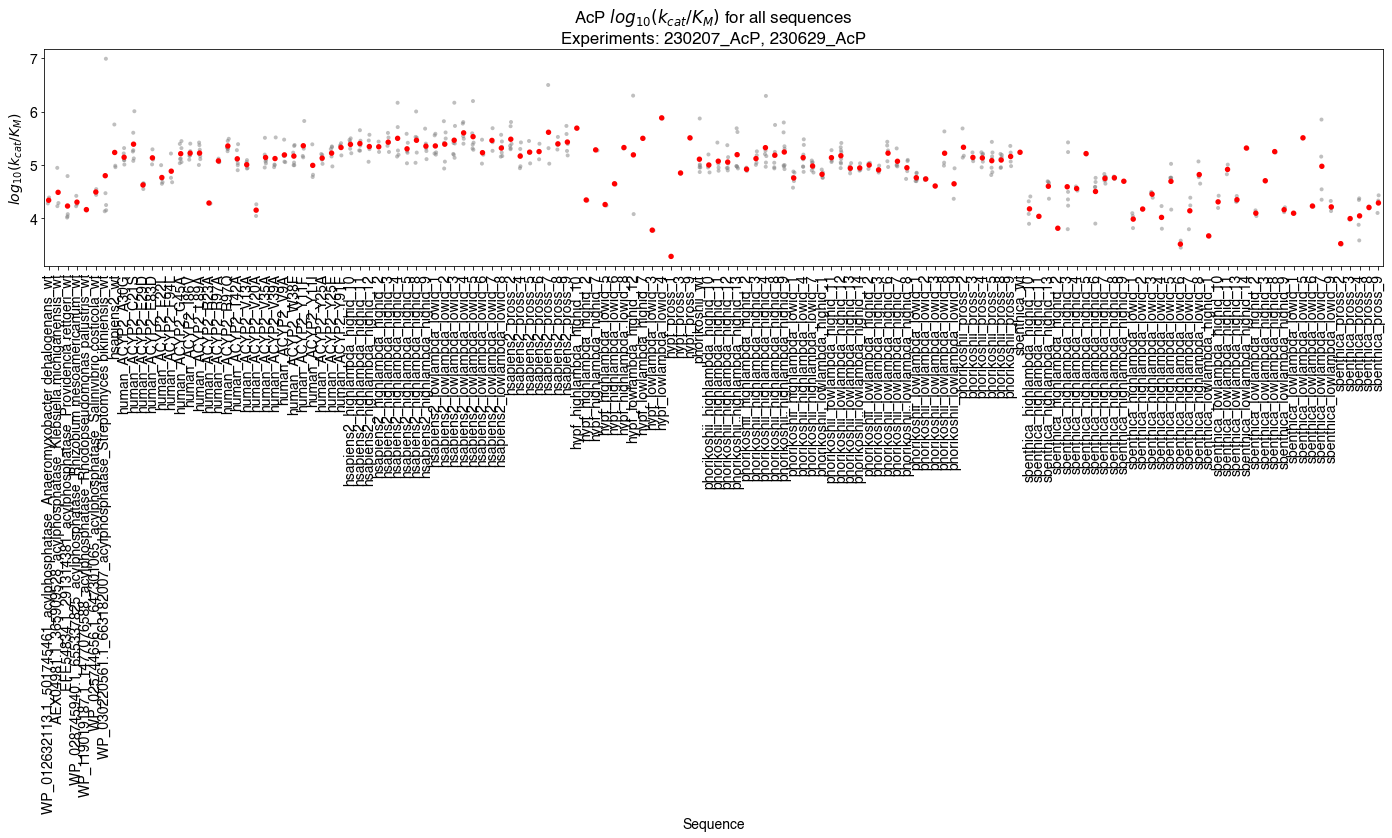

In [99]:
# plot boxplot of kcat/KM for each species
plt.figure(figsize=(24, 4))

dat = all_turnover_dfs_concat.copy()

# filter for local bg ratio > 2, enzyme conc > 5 nM
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 5]

# filter to for experiments of interest
experiments_to_plot = [
                        '230207_AcP',
                        # '230410_AcP',
                        '230629_AcP',
                        ]
dat = dat[dat['experiment'].isin(experiments_to_plot)]

# drop experiment Indices duplicates
dat = dat.drop_duplicates(subset=['Indices', 'experiment'])

# remove BLANK MutantID
dat = dat[dat['MutantID'] != 'BLANK']

# sort by MutantID, then origin
dat = dat.sort_values(by=['species', 'origin', 'MutantID'], ascending=True)

# plot stripplot in light gray, with median overlaid in red
sns.stripplot(data=dat, x='MutantID', y='kcat_over_KM_fit', color='grey', alpha=0.5, zorder=1, size=4, jitter=0.1)
sns.pointplot(data=dat, x='MutantID', y='kcat_over_KM_fit', color='red', join=False, ci=None, markers='.', scale=1, zorder=10)

# rotate xlabels 90 degrees
plt.xticks(rotation=90)

# change facecolor to white
plt.gcf().set_facecolor('white')

# set axis labels
plt.xlabel('Sequence')
plt.ylabel('$log_{10}(k_{cat}/K_M)$')

# make borders black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

# set title
plt.title('%s $log_{10}(k_{cat}/K_M)$ for all sequences' % substrate + '\nExperiments: %s' % ', '.join([x for x in experiments_to_plot if substrate in x]))

# save figure to file
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/sequence_on_xaxis/' + substrate + '_full_library_boxplot.svg', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/sequence_on_xaxis/' + substrate + '_full_library_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Presentations/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_full_library_boxplots/sequence_on_xaxis/' + substrate + '_full_library_boxplot.png', dpi=300, bbox_inches='tight')

plt.show()

Boxplot binned by sequence origin

In [ ]:
# plot boxplot of kcat/KM for each species
plt.figure(figsize=(12, 4))

dat = all_turnover_dfs_concat.copy()

# filter for local bg ratio > 2, enzyme conc > 5 nM
dat = dat[dat['local_bg_ratio'] > 2]
dat = dat[dat['EnzymeConc'] > 5]

# filter to for experiments of interest
experiments_to_plot = [
                        '230207_AcP',
                        # '230410_AcP',
                        '230629_AcP',
                        ]
dat = dat[dat['experiment'].isin(experiments_to_plot)]

# drop experiment Indices duplicates
dat = dat.drop_duplicates(subset=['Indices', 'experiment'])

# filter for Hsapiens
dat = dat[dat['species'] == 'hsapiens']

# sort by origin
origin_order = ['WT', 'progen', 'pross', 'mutant']
dat['origin'] = pd.Categorical(dat['origin'], origin_order)

# plot facetgrid of kcat/KM for each origin
g = sns.FacetGrid(data=dat, col='origin', col_wrap=4, sharey=True, sharex=False, height=2, aspect=1.5)

# set style to white with full borders
sns.set_style('whitegrid')

# plot stripplot in light gray, with median overlaid in red
g.map(sns.stripplot, 'MutantID', 'kcat_over_KM_fit', color='lightgray', alpha=0.7, zorder=1, size=4, jitter=0.3)
g.map(sns.pointplot, 'MutantID', 'kcat_over_KM_fit', color='red', join=False, ci=None, markers='.', scale=1, zorder=10)
plt.subplots_adjust(hspace=0.4, wspace=0.1)

# remove main title
g.fig.suptitle('')
for ax in g.axes.flat:
    ax.set_title('')

# set titles for each plot
titles = ['WT', 'ProGen2', 'PROSS', 'Design']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# set y axis label on first plot
g.axes[0].set_ylabel('$log_{10}(k_{cat}/K_M)$')

# remove all x axis labels
g.set_xlabels('')
g.set_xticklabels('')

# change facecolor to white
plt.gcf().set_facecolor('white')

# save figure to file
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_species_specific_boxplot/' + substrate + '_species_specific_boxplot.svg', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_species_specific_boxplot/' + substrate + '_species_specific_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/NeurIPS_2023/Plots/AcP_hydrolysis/AcP_species_specific_boxplot/' + substrate + '_species_specific_boxplot.png', dpi=300, bbox_inches='tight')


## Export kcat_over_KM data

In [ ]:
# export kcat over KM for selected experiments and substrate
selected_expts = [
                    '230207_AcP',
                    '230410_AcP',
                    '230419_AcP',
                    '230612_AcP',

                    '230419_ATP',
                    '230612_ATP',

                    '230419_PEP',
                    '230612_PEP'
                    ] 

# Select experiments
all_dat = all_turnover_dfs_concat.copy()
all_dat = all_dat[all_dat['experiment'].isin(selected_expts)]

# filter values
all_dat = all_dat[all_dat['experiment'].isin(selected_expts)]
all_dat = all_dat[all_dat['local_bg_ratio'] > 2]
all_dat = all_dat[all_dat['EnzymeConc'] > 1]
all_dat = all_dat[all_dat['kcat_over_KM_fit_R2'] > 0.95]

# Filter columns
selected_columns = ['MutantID', 'experiment', 'substrate', 'kcat_over_KM_fit', 'kcat_over_KM_fit_R2', 'exponential_kcat_over_km_list', 'exponential_R2_list', 'local_bg_ratio', 'EnzymeConc', 'protein_sequence', 'species', 'origin']
all_dat = all_dat[selected_columns].drop_duplicates()

all_dat

In [ ]:
import time

# Set version number
version_num = 'V2'

# Write out README file with information about culling criteria
export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Data/Aggregated_HTMEK'
with open(export_path + '/README_%s.txt' % version_num, 'w') as f:
    print('HT-MEK SF Library Aggregate Data %s' % version_num, file=f)
    print('Date: %s' % time.strftime('%m/%d/%Y'), file=f)
    print('%s total data points\n' % len(all_dat), file=f)
    print('Experiments included: %s' % ', '.join(selected_expts), file=f)
    print('Criteria for culling data:', file=f)
    print('1. Local background ratio > 2', file=f)
    print('2. Enzyme concentration > 1 nM', file=f)
    print('3. R2 of MM fit > 0.9', file=f)

# now export to filepath
all_dat.to_csv(export_path + '/Aggregated_data_%s.csv' % version_num, index=False)

# Plot boxplot of kcat/KM in each substrate

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
# filter for hypf, lbg > 2
dat = all_turnover_dfs['230207_AcP'][(all_turnover_dfs['230207_AcP']['local_bg_ratio'] > 2) & (all_turnover_dfs['230207_AcP']['species'] == 'hypf')]

# drop indices duplicates
dat = dat.drop_duplicates(subset=['Indices'])

In [ ]:
# filter for hypf and show kcat_over_KM_fit
all_turnover_dfs['230629_AcP'].species.unique()

In [ ]:
import matplotlib.pyplot as plt

species = 'hypf'
substrate = 'ATP'
origin = 'progen'
y_parameter = 'exponential_kcat_over_km_list_3'

# Get all data from selected_turnover_dfs
dat = pd.DataFrame()

## select only the turnover dfs that have the substrate in the key
# get list of keys to include
experiments_to_select = [
                        #  '221201_AcP',
                         '230207_AcP', 
                         '230410_AcP', 
                         '230419_AcP', 
                         '230612_AcP', 
                        #  '230622_AcP', 
                         '230629_AcP', 

                         '230419_ATP', 
                         '230612_ATP',
                        #  '230622_ATP', 

                         '230419_PEP', 
                         '230612_PEP'
                   ]

# select experiments
dat = all_turnover_dfs_concat.copy()
dat = dat[dat['origin'] == origin]
dat = dat[dat['experiment'].isin(experiments_to_select)]
dat['design_rep'] = dat['MutantID']

## filter dat
local_bg_ratio_cutoff = 2
kcat_over_KM_cutoff = 6
enzyme_conc_cutoff = 1
kcat_over_KM_fit_R2_cutoff = 0.9

# filter data
dat = dat[dat['local_bg_ratio'] > local_bg_ratio_cutoff]
dat = dat[dat['kcat_over_KM_fit'] < kcat_over_KM_cutoff]
# dat = dat[dat['EnzymeConc'] > enzyme_conc_cutoff]
# dat = dat[dat['kcat_over_KM_fit_R2'] > kcat_over_KM_fit_R2_cutoff]
dat = dat[dat['substrate'] == substrate]
dat = dat[dat['species'] == species]
# dat = dat.drop_duplicates(subset=['Indices'])


In [ ]:
fig, ax = plt.subplots(figsize=(4, 12))
sns.stripplot(data=dat, y='MutantID', x='exponential_kcat_over_km_list_2', hue='experiment', palette='Set2', ax=ax, jitter=0, size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='MutantID')

In [ ]:

# Create a figure with four subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [2, 11]}, sharey=True)

# sns set context
sns.set_context('talk')

# In the first subplot, plot a bar chart of the WT sequence kcat_over_KM_fit values for each experiment
if 'WT' in dat['origin'].unique():
    sns.boxplot(x='experiment', y=y_parameter, data=dat[dat['origin'] == 'WT'], ax=axs[0])

    # replace underscore in x axis tick labels
    xticklabels = [label.get_text().replace('_', '\n') for label in axs[0].get_xticklabels()]
    axs[0].set_xticklabels(xticklabels)

    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')
else:
    # annotate the plot to indicate that there is no WT data right above the x axis
    axs[0].annotate('n.d.', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center')
    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')

    # set single tick to indicate that there is no WT data
    axs[0].set_xticks([0.5])
    axs[0].set_xticklabels(['WT'])

# Get the sorted order of the mutants
if origin == 'mutant':
    mutants = dat[dat['origin'] == 'mutant']['mutation'].unique()
    sorted_order = sorted(mutants, key=lambda x: int(x[1:-1]))

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['mutation'] = pd.Categorical(dat_sorted['mutation'], categories=sorted_order, ordered=True)
else:
    mutants = dat[dat['origin'] == origin]['design_rep'].unique()

    # instead, sort by n_mutations
    n_mut_dict = {}
    for mutant in mutants:
        n_mut = dat[dat['design_rep'] == mutant]['n_mutations'].unique()[0]
        n_mut_dict[mutant] = n_mut
    sorted_order = sorted(n_mut_dict, key=n_mut_dict.get)

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['design_rep'] = pd.Categorical(dat_sorted['design_rep'], categories=sorted_order, ordered=True)

# In the second subplot, plot a bar chart of the progen sequence kcat_over_KM_fit values, and dodge by experiment, sorting the mutants by the sorted_order
dat_p = dat_sorted[dat_sorted['origin'] == origin]
if 'limit' in dat_p.columns:
    dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')
    sns.boxplot(x='design_rep', y=y_parameter, data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True)
    sns.stripplot(x='design_rep', y=y_parameter, data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True, size=4, linewidth=1, color='black', edgecolor='white')
else:
    sns.boxplot(x='design_rep', y=y_parameter, data=dat_p, ax=axs[1], order=sorted_order, dodge=True, color='skyblue')
    sns.stripplot(x='design_rep', y=y_parameter, data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True, size=5, linewidth=1, color='black', edgecolor='white')
axs[1].set_title(origin.capitalize())
axs[1].set_ylabel('')
axs[1].set_xlabel('')

# # add barplot of num_mutations to second subplot
# axs[1].twinx().bar(x=dat_p['design_rep'].unique(), height=dat_p.groupby('design_rep')['n_mutations'].mean(), 
#                    color='gray', width=0.5, alpha=0.5,
#                    label='n_mutations', edgecolor='black', linewidth=1, align='center')

# add super title to the figure
experiments_in_figure = dat['experiment'].unique().tolist()
fig.suptitle(' '.join([species, substrate, '$k_{cat}/K_M$'])+'\n'+'local bg cutoff:'+str(local_bg_ratio_cutoff)+'; log10 kcat/KM cutoff:'+str(kcat_over_KM_cutoff)+'; enzyme conc cutoff:'+str(enzyme_conc_cutoff)+'; kcat/KM R2 cutoff:'+str(kcat_over_KM_fit_R2_cutoff)+'\n'+'experiments:'+','.join(experiments_in_figure), fontsize=14)

# tight layout
plt.tight_layout()

# # set ylim
# axs[0].set_ylim([1.5, 6.5])

# remove legend
axs[1].get_legend().remove()

# make export path
plot_export_path = figure_export_path + '/Catalysis/aggregated_expts/per_sequence_comparison/' + species + '/' + substrate + '/'

# add white face color
fig.patch.set_facecolor('white')

# make export path if it doesn't exist
if not os.path.exists(os.path.dirname(plot_export_path)):
    os.makedirs(os.path.dirname(plot_export_path))

# save images
plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.png', dpi=300, bbox_inches='tight')
plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.svg', bbox_inches='tight')

# Show the plot
plt.show()

## Compare HypF Progen Designs to Human WT sequence Identity

In [ ]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

In [ ]:
# create list of experiments to select
selections = [
                #  '221201_AcP',
                 '230207_AcP', 
                 '230410_AcP', 
                 '230419_AcP', 
                #  '230612_AcP', 
                #  '230622_AcP', 
                 '230629_AcP', 

                 '230419_ATP', 
                 '230612_ATP',
                #  '230622_ATP', 

                 '230419_PEP', 
                 '230612_PEP'
]

# concat all experiments, lbg > 2
dat = pd.DataFrame()
dat = pd.concat(all_turnover_dfs.values(), ignore_index=True)
dat = dat[dat['local_bg_ratio'] > 1]
dat = dat[dat['experiment'].isin(selections)]

dat.head()  

In [ ]:
# subset for MutantID and any column containing 'sequence'
dat = dat.drop_duplicates(subset=['MutantID'])

# get the human and hypf WT protein sequences
hAcyP2_seq = dat[(dat['origin'] == 'WT') & (dat['species'] == 'hsapiens')]['protein_sequence'].unique()[0]
hypf_seq = dat[(dat['origin'] == 'WT') & (dat['species'] == 'hypf')]['protein_sequence'].unique()[0]

# calculate alignment
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

# Fetch the BLOSUM62 matrix
matrix = matlist.blosum62

# For all sequences in the dataframe, calculate the alignment score and store in a new column
dat['human_aln_score'] = dat['protein_sequence'].apply(lambda x: pairwise2.align.globalds(hAcyP2_seq, x, matrix, -10, -0.5)[0][2])
dat['hypf_aln_score'] = dat['protein_sequence'].apply(lambda x: pairwise2.align.globalds(hypf_seq, x, matrix, -10, -0.5)[0][2])

dat


In [ ]:
# filter for hypf
plot_dat = dat[dat['species'] == 'hypf']

# create grid with substrate as columns
g = sns.FacetGrid(plot_dat, col='substrate', col_wrap=3, height=4, sharey=False, hue='origin', palette='Set2')

# plot human_aln_score vs kcat_over_KM_fit
g.map(sns.scatterplot, 'human_aln_score', 'exponential_kcat_over_km_list_0', s=50)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Export data

In [ ]:
export_dict.keys()

In [ ]:
export_dict['230207_AcP'].columns

In [ ]:
# compile copy all turnover dfs to a new dict
export_dict = {}
for key in all_turnover_dfs.keys():
    export_dict[key] = all_turnover_dfs[key].copy()

# next, filter out low local bg mutants, low R2 mutants, and low expression
for key in export_dict.keys():
    # filter out low local bg mutants
    export_dict[key] = export_dict[key][export_dict[key]['local_bg_ratio'] > 2]

    # filter for high R2 mutants
    if 'kcat_over_KM_fit_R2' in export_dict[key].columns:
        export_dict[key] = export_dict[key][export_dict[key]['kcat_over_KM_fit_R2'] > 0.9]

    # filter low enzyme concentration mutants
    export_dict[key] = export_dict[key][export_dict[key]['EnzymeConc'] > 1]

    # drop duplicate chambers
    export_dict[key] = export_dict[key].drop_duplicates(subset=['Indices'])

# next, create a dictionary categorize experiments by best fit
measurement_dict = {
    'MM_fit':[
        '230207_AcP',
        '230410_AcP',
        '230419_AcP',
        '230612_AcP',
        # '230622_AcP' # this one is weird
        '230629_AcP',
    ],

    'kobs_fit':[
       '230419_ATP',
       '230612_ATP',
       '230622_ATP', 
       '230419_PEP', 
       '230612_PEP',
    ]
}

# remove experiments that are not in measurement_dict
export_dict = {key: export_dict[key] for key in export_dict.keys() if key in measurement_dict['MM_fit'] + measurement_dict['kobs_fit']}

# next, add a column to each df in export_dict that indicates the measurement type 
for key in export_dict.keys():
    for measurement_type in measurement_dict.keys():
        if key in measurement_dict[measurement_type]:
            export_dict[key]['kcat_over_KM_fit_type'] = measurement_type

# create a new df by adding a column called 'date' to each df in export_dict
# and adding the date from the key to each row in the df
for key in export_dict.keys():
    # get date from key
    date = key.split('_')[0]

    # add date column to df
    export_dict[key]['date'] = date

# create a new df by concatenating all dfs in export_dict
export_df = pd.concat(export_dict.values())

# for rows with a measurement type of kobs_fit, set kcat_over_KM_fit to exponential_kcat_over_km_list_1
export_df.loc[export_df['kcat_over_KM_fit_type'] == 'kobs_fit', 'kcat_over_KM_fit'] = export_df.loc[export_df['kcat_over_KM_fit_type'] == 'kobs_fit', 'exponential_kcat_over_km_list_3']


In [ ]:
# subset columns so that only the columns of interest are included: date, Indices, MutantID, substrate, EnzymeConc, local background ratio, kcat_over_KM_fit_type, kcat_over_KM_fit
export_df = export_df[['date', 'Indices', 'MutantID', 'substrate', 'EnzymeConc', 'local_bg_ratio', 'kcat_over_KM_fit_type', 'kcat_over_KM_fit']]

In [ ]:
# make export path
export_path = '/Users/micaholivas/Downloads/' + 'SFL_kinetics_export_v1.csv'

# export export_df to csv
export_df.to_csv(export_path, index=False)

### Barplot of kcat/KM in each substrate for each mutant

In [ ]:
import matplotlib.pyplot as plt

species = 'hsapiens'
substrates = [
              'AcP', 
              'ATP', 
            #   'PEP'
              ]
origin = 'mutant'

## select only the turnover dfs that have the substrate in the key
# get list of keys to include
experiments_to_select = [
                        #  '221201_AcP',
                         '230207_AcP', 
                        #  '230410_AcP', 
                         '230419_AcP', 
                        #  '230612_AcP', 
                        #  '230622_AcP', 
                         '230629_AcP', 

                         '230419_ATP', 
                         '230612_ATP',
                        #  '230622_ATP', 

                         '230419_PEP', 
                         '230612_PEP'
                   ]

# select experiments from list
selected_turnover_dfs = {key: all_turnover_dfs[key] for key in all_turnover_dfs.keys() if any(substrate in key for substrate in substrates) and key in experiments_to_select}

# Get all data from selected_turnover_dfs
dat = pd.DataFrame()


## remove other substrates from selected_turnover_dfs
# for each experiment df in selected_turnover_dfs
for key in selected_turnover_dfs.keys():
    # only add the df to dat if the substrate is in the key
    for substrate in substrates:
        if substrate in key:
            indices = selected_turnover_dfs[key]['Indices'].unique()
            unique_df = selected_turnover_dfs[key][selected_turnover_dfs[key]['Indices'].isin(indices)]
            unique_df['experiment'] = key
            dat = pd.concat([dat, unique_df])

## filter dat
# remove low local bg mutants from dat
dat = dat[dat['local_bg_ratio'] > 2]

# filter for high R2 mutants
if 'kcat_over_KM_fit_R2' in dat.columns:
    dat = dat[dat['kcat_over_KM_fit_R2'] > 0.95]

# filter low enzyme concentration mutants
dat = dat[dat['EnzymeConc'] > 2]


## add 220405 data to dat if species is human
if species == 'hsapiens':  
    dat = pd.concat([dat, df_processed_220405_AcP])


## add literature values to dat
lit_dat = lit_df[lit_df['Substrate_abbrev'] == substrate]
lit_dat = lit_dat[lit_dat['Isoform'] == 'ACYP2']
lit_dat = lit_dat[lit_dat['Species'] == 'H. sapiens']
lit_dat = lit_dat[lit_dat['Mutation'] == 'WT']
lit_dat = lit_dat[lit_dat['Activity Measurement Reference'] == '(Paoli et al., 1997)']
lit_dat = lit_dat.rename(columns={'log10 kcat/KM (s-1 M-1)': 'kcat_over_KM_fit'})
lit_dat['design_rep'] = 'lit.'
lit_dat['origin'] = 'WT'
lit_dat['species'] = 'hsapiens'
lit_dat['substrate'] = substrate
dat = pd.concat([dat, lit_dat])


# filter for desired species
dat = dat[dat['species'] == species]



# Create a figure with four subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [2, 11]}, sharey=True)

# In the first subplot, plot a bar chart of the WT sequence kcat_over_KM_fit values for each experiment
if 'WT' in dat['origin'].unique():
    sns.barplot(x='design_rep', y='kcat_over_KM_fit', data=dat[dat['origin'] == 'WT'], ax=axs[0], linewidth=0.6, dodge=True, hue='substrate', edgecolor='black')

    # replace underscore in x axis tick labels
    xticklabels = [label.get_text().replace('_', '\n') for label in axs[0].get_xticklabels()]
    axs[0].set_xticklabels(xticklabels)
    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')

    # remove legend from this subplot
    axs[0].legend().remove()
else:
    # annotate the plot to indicate that there is no WT data right above the x axis
    axs[0].annotate('n.d.', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center')
    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')

    # set single tick to indicate that there is no WT data
    axs[0].set_xticks([0.5])
    axs[0].set_xticklabels(['WT'])

    # remove legend from this subplot
    axs[0].legend().remove()

# Get the sorted order of the mutants
if origin == 'mutant':
    mutants = dat[dat['origin'] == 'mutant']['mutation'].unique()
    sorted_order = sorted(mutants, key=lambda x: int(x[1:-1]))
    print(sorted_order)

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['mutation'] = pd.Categorical(dat_sorted['mutation'], categories=sorted_order, ordered=True)
else:
    mutants = dat[dat['origin'] == origin]['design_rep'].unique()
    if '\n' in mutants[0]: # for progen names
        sorted_order = sorted(mutants, key=lambda x: x.split('\n')[0]+(x.split('\n')[1].zfill(2)))
    else: # for pross names
        sorted_order = sorted(mutants)

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['design_rep'] = pd.Categorical(dat_sorted['design_rep'], categories=sorted_order, ordered=True)

# In the second subplot, include a bar plot of variants
dat_p = dat_sorted[dat_sorted['origin'] == origin]
if 'limit' in dat_p.columns:
    dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')
    sns.barplot(x='design_rep', y='kcat_over_KM_fit', data=dat_p, ax=axs[1], order=sorted_order, hue='substrate', dodge=True, linewidth=1, edgecolor='black')
else:
    sns.barplot(x='design_rep', y='kcat_over_KM_fit', data=dat_p, ax=axs[1], order=sorted_order, hue='substrate', dodge=True, linewidth=1, edgecolor='black')
axs[1].set_title(origin.capitalize())
axs[1].set_ylabel('')
axs[1].set_xlabel('')

# plot barchart overlapping with boxplot
ax1_len = len(axs[1].get_xticklabels())
bar_data = np.random.normal(1, 0.2, ax1_len)
axs[1].bar(x=np.arange(ax1_len), height=bar_data, width=0.5, color='#CCCCCC', edgecolor='black', hatch='///', linewidth=0.5)

ax0_len = len(axs[0].get_xticklabels())
bar_data = np.random.normal(1, 0.2, ax0_len)
axs[0].bar(x=np.arange(ax0_len), height=bar_data, width=0.5, color='#CCCCCC', edgecolor='black', hatch='///', linewidth=0.5)

# legend for second subplot
patches = [
            mpatches.Patch(color='blue', label='AcP'),
            mpatches.Patch(color='orange', label='ATP'),
            # mpatches.Patch(color='green', label='PEP'),
            mpatches.Patch(color='#CCCCCC', label='Background')
            ]
axs[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), fancybox=True, shadow=True, ncol=1, handles=patches)

# add super title to the figure
fig.suptitle(' '.join([species, 'MM fit $k_{cat}/K_M$']))

# tight layout
plt.tight_layout()

# change face color to white
fig.patch.set_facecolor('white')

# make export path
plot_export_path = figure_export_path + '/Catalysis/aggregated_expts/all_substrate_barplots/' + species + '/'

# make export path if it doesn't exist
if not os.path.exists(os.path.dirname(plot_export_path)):
    os.makedirs(os.path.dirname(plot_export_path))

# save images
plt.savefig(plot_export_path + species + '_' + origin + 'MM_kcat_over_KM_aggregated_expts.png', dpi=300, bbox_inches='tight')
plt.savefig(plot_export_path + species + '_' + origin + 'MM_kcat_over_KM_aggregated_expts.svg', bbox_inches='tight')

# Show the plot
plt.show()

### Plot fold change from WT for each mutant

In [ ]:
substrates = [
              'AcP', 
              'ATP', 
            #   'PEP'
              ]

## select only the turnover dfs that have the substrate in the key
# get list of keys to include
experiments_to_select = [
                        #  '221201_AcP',
                         '230207_AcP', 
                        #  '230410_AcP', 
                         '230419_AcP', 
                        #  '230612_AcP', 
                        #  '230622_AcP', 
                         '230629_AcP', 

                         '230419_ATP', 
                         '230612_ATP',
                        #  '230622_ATP', 

                         '230419_PEP', 
                         '230612_PEP'
                   ]

# select experiments from list
selected_turnover_dfs = {key: all_turnover_dfs[key] for key in all_turnover_dfs.keys() if any(substrate in key for substrate in substrates) and key in experiments_to_select}


# Get all data from selected_turnover_dfs
dat = pd.DataFrame()

## remove other substrates from selected_turnover_dfs
# for each experiment df in selected_turnover_dfs
for key in selected_turnover_dfs.keys():
    # only add the df to dat if the substrate is in the key
    for substrate in substrates:
        if substrate in key:
            indices = selected_turnover_dfs[key]['Indices'].unique()
            unique_df = selected_turnover_dfs[key][selected_turnover_dfs[key]['Indices'].isin(indices)]
            unique_df['experiment'] = key
            dat = pd.concat([dat, unique_df])

## filtering
# filter for high R2 mutants
if 'kcat_over_KM_fit_R2' in dat.columns:
    dat = dat[dat['kcat_over_KM_fit_R2'] > 0.9]

# filter low enzyme concentration mutants
dat = dat[dat['EnzymeConc'] > 2]

# filter for local bg ratio
dat = dat[dat['local_bg_ratio'] > 3]


## remove unwanted columns
dat = dat[['MutantID', 'kcat_over_KM_fit', 'local_bg_ratio', 'kcat_over_KM_fit_R2', 'EnzymeConc', 'experiment', 'substrate', 'species', 'origin']]
dat


In [ ]:
# get median WT rate for each species
WT_rate_dict = {}
substrates_list = ['AcP', 'ATP', 'PEP']
species_list = dat['species'].unique()

for species in species_list:
    for substrate in substrates_list:
        # filter for species and substrate
        dat_filtered = dat[dat['substrate'] == substrate]
        dat_filtered = dat_filtered[dat_filtered['species'] == species]

        # get median WT rate
        WT_rate = dat_filtered[dat_filtered['origin'] == 'WT']['kcat_over_KM_fit'].median()

        # add to dictionary
        if species not in WT_rate_dict.keys():
            WT_rate_dict[species] = {}
        WT_rate_dict[species][substrate] = WT_rate


# create a new column for WT rate
dat['WT_rate'] = dat.apply(lambda x: WT_rate_dict[x['species']][x['substrate']], axis=1)

# create a new column for relative rate, then log transform
dat['relative_rate'] = dat['kcat_over_KM_fit'] / dat['WT_rate']
dat['relative_rate'] = np.log2(dat['relative_rate'])

In [ ]:
# plot scatterplot of relative rate in two substrates
species = ['phorikoshii', 'hsapiens']
substrate1 = 'AcP'
substrate2 = 'ATP'

# create color dictionary for origins
origin_list = dat_scatter['origin'].unique()
color_dict = {origin: color for origin, color in zip(origin_list, sns.color_palette('colorblind', len(origin_list)))}

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

for i in range(len(species)):
    # filter for species and substrates
    dat_filtered = dat[dat['species'] == species[i]]
    dat_filtered = dat_filtered[dat_filtered['substrate'].isin([substrate1, substrate2])]

    ## plot scatterplot of each mutantid in substrate1 vs substrate2
    # first calculate median and std of relative rate for each mutantid
    dat_scatter = dat_filtered[['MutantID', 'relative_rate', 'substrate', 'origin']].groupby(['MutantID', 'origin', 'substrate']).agg({'relative_rate': ['median', 'std']}).reset_index()
    dat_scatter.columns = ['MutantID', 'origin', 'substrate', 'relative_rate_median', 'relative_rate_std']

    # merge
    dat_scatter = pd.merge(dat_scatter[dat_scatter['substrate'] == substrate1], dat_scatter[dat_scatter['substrate'] == substrate2], on=['MutantID', 'origin'], suffixes=('_' + substrate1, '_' + substrate2))


    # now remove substrate columns
    for col in dat_scatter.columns:
        if 'substrate' in col:
            dat_scatter = dat_scatter.drop(col, axis=1)

    # add error bars
    axs[i].errorbar(zorder=0, x=dat_scatter['relative_rate_median_' + substrate1], y=dat_scatter['relative_rate_median_' + substrate2], xerr=dat_scatter['relative_rate_std_' + substrate1], yerr=dat_scatter['relative_rate_std_' + substrate2], fmt=' ', color='black', alpha=0.5)

    # plot scatterplot, color by origin
    for origin in origin_list:
        dat_scatter_origin = dat_scatter[dat_scatter['origin'] == origin]
        axs[i].scatter(dat_scatter_origin['relative_rate_median_' + substrate1], dat_scatter_origin['relative_rate_median_' + substrate2], 
                        color=color_dict[origin], label=origin, s=100, edgecolor='black', linewidth=0.5, zorder=1)

    # remove legend
    axs[i].legend().remove()

    # add lines at 0 y and x
    axs[i].axhline(0, ls='-', color='black', zorder=0)
    axs[i].axvline(0, ls='-', color='black', zorder=0)

    # make plot square and equal axis limits based on median values
    # get min and max median values from dat_scatter
    axs[i].set_aspect('equal', 'box')
    min_val = min(dat_scatter['relative_rate_median_' + substrate1].min(), dat_scatter['relative_rate_median_' + substrate2].min())
    max_val = max(dat_scatter['relative_rate_median_' + substrate1].max(), dat_scatter['relative_rate_median_' + substrate2].max())
    lim = 0.5
    axs[i].set_ylim(-lim, lim)
    axs[i].set_xlim(-lim, lim)


    # set title
    axs[i].set_title(species[i] + ' $log_2[(k_{cat}/K_M)_{mut}/(k_{cat}/K_M)_{WT}$]')

    # change x and y labels
    axs[i].set_xlabel(substrate1, fontsize=14)
    axs[i].set_ylabel(substrate2, fontsize=14)

# add legend
patches = [mpatches.Patch(color=color_dict[origin], label=origin, edgecolor='black', linewidth=0.5) for origin in origin_list]
axs[-1].legend(handles=patches, loc='upper left', fontsize=12, shadow=True, fancybox=True, title='Variant')

# tight layout
plt.tight_layout()

### Plot vertical stripplots of two species kobs side by side

In [ ]:
# combine all AcP data into one df
combined_acp_df = pd.DataFrame()
for key in all_turnover_dfs.keys():
    if 'AcP' in key:
        if combined_acp_df.empty:
            combined_acp_df = all_turnover_dfs[key]
            combined_acp_df['experiment'] = key
        else:
            # add experiment column to all_turnover_dfs[key]
            all_turnover_dfs[key]['experiment'] = key
            combined_acp_df = pd.concat([combined_acp_df, all_turnover_dfs[key]], ignore_index=True)


# normalize k_obs values by EnzymeConc
combined_acp_df['k_obs_norm'] = combined_acp_df['k_obs'] / combined_acp_df['EnzymeConc']

## filter data                                  
# drop nans from k_obs column
combined_acp_df = combined_acp_df.dropna(subset=['k_obs'])

# # remove poorly expressed variants
# combined_acp_df = combined_acp_df[combined_acp_df['EnzymeConc'] > 1]

# remove low k_obs R squared values
combined_acp_df = combined_acp_df[combined_acp_df['Rsq_kobs'] > 0.95]

# remove variants with low local bg ratio
combined_acp_df = combined_acp_df[combined_acp_df['local_bg_ratio'] > 2]

In [ ]:
# remove experiments 
combined_acp_df = combined_acp_df[combined_acp_df['experiment'] != '230419_AcP']
combined_acp_df = combined_acp_df[combined_acp_df['experiment'] != '230410_AcP']

In [ ]:
# two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 25), sharex=True)

# left plot hsapiens, right plot hypf
for i, species in enumerate(['hsapiens', 'sbenthica']):
    axs[i].set_title(species)
    axs[i].set_xlabel('$log_{10}(k_{obs}/[E])$')
    axs[i].set_ylabel('')
    axs[i].set_xscale('log')

    # get data for species
    dat = combined_acp_df[combined_acp_df['species'] == species]

    # calculate median k_obs for each mutantid and store in new column
    dat['median_k_obs'] = dat.groupby('MutantID')['kobs_over_enzyme_conc'].transform('median')

    # sort by median k_obs
    dat = dat.sort_values(by='median_k_obs', ascending=False)

    # plot stripplot of k_obs norm by each mutantid
    im = axs[i].scatter(dat['k_obs_norm'], dat['MutantID'], s=30, alpha=0.3, c=dat['local_bg_ratio'], cmap='viridis')

    # add colorbar below x axis
    fig.colorbar(im, ax=axs[i], orientation='horizontal', label='local background ratio', pad=0.05)

    # add text to show how many points are in each plot
    axs[i].text(0.05, 0.99, 'n = ' + str(len(dat)), transform=axs[i].transAxes, verticalalignment='top')

# move hypf labels to the right
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

### Generate median dfs

In [ ]:
# create list of experiments to keep in dat
keep_expts = [
            '230207_AcP', 
            '230410_AcP', 
            '230419_AcP', 
            # '230612_AcP', 
            # '230622_AcP', 
            '230629_AcP',

            '230419_ATP', 
            '230612_ATP', 
            # '230622_ATP', 
            
            '230419_PEP', 
            '230612_PEP'
]

In [ ]:
dat['230629_AcP'].columns

In [ ]:
# get list of substrates
substrates = []
for key, value in all_turnover_dfs.items():
    substrates.append(all_turnover_dfs[key]['substrate'].unique()[0])
substrates = np.unique(substrates)

# remove experiments if desired
dat = all_turnover_dfs.copy()

# remove expts that are not in the keep list
if keep_expts is not None:
    items = list(dat.items())
    for key, value in items:
        if key not in keep_expts:
            dat.pop(key)

# for each substrate, get median kcat/KM values
turnover_median_dfs = {}
for substrate in substrates:
    for key, value in dat.items():

        # append kcat/KM values to list if substrate is in key
        if substrate in key:
            dat[key]['experiment'] = key
            if turnover_median_dfs.get(substrate) is None:
                turnover_median_dfs[substrate] = dat[key]
            else:
                turnover_median_dfs[substrate] = pd.concat([turnover_median_dfs[substrate], all_turnover_dfs[key]])
            
    # get median and std
    if substrate == 'AcP':
        turnover_median_dfs[substrate] = turnover_median_dfs[substrate][['name', 'species', 'origin', 'kcat_over_KM_fit']].groupby(['name', 'species', 'origin']).agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()
        turnover_median_dfs[substrate].columns = ['name', 'species', 'origin', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_std']
    else:
        turnover_median_dfs[substrate] = turnover_median_dfs[substrate][['name', 'species', 'origin', 'kcat_over_KM_fit']].groupby(['name', 'species', 'origin']).agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()
        turnover_median_dfs[substrate].columns = ['name', 'species', 'origin', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_std']
        ## use kobs_kcat_over_KM
        # turnover_median_dfs[substrate] = turnover_median_dfs[substrate][['name', 'species', 'origin', 'kobs_kcat_over_KM']].groupby(['name', 'species', 'origin']).agg({'kobs_kcat_over_KM': ['median', 'std']}).reset_index()
        # turnover_median_dfs[substrate].columns = ['name', 'species', 'origin', 'kobs_kcat_over_KM_median', 'kobs_kcat_over_KM_std']


k_obs boxplot

In [ ]:
import matplotlib.pyplot as plt

species = 'hsapiens'
substrate = 'AcP'
origin = 'progen'

# Get all data from selected_turnover_dfs
dat = pd.DataFrame()

# select only the turnover dfs that have the substrate in the key
experiments_to_select = [
                        '221022_AcP',
                        '221201_AcP',
                        '230207_AcP', 
                        '230410_AcP', 
                        '230419_AcP', 
                        '230612_AcP', 
                    #  '230622_AcP', 
                        '230629_AcP', 
                        
                        '230419_ATP', 
                        '230612_ATP',
                        '230622_ATP', 
                        '230629_ATP',
                        
                        '230419_PEP', 
                        '230612_PEP'
                   ]
selected_turnover_dfs = {key: all_turnover_dfs[key] for key in all_turnover_dfs.keys() if substrate in key and key in experiments_to_select}

# for each experiment df in selected_turnover_dfs
for key in selected_turnover_dfs.keys():
    # only add the df to dat if the substrate is in the key
    if substrate in key:
        indices = selected_turnover_dfs[key]['Indices'].unique()
        unique_df = selected_turnover_dfs[key][selected_turnover_dfs[key]['Indices'].isin(indices)]
        unique_df['experiment'] = key
        dat = pd.concat([dat, unique_df])

# add 220405 data to dat
if species == 'hsapiens':  
    dat = pd.concat([dat, df_processed_220405_AcP])

    # replace underscores with \n in the design_rep column
    dat['experiment'] = dat['experiment'].apply(lambda x: x.replace('_', '\n'))

# add literature values to dat
lit_dat = lit_df[lit_df['Substrate_abbrev'] == substrate]
lit_dat = lit_dat[lit_dat['Isoform'] == 'ACYP2']
lit_dat = lit_dat[lit_dat['Species'] == 'H. sapiens']
lit_dat = lit_dat[lit_dat['Mutation'] == 'WT']
lit_dat = lit_dat[lit_dat['Activity Measurement Reference'] == '(Paoli et al., 1997)']
lit_dat = lit_dat.rename(columns={'log10 kcat/KM (s-1 M-1)': 'kcat_over_KM_fit'})
lit_dat['experiment'] = 'lit.'
lit_dat['origin'] = 'WT'
lit_dat['species'] = 'hsapiens'
lit_dat['substrate'] = 'AcP'
dat = pd.concat([dat, lit_dat])

# filter for desired substrate and species
dat = dat[dat['substrate'] == substrate]
dat = dat[dat['species'] == species]

# remove local bg ratio below 2
dat = dat[dat['local_bg_ratio'] >= 2]

# # remove low R2 kobs fits
# dat = dat[dat['Rsq_kobs'] >= 0.96]

# Create a figure with four subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [2, 11]}, sharey=True)

# In the first subplot, plot a bar chart of the WT sequence kcat_over_KM_fit values for each experiment
if 'WT' in dat['origin'].unique():
    sns.boxplot(x='experiment', y='kcat_over_KM_fit', data=dat[dat['origin'] == 'WT'], ax=axs[0])
    axs[0].set_title('WT')
    axs[0].set_ylabel('$k_obs$ (s^-1)')
else:
    # annotate the plot to indicate that there is no WT data right above the x axis
    axs[0].annotate('n.d.', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center')
    axs[0].set_title('WT')
    axs[0].set_ylabel('$k_obs$ (s^-1)')

    # set single tick to indicate that there is no WT data
    axs[0].set_xticks([0.5])
    axs[0].set_xticklabels(['WT'])

# Get the sorted order of the mutants
if origin == 'mutant':
    mutants = dat[dat['origin'] == 'mutant']['mutation'].unique()
    sorted_order = sorted(mutants, key=lambda x: x[1:-1])
else:
    mutants = dat[dat['origin'] == origin]['design_rep'].unique()
    sorted_order = sorted(mutants)

# sort the data by the 'kcat_over_KM_fit' column
dat_sorted = dat.sort_values('kcat_over_KM_fit')

# In the second subplot, plot a bar chart of the progen sequence kcat_over_KM_fit values, and dodge by experiment, sorting the mutants by the sorted_order
dat_p = dat_sorted[dat_sorted['origin'] == origin]
if 'limit' in dat_p.columns:
    dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')
    sns.boxplot(x='design_rep', y='kcat_over_KM_fit', data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True)
axs[1].set_title(origin.capitalize())
axs[1].set_ylabel('')
axs[1].set_xlabel('')

# # set y scale as log
# axs[1].set_yscale('log')

# legend for second subplot
axs[-1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), fancybox=True, shadow=True, ncol=1, title='Experiment')

# add super title to the figure
fig.suptitle(' '.join([species, substrate, '$k_{obs}$']), fontsize=16)

# tight layout
plt.tight_layout()

# make export path
plot_export_path = figure_export_path + '/Catalysis/aggregated_expts/per_sequence_comparison/' + species + '/' + substrate + '/'

# # make export path if it doesn't exist
# if not os.path.exists(os.path.dirname(plot_export_path)):
#     os.makedirs(os.path.dirname(plot_export_path))

# # save images
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.png', dpi=300, bbox_inches='tight')
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.svg', bbox_inches='tight')

# Show the plot
plt.show()

Plot facetgrid to compare sequence ID and lambda

In [ ]:
def plot_box_whisker_kcatKM_by_ID_lambda(all_turnover_dfs, substrate, species):
    dat = pd.DataFrame()
    for key in all_turnover_dfs.keys():
        if substrate in key:
            # unique indices in current df
            indices = all_turnover_dfs[key]['Indices'].unique()
            unique_df = all_turnover_dfs[key][all_turnover_dfs[key]['Indices'].isin(indices)]
            unique_df['experiment'] = key
            dat = pd.concat([dat, unique_df])

    # create column for design replicate where name ends in integer
    dat['design_rep'] = dat['name'].apply(lambda x: x.split('_')[-1])

    # remove non-progen sequences
    dat = dat[dat['origin'] == 'progen']

    # remove all but human
    dat = dat[dat['species'] == species]

    # set axes style to white
    sns.set_theme(style="ticks")

    # define color palette
    if species == 'phorikoshii':
        color_palette = 'Reds'
    elif species == 'sbenthica':
        color_palette = 'Blues'
    elif species == 'hsapiens':
        color_palette = 'Greens'
    else:
        color_palette = 'colorblind'

    # make separate columns for each origin value and sort columns and rows
    g = sns.FacetGrid(dat, col='lambda', row='seq_id', sharey=True, sharex=False, height=3.5, aspect=1, col_order=['high', 'low'], row_order=['high', 'low'])
    g.map_dataframe(sns.boxplot, x='design_rep', y='EnzymeConc', palette=color_palette, showfliers=False)

    # add labels
    g.set_axis_labels('Design Replicate', 'k_{cat}/K_M (uM^-1 s^-1)')
    g.set_xticklabels(rotation=45)

    # add title
    plt.suptitle(substrate + ' $k_{cat}/K_M$' + '\n' + 'Aggregated Expts: ' + str(set(dat['experiment'])), y=1.05)

    # set facecolor to white
    g.fig.set_facecolor('white')

    plt.tight_layout()
    
    # save as svg
    plot_export_path = figure_export_path + '/catalysis/aggregated_expts/'

    if not os.path.exists(os.path.dirname(plot_export_path)):
        os.makedirs(os.path.dirname(plot_export_path))

    plt.savefig(plot_export_path + substrate + f'_lambda_seqid_aggregated_expts_{substrate}_{species}.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

    return dat

# plot each
plotted_df = plot_box_whisker_kcatKM_by_ID_lambda(all_turnover_dfs, 'ATP', 'phorikoshii')

## Plot kcat/KM for ATP

Compare AcP and ATP hydrolysis

In [ ]:
def get_foldchange_df(sub1_medians, sub2_medians, ordered_substrates, manual_WT_rates=None):

    # merge ATP and AcP medians
    kcatKM_two_substrate_medians = pd.merge(sub1_medians, sub2_medians, on=['name', 'species', 'origin', 'ensemble_ll', 'predicted_tm'], suffixes=(f'_{ordered_substrates[0]}', f'_{ordered_substrates[1]}'))

    # get WT rates for each species
    species = list(set(kcatKM_two_substrate_medians['species']))
    WT_rates = dict(zip(ordered_substrates, [{} for i in ordered_substrates]))

    # get fold change in rate for each species
    combined_df = kcatKM_two_substrate_medians

    # get WT rates for each species
    for i in ordered_substrates:
        for j in species:
            species_rates = kcatKM_two_substrate_medians[kcatKM_two_substrate_medians['species'] == j]
            if len(species_rates[species_rates['name'].str.contains('wt', case=False)]) > 0:
                WT_rates[i][j] = species_rates[species_rates['name'].str.contains('wt', case=False)][f'kcat_over_KM_fit_median_{i}'].values[0]
    
    # create manual WT rates if necessary
    if manual_WT_rates != None:
        for key, value in manual_WT_rates.items():
            WT_rates[key] = value

    # calculate fold changes
    for i in ordered_substrates:
        for j in WT_rates[i].keys():
            for index, row in combined_df.iterrows():
                if row['species'] == j:
                    combined_df.loc[index, f'foldchange_{i}'] = np.log2(row[f'kcat_over_KM_fit_median_{i}'] / WT_rates[i][j])
                else:
                    pass

    print(WT_rates)

    return combined_df


In [ ]:
# All medians
AcP_medians = turnover_median_dfs['AcP']
ATP_medians = turnover_median_dfs['ATP']
PEP_medians = turnover_median_dfs['PEP']
ATP_medians[ATP_medians['origin'] == 'WT']

In [ ]:
# define manual WT rates
manual_WT_rates = {'AcP': {'hsapiens': 3, 'sbenthica': 1, 'phorikoshii':1},
                   'ATP': {'hsapiens': 1, 'sbenthica': 1, 'phorikoshii':1},
                   }

In [ ]:
df_foldchange_AcP_PEP = get_foldchange_df(AcP_medians, PEP_medians, ordered_substrates=['AcP', 'PEP'], manual_WT_rates=None)
df_foldchange_AcP_ATP = get_foldchange_df(AcP_medians, ATP_medians, ordered_substrates=['AcP', 'ATP'], manual_WT_rates=None)
df_foldchange_AcP_PEP

Plot fold change in kcat/KM for each substrate from WT

In [ ]:
import seaborn as sns

# initialize figure
num_subplots = 3
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*6, 6), sharex=True, sharey=True)

def plot_foldchange(df, species, substrates_xy, ax):
    # create color palette
    origin_list = ['pross', 'progen', 'WT', 'mutant']
    palette = sns.color_palette('colorblind', len(origin_list))
    palette_dict = dict(zip(origin_list, palette))

    # plot scatter of fold change in rate in seaborn
    sns.scatterplot(data=df, x='foldchange_%s' % substrates_xy[0], y='foldchange_%s' % substrates_xy[1], 
                    hue='origin', palette=palette_dict, ax=ax, s=150)
    
    # make x and y limits equal
    min_x, max_x = ax.get_xlim()
    min_y, max_y = ax.get_ylim()
    ax.set_xlim(min(min_x, min_y), max(max_x, max_y))

    # add lines at x and y = 0
    ax.axhline(0, color='black', linestyle='-')
    ax.axvline(0, color='black', linestyle='-')

    # add axis labels
    ax.set_xlabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[0])
    ax.set_ylabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[1])

    # sort legend alphabetically
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = {k: by_label[k] for k in sorted(by_label, reverse=True)}
    ax.legend(by_label.values(), by_label.keys(), fancybox=True, shadow=False, title='Origin', framealpha=0.8)

    # add title
    ax.set_title('%s \n $k_{cat}/K_M$ fold change from WT' % species)


## plot fold changes
species_list = ['phorikoshii', 'sbenthica', 'hsapiens']

for i, species in enumerate(species_list):
    # filter for only human variants
    dat = df_foldchange_AcP_ATP[df_foldchange_AcP_ATP['species'] == species]

    # make plots
    plot_foldchange(dat, species = species, substrates_xy=['AcP', 'ATP'],ax=axs[i])


# tight layout
plt.tight_layout()

Plot kcat/KM compared to WT with seaborn

In [ ]:
import seaborn as sns

# create a vertical histogram for kcat/KM, split by

## Plot Covariance Matrix

In [ ]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

In [ ]:
# get list of sequences from align object
seq_list = []
for record in align:
    seq_list.append(record.seq)

# convert each sequence to a list of characters
seq_list = [list(i) for i in seq_list]

# convert each character to a number
for i in seq_list:
    for j in range(len(i)):
        if i[j] == 'A':
            i[j] = 0
        elif i[j] == 'C':
            i[j] = 1
        elif i[j] == 'D':
            i[j] = 2
        elif i[j] == 'E':
            i[j] = 3
        elif i[j] == 'F':
            i[j] = 4
        elif i[j] == 'G':
            i[j] = 5
        elif i[j] == 'H':
            i[j] = 6
        elif i[j] == 'I':
            i[j] = 7
        elif i[j] == 'K':
            i[j] = 8
        elif i[j] == 'L':
            i[j] = 9
        elif i[j] == 'M':
            i[j] = 10
        elif i[j] == 'N':
            i[j] = 11
        elif i[j] == 'P':
            i[j] = 12
        elif i[j] == 'Q':
            i[j] = 13
        elif i[j] == 'R':
            i[j] = 14
        elif i[j] == 'S':
            i[j] = 15
        elif i[j] == 'T':
            i[j] = 16
        elif i[j] == 'V':
            i[j] = 17
        elif i[j] == 'W':
            i[j] = 18
        elif i[j] == 'Y':
            i[j] = 19
        else:
            i[j] = 20

De-gap the alignment

In [ ]:
# delete column if it contains more than 50% gaps
frames = np.asarray(seq_list)
frames = np.delete(frames, np.where((frames == 20).sum(axis=0) > 0.9*len(frames)), axis=1)

In [ ]:
covar = np.cov(frames, rowvar=False)

# increase figure size
plt.rcParams['figure.figsize'] = [7, 7]

# normalize covariance matrix
covar = covar / np.max(covar)

# shrink values below 0.6 to 0
covar[covar < 0.1] = 0

# plot covariance matrix as scatter plot
plt.imshow(covar, cmap='Reds', interpolation='nearest')

# # create colorbar and change normalization range
cbar = plt.colorbar()
# cbar.norm.vmax = 0.5

# add label to cbar
cbar.ax.set_ylabel('Normed Covariance', rotation=270, labelpad=15)

Format indices for data

In [ ]:
# define a regular expression to match numbers in the range 0-10
pattern = r"\{(0\d|\d),(0\d|\d)\}"

# The replacement string to use in the string replace operation
# It includes a leading zero for single-digit numbers and removes the curly brackets
replacement = r"0\1,0\2"

# Apply the string replace operation to each element in the column using the re.sub() function
for key in 

df_221201_SFL["Indices"] = df_221201_SFL["Indices"].apply(lambda x: re.sub(pattern, replacement, x))

In [ ]:

df_221022_SFL_merge['mutation'] = df_221022_SFL_merge.name.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)

# WT df
WT_df = df_221022_SFL_merge[df_221022_SFL_merge['origin'] == 'WT']

# add wt sequence to each row
df_221022_SFL_merge = pd.merge(df_221022_SFL_merge, WT_df[['species', 'protein_sequence']], on='species', suffixes=['', '_wt'])

For 230207, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_230207_SFL = df_230207_SFL[df_230207_SFL['egfp_manual_flag'] == False]

# merge the expression and full_sequence_library DataFrames
df_230207_SFL_merge = pd.merge(df_230207_SFL, full_protein_sequence_library, on=list(set(df_230207_SFL.columns).intersection(set(full_protein_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, full_DNA_sequence_library, on=list(set(df_230207_SFL_merge.columns).intersection(set(full_DNA_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, single_mutant_likelihoods, on=['mutation', 'protein_sequence'], how='outer')
df_230207_SFL_merge = df_230207_SFL_merge.fillna('')

# remove redundant rows for each chamber
df_230207_SFL_merge = df_230207_SFL_merge.drop_duplicates(subset='Indices')


In [ ]:
df_230207_SFL_merge

For 220608, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_220608_single_muts = df_220608_single_muts[df_220608_single_muts['ManualGFPFlag'] == 0]

# reduce to only a single row per chamber and add mutation column
df_220608_single_muts_merge = df_220608_single_muts[df_220608_single_muts['SubstrateConc'] == 10][['Indices', 'MutantID', 'fit_mm_kcatoverKM_MMfit', 'EnzymeConc', 'LocalBackgroundRatio']]

# add mutation column
df_220608_single_muts_merge['mutation'] = df_220608_single_muts_merge.MutantID.str.extract(r'([A-Z]\d{0,2}[A-Z])', expand=False).fillna('')

## Expression

### Experiment summaries

In [ ]:
def plot_pie_chart(series, title=None, ax=None):
    expression_outcomes = list(series.to_dict().keys())
    data = list(series.to_dict().values())

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-10, colors=['goldenrod', 'darkslateblue'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    ax.set_title(title)

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(expression_outcomes[i] + '\n' + str(data[i]) + ' chambers', xy=(x, y), xytext=(1.01*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
                

In [ ]:
all_blanks

In [ ]:
import matplotlib.patheffects as PathEffects

fig, axs = plt.subplots(2, 4, figsize=(17,7), facecolor='white')

### 102222
# remove blank chambers
all_blanks = df_221022_SFL[df_221022_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_221022_SFL[df_221022_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')

# plot histograms
axs[0, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[0, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[0, 0].set_xlabel('eGFP Concentration (uM)')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_title('10/22/22 \n Expression')
# axs[0, 0].ticklabel_format(style='plain')

counts = df_221022_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, title='PROSS', ax=axs[0, 1])
plot_pie_chart(s_progen, title='ProGen2', ax=axs[0, 2])
plot_pie_chart(s_WT, title='WT', ax=axs[0, 3])

### 230207
# remove blank chambers
all_blanks = df_230207_SFL[df_230207_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_230207_SFL[df_230207_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_blanks = all_blanks[all_blanks['x'] < 16]
all_library = all_library[all_library['x'] < 16]

# plot histograms
axs[1, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[1, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[1, 0].set_xlabel('eGFP Concentration (uM)')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_title('02/07/23 \n Right Side Expression')
# axs[1, 0].ticklabel_format(style='plain')

counts = df_230207_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, ax=axs[1, 1])
plot_pie_chart(s_progen, ax=axs[1, 2])
plot_pie_chart(s_WT, ax=axs[1, 3])

axs[1, 1].set_title('PROSS')
axs[1, 2].set_title('ProGen2')
axs[1, 3].set_title('WT')

plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
fig.savefig(current_export_directory + "summary_expression_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_expression_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

## Scatter of expression vs number of mutations

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True, facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

df_230207_SFL_merge.plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[0], alpha=0.4)
ax[0].set_xlabel('Number of Mutations \n Relative to WT')
ax[0].set_ylabel('Enzyme \n Concentration (nM)')
ax[0].set_title('230207 Expt')

df_221022_SFL_merge.drop_duplicates(subset='Indices').plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[1], alpha=0.4)
ax[1].set_xlabel('Number of Mutations \n Relative to WT')
ax[1].set_ylabel('')
ax[1].set_title('221022 Expt')


plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/expression/sequence_identity/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v1'
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 

### Device Heatmap

In [ ]:
### 221022
# df_221022_SFL = df_221022_SFL[(df_221022_SFL['local_bg_ratio'] < 70) & (df_221022_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_221022 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_221022['substrate_concs'] = squeeze_mm_221022['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_221022['lbg_ratio'] = squeeze_mm_221022['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

### 230207
# df_230207_SFL = df_230207_SFL[(df_230207_SFL['local_bg_ratio'] < 70) & (df_230207_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_230207 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_230207['substrate_concs'] = squeeze_mm_230207['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_230207['lbg_ratio'] = squeeze_mm_230207['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

# now, save substrate concs
all_substrate_concs = squeeze_mm_230207['substrate_concs'][0]

squeeze_mm_230207

In [ ]:
def heatmap(data, ax=None, fig=None, norm=None, cmap=None, vmin=None, vcenter=None, vmax=None,
            cbar_kw=None, cbarlabel="", display_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    # if ax is None:
    #     ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # create vcenter if None provided
    if vcenter == None:
        vcenter = (vmax - vmin)/2

    # PCM method
    divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    pcm = ax.pcolormesh(data, cmap=cmap, norm=divnorm)

    # Create colorbar
    if display_cbar == True:
        cbar = fig.colorbar(pcm, ax=ax, norm=mpl.colors.Normalize(vmin=0, vmax=20), **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.tick_params(which="minor", bottom=False, left=False)

    return pcm, cbar

In [ ]:
parameter = 'enzyme_conc'

fig, axs = plt.subplots(2,2, figsize=(10,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.5)


### 221022
grid = squeeze_mm_221022.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[0, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[0, 0].set_xlabel("Column")
axs[0, 0].set_ylabel("Row")
axs[0, 0].set_title("10/22/22 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[0, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig                    
                    )
axs[0, 1].set_xlabel("Column")
axs[0, 1].set_ylabel("Row")
axs[0, 1].set_title("10/22/22 Experiment")


### 230207
grid = squeeze_mm_230207.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[1, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[1, 0].set_xlabel("Column")
axs[1, 0].set_ylabel("Row")
axs[1, 0].set_title("02/07/23 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[1, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig
                    )
axs[1, 1].set_xlabel("Column")
axs[1, 1].set_ylabel("Row")
axs[1, 1].set_title("02/07/23 Experiment")

# define export directory
current_export_directory = figure_export_path + '/aggregated/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + '/heatmap_SFL_%s.png' % (version), bbox_inches = 'tight')
plt.savefig(current_export_directory + '/heatmap_SFL_%s.svg' % (version), bbox_inches = 'tight')

# Stability Data

First, process the data

In [15]:
# filter by expression
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP[df_230207_SFL_DiFMUP['EnzymeConc'] > 2]

# if already a local_bg_ratio column, rename it
lbg_cols = [col for col in df_230207_SFL_DiFMUP_filtered.columns if 'local_bg_ratio' in col]
if len(lbg_cols) > 1:
    # remove all but one
    df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered.drop(columns=lbg_cols[1:])
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered.rename(columns={lbg_cols[0]: 'local_bg_ratio'})
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['local_bg_ratio'] > 2]

# filter for single row per chamber
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['urea_conc_mM'] == 0]

# filter no egfp flag
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['egfp_manual_flag'] == False]

# subset columns
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[['Indices', 'MutantID', 'EnzymeConc', 'two_point_fit', 'rate_fit_regime',
       'egfp_manual_flag', 'urea_concs',
       'initial_rates', 'later_rates', 'popt_initial', 'popt_later',
       'local_bg_ratio']]

# add species labels
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("sbenthica"), 'species'] = 'sbenthica'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hsapiens2"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("human"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("phorikoshii"), 'species'] = 'phorikoshii'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hypf"), 'species'] = 'hypf'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("\w\d{5,10}\w", regex=True), 'species'] = 'uncharacterized' # matchs the naming convention that Clara used to describe the uncharacterized bacterial ACYPs
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("consensus"), 'species'] = 'consensus'

# add mutant column
df_230207_SFL_DiFMUP_filtered['mutation'] = df_230207_SFL_DiFMUP_filtered.MutantID.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'mutation'] = 'WT'

# add origin
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("[A-Z]\d{1,2}[A-Z]", regex=True), 'origin'] = 'mutant'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'origin'] = 'WT'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("pross"), 'origin'] = 'pross'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("lambda"), 'origin'] = 'progen'

# fill nan
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered.fillna(np.nan).reset_index()


Next, initialize sigmoid curve function

In [17]:
def sigmoid(x, m1, m2, m3):
    return m1/(1 + np.exp(-m2 * ((m3-x)/0.5921))) # 0.5921 is R*T
v_sigmoidal = np.vectorize(sigmoid)

Next, plot overlayed curves

WT 121.15073048552532
WT 113.22934438990292
WT 121.54268799610269
WT 115.47857260110035
R97A 104.68729712412694
V9A 81.77228656001948
R97A 102.28370585712244
V9A 106.12257541819568
V9A 83.01429199298903
R97A 118.0386344501104
V9A 98.72961709743866
R97A 107.88167140595296


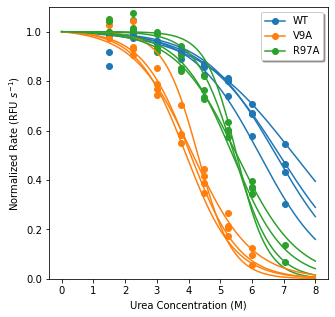

In [20]:
# init list
curr_list = [
             'WT', 
            'V9A',
            'R97A',
             ]

# create df
curr_df = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['mutation'].isin(curr_list)]
curr_df = curr_df[curr_df['EnzymeConc'] > 50]
curr_df = curr_df[curr_df['species'] == 'hsapiens']

# init fig
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='white')

# color dict
color_dict = dict(zip(curr_list, range(len(curr_list))))

# init legend elements
legend_elements = []

# plot kcat/KM from MM fit
for index, row in curr_df.iterrows():
    EnzConc = float(row.EnzymeConc)
    mutation = row.mutation
    print(mutation, EnzConc)

    # normalize by enzyme concentration
    initial_rates = [i/EnzConc for i in ast.literal_eval(row.initial_rates)][2:]
    later_rates = [i/EnzConc for i in ast.literal_eval(row.later_rates)][2:]
    urea_concs = [i/1000 for i in ast.literal_eval(row.urea_concs)][2:]

    # format parameters
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
        popt_later[0] = popt_later[0]
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ','))
        popt_later[0] = popt_later[0]

    # init linspace
    linx = np.linspace(0, 8, 300)

    # normalize 
    liny = v_sigmoidal(linx, *popt_later)
    later_rates = np.array(later_rates)/liny[0]
    liny = np.array(liny)/liny[0]

    # plot
    axs.scatter(x=urea_concs, y=later_rates, alpha=1, color='C'+str(color_dict[mutation]))
    axs.plot(linx, liny, color='C'+str(color_dict[mutation]))

for m in curr_list:
    # add handles
    legend_elements.append(Line2D([0], [0], marker='o', color='C'+str(color_dict[m]), label=m))

axs.legend(fancybox=True, shadow=True, handles=legend_elements)
axs.set_xlabel('Urea Concentration (M)')
axs.set_ylabel('Normalized Rate (RFU $s^{-1}$)')
axs.set_ylim(0, 1.1)

# define export directory
figure_export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Plots'
current_export_directory = figure_export_path + '/stability/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "sample_unfolding_curve3_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "sample_unfolding_curves_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

Get m1, m2, m3 from popt lists in dataframe

In [21]:
for index, row in df_230207_SFL_DiFMUP_filtered.iterrows():
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ',').replace(',,', ',').replace('[,', '['))

    if ',' in row.popt_initial:
        popt_initial = ast.literal_eval(row.popt_initial)
    else:
        popt_initial = ast.literal_eval(row.popt_initial.replace('  ', ',').replace(' ', ',').replace(',,', ',').replace('[,', '['))

    # add later rates
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm1_later'] = popt_later[0]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm2_later'] = popt_later[1]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm3_later'] = popt_later[2]

    # add initial rates
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm1_initial'] = popt_initial[0]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm2_initial'] = popt_initial[1]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm3_initial'] = popt_initial[2]


Filter data

In [22]:
# remove negative Cm values
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['m3_initial'] > 0]

 Import lit Cm values

In [23]:
Chiti_measurements = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Chiti_1999_hACYP2_stability_measurements.xlsx')

Chiti_measurements['Cm_mean'] = Chiti_measurements['Cm (M)'].str.split('±')
Chiti_measurements[['Cm_mean', 'Cm_error']] = pd.DataFrame(Chiti_measurements['Cm_mean'].tolist(), index=Chiti_measurements.index)

Chiti_measurements['Cm_mean'] = pd.to_numeric(Chiti_measurements['Cm_mean'], errors='coerce')
Chiti_measurements['Cm_error'] = pd.to_numeric(Chiti_measurements['Cm_error'], errors='coerce')
Chiti_measurements['mutation'] = Chiti_measurements['Mutant']
Chiti_measurements = Chiti_measurements.replace(to_replace=r'wild type', value='WT', regex=True)

# add additional columns
Chiti_measurements['comparison'] = 'literature'
Chiti_measurements['Cm (M)'] = Chiti_measurements['Cm_mean']
Chiti_measurements = Chiti_measurements[['mutation', 'Cm (M)', 'comparison', 'Cm_error', 'm value']]
Chiti_measurements

,mutation,Cm (M),comparison,Cm_error,m value
0,WT,4.02,literature,0.2,5.45
1,V9A,NaN,literature,NaN,NaN
2,Y11F,5.32,literature,0.2,4.4
3,Y11I,2.25,literature,0.2,5.6
4,V13A,1.95,literature,0.2,5.1
...,...,...,...,...,...
31,E83D,2.83,literature,0.2,5.35
32,I86V,2.95,literature,0.2,4.5
33,L89A,2.70,literature,0.2,5.2
34,Y91F,NaN,literature,NaN,NaN


Next, compare Cm from later rate fit and initial rate fit

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_77261/3375386034.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='orange', label='Chiti et al. 1999', edgecolor='black')]


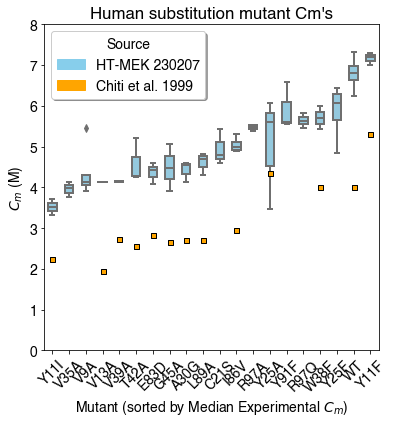

In [171]:
# filter for human WT and single substitution mutants
dat = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] == 'hsapiens']
dat = dat[(dat['origin'] == 'mutant') | (dat['origin'] == 'WT')]
dat['Cm (M)'] = dat['m3_later']
dat['comparison'] = 'experimental'

# Use the sorted groups to plot the boxplot
fig, axs = plt.subplots(1, 1, figsize=(6, 6), facecolor='white', sharey=True)

sorted_groups = dat.groupby('mutation')['Cm (M)'].median().sort_values().index

sns.boxplot(x='mutation', y='Cm (M)', data=dat, ax=axs, order=sorted_groups, width=0.5, linewidth=2, dodge=False, color='skyblue')
sns.stripplot(x='mutation', y='Cm (M)', data=Chiti_measurements, ax=axs, order=sorted_groups, color='orange', size=5, jitter=False, marker='s', linewidth=1, edgecolor='black')

axs.set_ylim(0, 8)
axs.set_ylabel('$C_m$ (M)')
axs.set_xlabel('Mutant (sorted by Median Experimental $C_m$)')
axs.set_title('Human substitution mutant Cm\'s')

handles = [plt.Rectangle((0, 0), 1, 1, color='skyblue', label='HT-MEK 230207'),
           plt.Rectangle((0, 0), 1, 1, color='orange', label='Chiti et al. 1999', edgecolor='black')]
axs.legend(title='Source', fancybox=True, shadow=True, handles=handles)

# rotate x labels
for item in axs.get_xticklabels():
    item.set_rotation(45)

# define export directory
current_export_directory = figure_export_path + '/stability/literature_mutants/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "hACYP2_single_mutant_stability_measurements_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "hACYP2_single_mutant_stability_measurements_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

In [25]:
lit_comparison = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] == 'hsapiens'][['mutation', 'm3_initial', 'm2_initial']], on='mutation', suffixes=['Chiti', '230207'])

lit_comparison.sort_values('Cm (M)')
lit_comparison.columns = ['mutation', 'lit. Cm (M)', 'lit. m value', 'Measured Cm (M)', 'Measured m value']
lit_comparison['Measured m value'] = lit_comparison['Measured m value'] * 4.184 # conversion from cal to J; Fanny's gas constant was in kcal mol-1 K-1
lit_comparison

,mutation,lit. Cm (M),lit. m value,Measured Cm (M),Measured m value
0,WT,4.02,5.45,6.347831,0.905998
1,WT,4.02,5.45,6.500775,1.118429
2,WT,4.02,5.45,6.771387,1.147050
3,WT,4.02,5.45,6.237506,1.562929
4,V9A,NaN,NaN,4.814031,5.419371
...,...,...,...,...,...
45,L89A,2.70,5.2,4.372723,1.726583
46,L89A,2.70,5.2,4.201342,2.518416
47,Y91F,NaN,NaN,6.923397,0.985279
48,Y91F,NaN,NaN,6.514430,1.288715


Plot lit vs expt medians

No handles with labels found to put in legend.


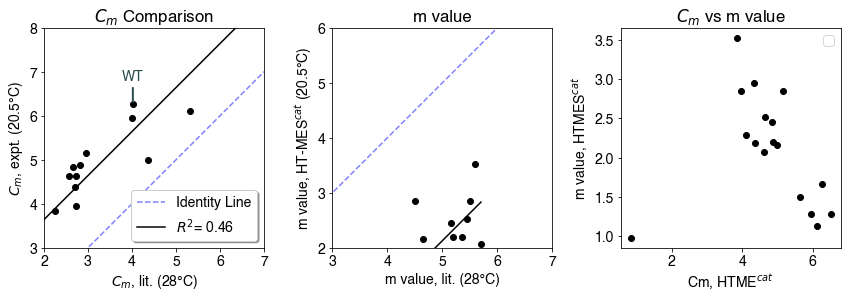

In [30]:
import scipy
from sklearn.metrics import r2_score

fig, axs = plt.subplots(1, 3, figsize=(12, 8), facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered.m3_initial.round(3) != 3.470] # remove bad fit Y25A
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[(df_230207_SFL_DiFMUP_filtered['m2_initial'] < 6) & df_230207_SFL_DiFMUP_filtered['m2_initial'] > 0] # remove bad fits
stability_meds = df_230207_SFL_DiFMUP_filtered.groupby('mutation', as_index=False).agg(Cm_230207_median=('m3_initial', 'median'), Cm_230207_std=('m3_initial', 'std'), m_value_230207_median=('m2_initial', 'median'))
stability_meds['m_value_230207_median'] = stability_meds['m_value_230207_median'] * 4.184
lit_comparison_meds = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], stability_meds[['mutation', 'Cm_230207_median', 'm_value_230207_median']], on='mutation', suffixes=['_Chiti', '230207_'])


# PLOT Cm's
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. Cm (M)'], ydata=lit_comparison.dropna()['Measured Cm (M)'])

# calculate R_sq
y_fit = lit_comparison.dropna()['lit. Cm (M)'] + popt
y_actual = lit_comparison.dropna()['Measured Cm (M)']
R_sq = r2_score(y_actual, y_fit)

linx = np.linspace(0, 7, 3)
axs[0].scatter(lit_comparison_meds['Cm (M)'], lit_comparison_meds['Cm_230207_median'], c='k')
axs[0].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[0].plot(linx, linx + popt[0], 'k-', label='$R^2$= %s' % round(R_sq, 2))
axs[0].set_xlabel('$C_m$, lit. (28°C)')
axs[0].set_ylabel('$C_m$, expt. (20.5°C)')
axs[0].set_xlim(2, 7)
axs[0].set_ylim(3, 8)
axs[0].legend(fancybox=True, shadow=True, loc='lower right')
axs[0].set_box_aspect(1)
axs[0].set_title('$C_m$ Comparison')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[0].annotate(text=row['mutation'], xy=(row['Cm (M)'], row['Cm_230207_median']),
                xytext=(0, 20), textcoords='offset points', fontsize=14, color='darkslategrey',
                arrowprops=dict(arrowstyle="-", color='darkslategrey', lw=2),
                ha='center', va='bottom')
    

# PLOT m-values
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. m value'], ydata=lit_comparison.dropna()['Measured m value'])

# calculate R_sq
y_fit = lit_comparison.dropna()['lit. m value'] + popt
y_actual = lit_comparison.dropna()['Measured m value']
R_sq = r2_score(y_actual, y_fit)

linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[1].scatter(lit_comparison_meds['m value'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[1].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[1].plot(linx, linx + popt[0], 'k-', label='$R^2$= %s' % round(R_sq, 2))
axs[1].set_xlabel('m value, lit. (28°C)')
axs[1].set_ylabel('m value, HT-MES$^{cat}$ (20.5°C)')
axs[1].set_xlim(3, 7)
axs[1].set_ylim(2, 6)
axs[1].set_box_aspect(1)
axs[1].set_title('m value')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[1].annotate(text=row['mutation'], xy=(row['m value'], row['m_value_230207_median']),
                xytext=(20, 0), textcoords='offset points', fontsize=14, color='k',
                arrowprops=dict(arrowstyle="-", color='darkslategrey', lw=2),
                ha='center', va='bottom')
    

# PLOT Cm vs m value
# linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[2].scatter(lit_comparison_meds['Cm_230207_median'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[2].set_xlabel('Cm, HTME$^{cat}$')
axs[2].set_ylabel('m value, HTMES$^{cat}$')
axs[2].set_box_aspect(1)
axs[2].set_title('$C_m$ vs m value')
axs[2].legend(fancybox=True)
plt.tight_layout()

    
# define export directory
current_export_directory = figure_export_path + '/Stability/iterature_comparison/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = ''
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

### Get highest Cm values for each species

In [35]:
dat = df_230207_SFL_DiFMUP_filtered[['MutantID', 'species', 'm3_initial', 'origin']]

# filter for hsapiens and progen
# dat = dat[dat['species'] == 'phorikoshii']
# dat = dat[dat['origin'] == 'progen']

dat.sort_values(by='m3_initial', inplace=True, ascending=False)

dat.head(10)

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_77261/4095826515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.sort_values(by='m3_initial', inplace=True, ascending=False)


,MutantID,species,m3_initial,origin
155,1A6_hsapiens2_pross_9,hsapiens,10.379207,pross
107,1A4_hsapiens2_pross_7,hsapiens,9.877089,pross
58,1A8_hsapiens2_pross_2,hsapiens,9.483023,pross
9,1A2_hsapiens2_pross_5,hsapiens,9.219347,pross
172,1A2_hsapiens2_pross_5,hsapiens,8.818318,pross
64,1A3_hsapiens2_pross_8,hsapiens,8.704496,pross
21,1A5_hsapiens2_pross_6,hsapiens,8.623838,pross
109,1A4_hsapiens2_pross_7,hsapiens,8.467114,pross
89,1A4_hsapiens2_pross_7,hsapiens,8.419958,pross
111,1A2_hsapiens2_pross_5,hsapiens,8.256513,pross


## Plot strip plot of Cm for each sequence

In [40]:
dat.sort_values(by='MutantID', inplace=True, ascending=True)
dat

,index,Indices,MutantID,EnzymeConc,two_point_fit,rate_fit_regime,egfp_manual_flag,urea_concs,initial_rates,later_rates,popt_initial,popt_later,local_bg_ratio,species,mutation,origin,m1_later,m2_later,m3_later,m1_initial,m2_initial,m3_initial
67,7680,"14,41",1A10_hsapiens2_highlambda_highid_2,108.538229,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[1.9350649350649334, 1.8741935483870982, 6.362...","[0.47277777777777796, 0.5692929292929289, 1.95...",[0.0636954 0.2928272 6.82266272],[0.02011432 0.51818567 7.61948055],2.548845,hsapiens,NaN,progen,0.020114,0.518186,7.619481,0.063695,0.292827,6.822663
11,1180,"03,07",1A10_hsapiens2_highlambda_highid_2,81.312247,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[3.4870129870129856, 3.422580645161292, 5.5032...","[0.7271212121212128, 0.8720707070707067, 1.728...",[0.06811164 0.30699063 7.645768 ],[0.0251416 0.75659307 7.67553804],7.604804,hsapiens,NaN,progen,0.025142,0.756593,7.675538,0.068112,0.306991,7.645768
173,17140,"31,35",1A10_hsapiens2_highlambda_highid_2,116.006492,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[1.0584415584415587, 0.8548387096774199, 6.800...","[0.32611111111111124, 0.3512626262626261, 1.90...",[0.07795527 0.1681841 5.09777048],[0.01796918 0.3812801 8.15172098],4.865820,hsapiens,NaN,progen,0.017969,0.381280,8.151721,0.077955,0.168184,5.097770
148,15300,"28,19",1A11_hsapiens2_highlambda_highid_3,100.898325,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[0.396103896103897, 0.11612903225806412, 7.254...","[0.18444444444444447, 0.17545454545454528, 2.2...",[0.11358342 0.1232536 3.38696171],[0.02099135 0.34165877 7.67559758],5.405610,hsapiens,NaN,progen,0.020991,0.341659,7.675598,0.113583,0.123254,3.386962
141,14660,"27,11",1A11_hsapiens2_highlambda_highid_3,84.375569,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[5.240259740259739, 5.535483870967743, 6.30065...","[1.2650505050505048, 1.6088888888888888, 1.974...",[0.0927115 0.1453935 6.31404956],[0.02274709 0.62135064 7.81179414],4.323489,hsapiens,NaN,progen,0.022747,0.621351,7.811794,0.092712,0.145394,6.314050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1980,"04,31",3E3_hsapiens2_L89A,108.840654,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[2.6233766233766205, 2.741935483870969, 4.1960...","[0.7534848484848491, 0.8080303030303029, 1.504...",[0.04060864 0.52429818 4.39836955],[0.01278312 0.84043234 4.69727496],3.178966,hsapiens,L89A,mutant,0.012783,0.840432,4.697275,0.040609,0.524298,4.398370
66,7600,"14,33",3E4_hsapiens2_Y91F,110.572029,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[3.6558441558441603, 3.9419354838709695, 5.343...","[0.9564646464646474, 1.1251515151515157, 1.741...",[0.05208189 0.3080102 6.51443007],[0.01726363 0.44337809 6.58990829],2.498074,hsapiens,Y91F,mutant,0.017264,0.443378,6.589908,0.052082,0.308010,6.514430
104,11040,"20,41",3E4_hsapiens2_Y91F,39.710438,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[0.3441558441558448, 0.4612903225806464, 2.839...","[0.18090909090909105, 0.207272727272727, 0.935...",[0.06913878 0.4042623 6.22380794],[0.0231388 0.66421861 5.54591914],3.790729,hsapiens,Y91F,mutant,0.023139,0.664219,5.545919,0.069139,0.404262,6.223808
32,2900,"06,11",3E4_hsapiens2_Y91F,63.891086,True,1,False,"[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6...","[4.448051948051945, 4.825806451612902, 5.99019...","[1.008131313131314, 1.3587878787878782, 1.6248...",[0.10230005 0.23548739 6.92339654],[0.02640835 2.60471894 5.61436203],4.498677,hsapiens,Y91F,mutant,0.026408,2.604719,5.614362,0.102300,0.235487,6.923397


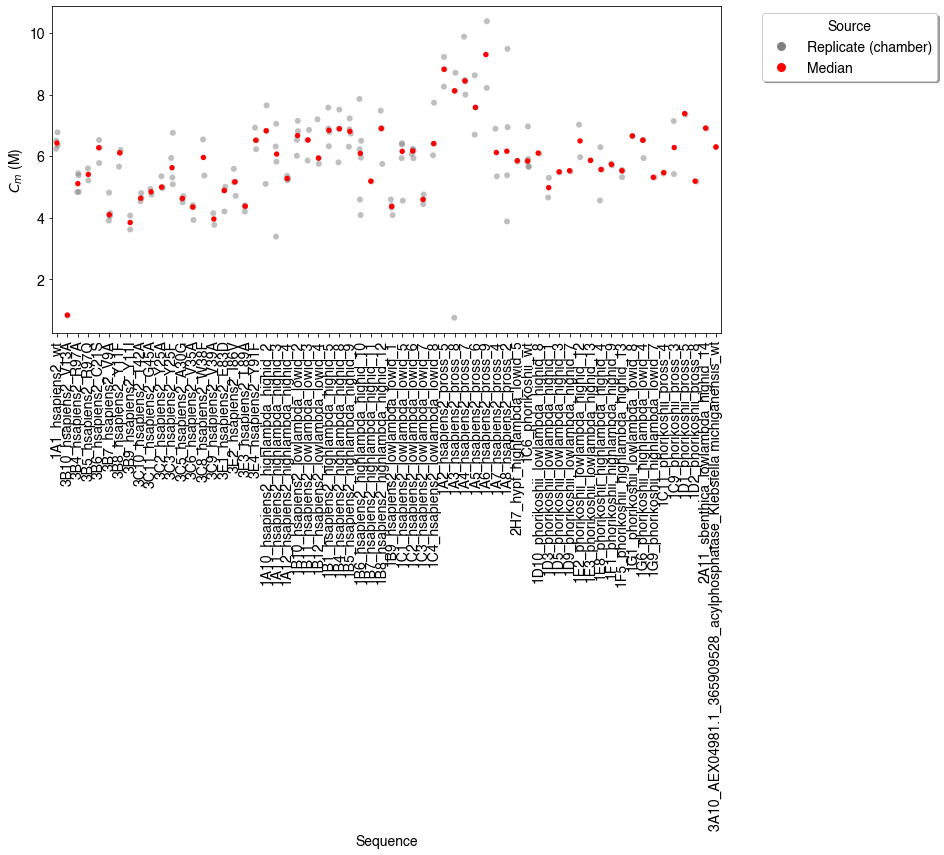

In [173]:
dat = df_230207_SFL_DiFMUP_filtered.copy()
# dat = dat[dat['species'] == 'hsapiens']

# filter to local_bg_ratio > 2
dat = dat[dat['local_bg_ratio'] > 2]

# plot stripplot of Cm's for each sequence
fig, axs = plt.subplots(1, 1, figsize=(12, 6), facecolor='white')
# sns.stripplot(x='origin', y='m3_initial', data=dat, ax=axs, hue='species', dodge=True, size=5, jitter=True, marker='s', linewidth=1, edgecolor='black')

# remove BLANK MutantID
dat = dat[dat['MutantID'] != 'BLANK']

# sort by MutantID, then origin
dat = dat.sort_values(by=['species', 'origin', 'MutantID'], ascending=True)

# plot stripplot in light gray, with median overlaid in red
sns.stripplot(data=dat, x='MutantID', y='m3_initial', color='grey', alpha=0.5, zorder=1, size=6, jitter=0.1)
sns.pointplot(data=dat, x='MutantID', y='m3_initial', color='red', zorder=2, join=False, estimator=np.median, ci=None, scale=1, markers='.', linestyles='--', dodge=0.5, errwidth=2, capsize=0.1, ax=axs)

# rotate xlabels 90 degrees
plt.xticks(rotation=90)

# change facecolor to white
plt.gcf().set_facecolor('white')

# set axis labels
plt.xlabel('Sequence')
plt.ylabel('$C_m$ (M)')

# create legend with circle markers
handles = [
            plt.Line2D([0], [0], marker='o', color='w', label='Replicate (chamber)', markerfacecolor='grey', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Median', markerfacecolor='red', markersize=10),
            ]
axs.legend(title='Source', fancybox=True, shadow=True, handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# make borders black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')


# Plot kcat/KM and Cm against ensemble log-likelihood

AcP kcat/KM vs ensemble log-likelihood

In [ ]:
# import patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# import scipy
import scipy

In [ ]:

# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(7, 7))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['species'] != 'uncharacterized']
dat = dat[dat['species'] != 'hypf']

# remove points if std deviation is too high
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]

# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.legend(fancybox=True, shadow=True)

# plot line of best fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=dat['ensemble_ll'], y=dat['kcat_over_KM_fit_median'])
linx = np.linspace(min(dat['ensemble_ll']), max(dat['ensemble_ll']), 3)
axs.plot(linx, intercept + slope*linx, 'k-', label='R_sq: %s' % round(r_value**2, 2))


# Manually add patches to legend, including markers
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   mpatches.Patch(facecolor=species_color_dict['sbenthica'], label='S. benthica'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                #    Line2D([0], [0], marker='*', markeredgecolor=species_color_dict['consensus'], label='Consensus', linestyle='None', markersize=10, markerfacecolor=species_color_dict['consensus']),
                   Line2D([0], [0], marker='', color='k', label='$R^2$: %s' % round(r_value**2, 3), linestyle='-', markersize=10, markerfacecolor='k'),
                   ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + "kcat_over_KM_ELL_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')

Do the above for human and phorikoshii alone

In [ ]:
selected_species = 'phorikoshii'
# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(4, 4))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]
dat = dat[dat['species'] == selected_species]
          
# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.set_title('P. horikoshii')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + f"kcat_over_KM_ELL_{selected_species}_{version}.png", dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
selected_species = 'hsapiens'
# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(4, 4))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]
dat = dat[dat['species'] == selected_species]
          
# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.set_title('H. sapiens')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + f"kcat_over_KM_ELL_{selected_species}_{version}.png", dpi=300, transparent=False, bbox_inches='tight')

Plot Cm's against ELL

In [ ]:
# plot Cm against predTm
library_Cm_median = df_230207_SFL_DiFMUP_filtered.groupby('MutantID', as_index=False).agg(Cm_median=('m3_later', 'median'), Cm_std=('m3_later', 'std'))
library_Cm_median['name'] = library_Cm_median.MutantID.str.split('_').str[1:].str.join('_')
library_Cm_median

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(5, 5))

# initialize dictionary of markers
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x'}

# add other information to library_Cm_median
Cm_vs_Tm = pd.merge(library_Cm_median, turnover_median_dfs['AcP'][['name', 'ensemble_ll', 'species', 'origin', 'predicted_tm', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_std']], on='name')


# plot Cm against predTm
for index, row in Cm_vs_Tm.iterrows():
    axs.scatter(x=row['predicted_tm'], y=row['Cm_median'], color=species_color_dict[row['species']], marker=markers[row['origin']], alpha=0.5)
    axs.errorbar(x=row['predicted_tm'], y=row['Cm_median'], yerr=row['Cm_std'], color=species_color_dict[row['species']], marker=markers[row['origin']], linestyle='', alpha=0.6)
axs.set_xlabel('Predicted $T_m$ (°C)')
axs.set_ylabel('\n $C_m$')

# add legend
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                   ]
axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + "Cm_vs_pred_Tm_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(facecolor='white', figsize=(5, 5))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}


# add legend
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                   ]
axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(8, 6))

# remove hypf from Cm_vs_Tm
Cm_vs_Tm = Cm_vs_Tm[Cm_vs_Tm['species'] != 'hypf']

# plot Cm against kcat/KM
for index, row in Cm_vs_Tm.iterrows():
    axs.errorbar(x=row['kcat_over_KM_fit_median'], y=row['Cm_median'], 
                 yerr=row['Cm_std'], xerr=row['kcat_over_KM_fit_std'],
                 color='grey', marker=markers[row['origin']], alpha=0.5, 
                 fmt='', zorder=0)
    axs.scatter(x=row['kcat_over_KM_fit_median'], y=row['Cm_median'], marker=markers[row['origin']], 
                color=species_color_dict[row['species']], alpha=0.5)
axs.set_xlabel('log($k_{cat}/K_M$) ($M^{-1} s^{-1}$))')
axs.set_ylabel('$C_m$')

# add legend
legend_elements = [
                     mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                        mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                        mpatches.Patch(facecolor=species_color_dict['sbenthica'], label='S. benthica'),
                        Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='o', markeredgecolor='k', label='ProGen2', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                        ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/Cm_and_kcat_KM/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + 'kcat_KM_Cm_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'kcat_KM_Cm_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

# add suptitle
fig.suptitle('Cm (from later rates) vs. $k_{cat}/K_M$', fontsize=16, y=1.02)

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(8, 6))

# remove hypf from Cm_vs_Tm
Cm_vs_Tm = Cm_vs_Tm[Cm_vs_Tm['species'] != 'hypf']

# plot Cm against kcat/KM
for index, row in Cm_vs_Tm.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['Cm_median'], 
                 yerr=row['Cm_std'],
                 color='grey', marker=markers[row['origin']], alpha=0.5, 
                 fmt='', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['Cm_median'], marker=markers[row['origin']], 
                color=species_color_dict[row['species']], alpha=0.5)
axs.set_xlabel('ensemble log-likelihood')
axs.set_ylabel('$C_m$')

# add legend
legend_elements = [
                     mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                        mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                        Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='o', markeredgecolor='k', label='ProGen2', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                        ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/Cm_and_ELL/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + 'Cm_ELL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'Cm_ELL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

## Plot kcat/KM vs Cm for designed sequences

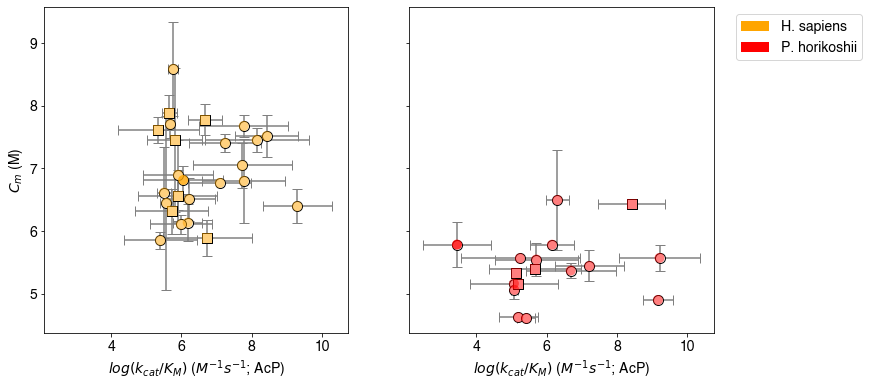

In [223]:
# get median and sem of Cm's, including origin and species information
Cm_dat = df_230207_SFL_DiFMUP_filtered.copy()
m3_selection = 'm3_later'
Cm_dat['MutantID'] = Cm_dat['MutantID'].str.split('_').str[1:].str.join('_') # rename MutantID to remove well position information
Cm_median_sem = Cm_dat.groupby('MutantID', as_index=False).agg(Cm_median=(m3_selection, 'median'), Cm_sem=(m3_selection, 'sem'), origin=('origin', 'first'), species=('species', 'first'))

# get median and sem of kcat/KM's
kcat_KM_dat = all_turnover_dfs_concat.copy()
substrate = 'AcP'
kcat_KM_dat = kcat_KM_dat[kcat_KM_dat['experiment'] == '230629_AcP']
kcat_KM_dat = kcat_KM_dat[kcat_KM_dat['substrate'] == substrate]
kcat_KM_median_sem = kcat_KM_dat.groupby('MutantID', as_index=False).agg(kcat_KM_median=('kcat_over_KM_fit', 'median'), kcat_KM_sem=('kcat_over_KM_fit', 'sem'))

# merge Cm and kcat/KM dataframes
Cm_kcat_KM = pd.merge(Cm_median_sem, kcat_KM_median_sem, on='MutantID')
species_to_keep = ['hsapiens', 'phorikoshii']
Cm_kcat_KM = Cm_kcat_KM[Cm_kcat_KM['species'].isin(species_to_keep)]

species_color_dict = {
    'hsapiens': 'orange',
    'phorikoshii': 'red',
    'sbenthica': 'blue',
    'hypf': 'green',
    'Salinivibrio_costicola': 'grey',
    'Rhodopseudomonas_palustris': 'grey',
    'Providencia_rettgeri': 'grey',
    'Azospirillum_oryzae': 'grey',
    'Klebsiella_michiganensis': 'grey',
    'Rhizobium_mesoamericanum': 'grey',
    'Anaeromyxobacter_dehalogenans': 'grey',
    'Lactobacillus_pobuzihii': 'grey',
    'Methylocystis_rosea': 'grey',
    'Streptomyces_bikiniensis': 'grey',
    'Nonomuraea_jiangxiensis': 'grey',
}

# plot scatter of Cm vs kcat/KM, color by species, add error bars
fig, axs = plt.subplots(1,2, figsize=(12, 6), facecolor='white', sharey=True, sharex=True)

for i in range(len(axs)):
    if i == 0:
        dat_overall = Cm_kcat_KM[Cm_kcat_KM['species'] == 'hsapiens']
    else:
        dat_overall = Cm_kcat_KM[Cm_kcat_KM['species'] == 'phorikoshii']
    dat = dat_overall[dat_overall['origin'] == 'WT']
    sns.scatterplot(x=dat['kcat_KM_median'], y=dat['Cm_median'], hue=dat['species'], ax=axs[i], palette=species_color_dict, s=100, alpha=0.8, zorder=2, edgecolor='none')
    axs[i].scatter(data=dat, x=f'kcat_KM_median', y=f'Cm_median', color='white', s=100, edgecolor='black', zorder=1)
    axs[i].errorbar(x=dat['kcat_KM_median'], y=dat['Cm_median'], xerr=dat['kcat_KM_sem'], yerr=dat['Cm_sem'], color='gray', ls='none', capsize=5, zorder=0)

    dat = dat_overall[dat_overall['origin'] == 'progen']
    sns.scatterplot(x=dat['kcat_KM_median'], y=dat['Cm_median'], hue=dat['species'], ax=axs[i], palette=species_color_dict, s=100, alpha=0.5, zorder=2, edgecolor='none')
    axs[i].scatter(data=dat, x=f'kcat_KM_median', y=f'Cm_median', color='white', s=100, edgecolor='black', zorder=1)
    axs[i].errorbar(x=dat['kcat_KM_median'], y=dat['Cm_median'], xerr=dat['kcat_KM_sem'], yerr=dat['Cm_sem'], color='gray', ls='none', capsize=5, zorder=0)

    dat = dat_overall[dat_overall['origin'] == 'pross']
    sns.scatterplot(x=dat['kcat_KM_median'], y=dat['Cm_median'], hue=dat['species'], ax=axs[i], palette=species_color_dict, s=100, alpha=0.5, zorder=2, marker='s', edgecolor='none')
    axs[i].scatter(data=dat, x=f'kcat_KM_median', y=f'Cm_median', color='white', s=100, edgecolor='black', zorder=1, marker='s')
    axs[i].errorbar(x=dat['kcat_KM_median'], y=dat['Cm_median'], xerr=dat['kcat_KM_sem'], yerr=dat['Cm_sem'], color='gray', ls='none', capsize=5, zorder=0, marker='s')
    
    dat = dat_overall[dat_overall['origin'] == 'mutant']
    sns.scatterplot(x=dat['kcat_KM_median'], y=dat['Cm_median'], hue=dat['species'], ax=axs[i], palette=species_color_dict, s=100, alpha=0.5, zorder=2, marker='^', edgecolor='none')
    axs[i].scatter(data=dat, x=f'kcat_KM_median', y=f'Cm_median', color='white', s=100, edgecolor='black', zorder=1, marker='^')
    axs[i].errorbar(x=dat['kcat_KM_median'], y=dat['Cm_median'], xerr=dat['kcat_KM_sem'], yerr=dat['Cm_sem'], color='gray', ls='none', capsize=5, zorder=0, marker='^')

    # add axis labels
    axs[i].set_xlabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$; %s)' % substrate)
    axs[i].set_ylabel('$C_m$ (M)')

    # drop legend
    axs[i].get_legend().remove()

# add master legend
handles = [
              mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
              mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
]
axs[i].legend(handles=handles, fancybox=True, bbox_to_anchor=(1.05, 1), loc='upper left')


## Plot kcat/KM against Cm for single mutants

In [ ]:
# first merge
Cm_and_activity_medians = pd.merge(library_Cm_median, turnover_median_dfs['AcP'], on='name', how='outer')

# filter out progen and pross origins
Cm_and_activity_medians = Cm_and_activity_medians[Cm_and_activity_medians['origin'] != 'progen']
Cm_and_activity_medians = Cm_and_activity_medians[Cm_and_activity_medians['origin'] != 'pross']

# remove species other than human
Cm_and_activity_medians = Cm_and_activity_medians[Cm_and_activity_medians['species'] == 'hsapiens']

# drop any rows with NaNs
Cm_and_activity_medians = Cm_and_activity_medians.dropna()

Cm_and_activity_medians

In [ ]:
# plot Cm vs kcat/KM with error bars and color by origin
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(x='kcat_over_KM_fit_median', y='Cm_median', xerr='kcat_over_KM_fit_std', yerr='Cm_std', data=Cm_and_activity_medians, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, zorder=1)
sns.scatterplot(x='kcat_over_KM_fit_median', y='Cm_median', hue='origin', data=Cm_and_activity_medians, ax=ax, s=100, zorder=2)
ax.get_legend().remove()
ax.set_xlabel('$log_{10}(k_{cat}/K_M)$')
ax.set_ylabel('Cm (M)')

# set legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:2], labels=labels[0:2], 
          loc='upper left', bbox_to_anchor=(1,1), frameon=False, 
          title='Sequence', title_fontsize=16, fontsize=14)

# set title
ax.set_title('$H. sapiens$ Single Mutant\n$C_m$ vs AcP $log_{10}(k_{cat}/K_M)$')



In [ ]:
all_turnover_dfs['230612_ATP'].columns

In [ ]:
# # filter for progen origin
# dat = turnover_median_dfs['AcP'][turnover_median_dfs['AcP']['origin'] == 'progen']

# # filter for hsapiens species
# dat = dat[dat['species'] == 'hsapiens']

# # sort and get top value
# dat = dat.sort_values(by='median', ascending=False)

Export muts

In [ ]:
single_mut_export = df_230207_SFL_merge[df_230207_SFL_merge['origin'] == 'mutant'][['mutation', 'protein_sequence']].drop_duplicates(subset='mutation').sort_values(by='mutation')
single_mut_export.to_csv('/Users/micaholivas/Downloads/single_mut_seqs.csv')
# set(df_230207_SFL_merge.origin)

In [ ]:
df_230207_SFL_merge.columns

# [['x', 'y', 'Indices', 'MutantID', 'substrate',
#        'EnzymeConc', 'egfp_manual_flag', 'substrate_concs', 'initial_rates',
#        'KM_fit', 'vmax_fit', 'kcat_fit', 'kcat_over_KM_fit', 'local_bg_ratio',
#        'substrate_conc_uM', 'summed_button_BGsub_Button_Quant', 'time_s',
#        'kinetic_median_intensities', 'standard_concentration_uM',
#        'standard_median_intensities', 'standard_popt',
#        'kinetic_product_concentration_uM', 'initial_rate',
#        'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
#        'local_bg_ratio_x']].to_csv('/Users/micaholivas/Downloads/230207_SFL_expression.csv')

In [ ]:
df_230207_SFL_merge['percent_ID'] = (df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)) - df_230207_SFL_merge['n_mutations'])/df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)).sort_values()
df_230207_SFL_merge[['name', 'percent_ID']]

# Calculate Shannon Entropy from alignment

Generate alignment and consensus

In [ ]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/acyps_aligned_high_iters.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
E_A = np.fromiter(ent_dict.values(), dtype=float).reshape(200,1).T

In [ ]:
def match_encoding(wt_seq, mut_seq):
    A = np.array([0 if wt_seq[i] == mut_seq[i] else 1 for i in range(min(len(wt_seq), len(mut_seq)))])
    return A.reshape(1, len(A))

match_encoding('stop', 'sows')

In [ ]:
df_230207_SFL_mean_kcatKM = df_230207_SFL_merge[['name', 'kcat_over_KM_fit', 'species', 'origin', 'protein_sequence', 'n_mutations', 'protein_sequence_wt']].groupby(["name", 'species', 'origin', 'protein_sequence', 'protein_sequence_wt', 'n_mutations']).agg([np.median, np.std]).droplevel(level=0, axis=1).reset_index()
WT_med = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM.species == 'hsapiens') & (df_230207_SFL_mean_kcatKM.origin == 'WT')]['median'].iloc[0]
df_230207_SFL_mean_kcatKM['percent_ID'] = (99 - df_230207_SFL_mean_kcatKM['n_mutations'])/99
df_230207_SFL_mean_kcatKM[((df_230207_SFL_mean_kcatKM['median'] - df_230207_SFL_mean_kcatKM['std']) > WT_med*0.5) & (df_230207_SFL_mean_kcatKM['origin'] == 'progen') & (df_230207_SFL_mean_kcatKM['species'] == 'hsapiens')].sort_values(by='median', ascending=False)



Plot sequence comparisons

In [ ]:
consensus = str(summary_align.dumb_consensus(threshold=0.9))

In [ ]:
consensus

In [ ]:
# initialize species
species = 'hsapiens'
expt_date = '230207'
parameter = 'kcat_over_KM_mm_fit'

# initialize df
df_ranking = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM['species'] == species)].sort_values(by='mean', ascending=False).reset_index().head(30)
df_ranking = df_ranking[(df_ranking['std']/df_ranking['mean']) < 1.5]
df_ranking.index += 1 # increase index by one so consensus can be displayed at position 0

# define height ratios
h_R = [3] + len(df_ranking)*[1]

# initialize figure
fig, axs = plt.subplots(nrows=len(df_ranking) + 1, sharex=True, figsize=(18,int(len(df_ranking)/2)), gridspec_kw={'height_ratios': h_R}, facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# sequences below
for index, row in df_ranking.iterrows():
    wt_sequence = row['protein_sequence_wt']

    design_1_bit = match_encoding(wt_sequence, row['protein_sequence'])
    axs[index].imshow(design_1_bit, cmap='Greys')
    axs[index].set_yticks([])
    axs[index].text(-0.02, 0, row['name'], size=12, ha="right", transform=axs[index].transAxes)
    axs[index].text(1.02, 0, row['mean'], size=12, ha="left", transform=axs[index].transAxes)

# find start of p-loop
pattern = "G.VQGV"
consensus = str(summary_align.dumb_consensus(threshold=0.9))
seq_p_loop_start = re.search(pattern=pattern, string=wt_sequence).span()[0]
cons_p_loop_start = re.search(pattern=pattern, string=consensus).span()[0]

# plot the consensus on top
cons_offset = abs(cons_p_loop_start - seq_p_loop_start) # first, calculate an "offset" between the consensus and the WT sequence
B = E_A[0, cons_offset:(len(wt_sequence) + cons_offset)]
im1 = axs[0].imshow(B.reshape(1, len(B)), cmap='Reds', aspect='auto')
axs[0].set_yticks([]) 
axs[0].set_title('ACYP Consensus', loc='left')
pos1 = axs[0].get_position() # get the original position 
pos2 = [(pos1.x0 + pos1.width) * 1.02, pos1.y0,  pos1.width / (len(wt_sequence) * 0.25), pos1.height] 
cb_ax = fig.add_axes(pos2)
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.ax.set_ylabel(ylabel='Entropy', loc='center', rotation="horizontal", labelpad=25) # align label text


for i, c in enumerate(consensus[cons_offset:(len(wt_sequence) + cons_offset)]):
    axs[0].text(x=i, y=0, s=c, va='center', ha='center')

fig.suptitle('Designed Variants of ' + species + ' ACYP2' + '\n' + expt_date)
# plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/consensus_alignment/' + expt_date + '/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.png' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.svg' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 

plt.show()

Export expression values

In [ ]:
# Export expression and sequences
SFL_221022_expression = df_221022_SFL_merge[df_221022_SFL_merge['egfp_manual_flag'] == False][['name', 'EnzymeConc', 'protein_sequence', 'dna_sequence']] # filter egfp manual flag and subset
SFL_221022_expression.columns = ['sequence_ID', 'enzyme_conc_nM', 'protein_sequence', 'insert_oligo_sequence']
SFL_221022_expression.to_csv('/Users/micaholivas/Downloads/SFL_221022_expression.csv')
SFL_221022_expression

In [ ]:
df_uncharacterized_bacteria = full_protein_sequence_library[full_protein_sequence_library['name'].str.contains('WP')].drop_duplicates(subset='MutantID')
export_AF = df_uncharacterized_bacteria[['name', 'sequence']]
export_AF.columns = ['ID', 'sequence']

In [ ]:
for index,row in export_AF.iterrows():
    f = open('/Users/micaholivas/Downloads/' + row['ID'] + '_bacterial_ACYPs_AF.fasta', 'w')
    f.write('>sp|' + row['ID'] + '\n' + row['sequence'])
    f.close()

# Sequence analysis

Filter fasta file for lengths

In [ ]:
import Bio

input_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop.fasta"
output_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop_size_filtered.fasta"
input_handle = open(input_file, "r")
output_handle = open(output_file, "w")

full_sequences = Bio.SeqIO.parse(input_handle, "fasta")

max_length = 100
min_length = 60
filtered_sequences = [ seq for seq in full_sequences if (len(seq) <= max_length) & (len(seq) >= min_length) ]
seq_lengths = [ len(seq) for seq in full_sequences ]
filtered_lengths = [ len(seq) for seq in filtered_sequences ]

plt.hist(seq_lengths, bins=60)
plt.hist(filtered_lengths, bins=60)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Distribution of sequence lengths")
plt.show()

# Write the filtered sequences to the output file
Bio.SeqIO.write(filtered_sequences, output_handle, "fasta")

# Close the input and output files
input_handle.close()
output_handle.close()

First, create the AA frequency array

In [ ]:
# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# create seq_list from alignment
seq_list = []

for i in range(len(align)):
    seq_list.append(list(align[i].seq))

# assign seq_list to array
arr = np.array(seq_list)

# def get_column_char_frequency(arr):
# Create an empty dictionary to store frequency count of each unique character in each column
freq_dict = {}
for col in range(arr.shape[1]):
    # Flatten the column and get unique characters and their frequency count
    unique, counts = np.unique(arr[:, col], return_counts=True)
    # Combine unique characters and their frequency count into a dictionary
    freq_dict[col] = dict(zip(unique, counts))


# Create a 2D numpy array to store the frequency count of each unique character in each column
char_ord = sorted(np.unique(arr))
result = np.zeros((arr.shape[1], len(char_ord)), dtype=float).T
for col, char_freq in freq_dict.items():
    for char, freq in char_freq.items():
        result[char_ord.index(char)][col] = freq/arr.shape[0]

consensus = str(summary_align.dumb_consensus(threshold=0.1))

def plot_array(result, char_ord, consensus=None):
    fig, ax1 = plt.subplots(1,1,figsize=(40,8))
    ax2 = ax1.twiny()

    im1 = ax1.imshow(result, aspect='auto')
    ax1.set_yticks(range(len(char_ord)))
    ax1.set_yticklabels(char_ord)
    fig.colorbar(im1, ax=ax1)

    ax1.xaxis.set_ticks(np.arange(0, len(result[0]), 5))
    
    if consensus != None:
        ax2.set_xticks(np.array(range(len(result[0]))))
        ax2.set_xticklabels(consensus)

    plt.show()

plot_array(result=result, consensus=consensus, char_ord=char_ord)

Create an entropy array from the alignment

In [ ]:
# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
entropy_array = np.fromiter(ent_dict.values(), dtype=float).reshape(len(align[0]),1).T[0]

Next, generate a frequency vector for each sequence

In [ ]:
def plot_freq_ent(wt_seq, mut_seq, aa_freq_array, entropy_array, ax):

    # create a "mask" of the mutated residues
    mask = match_encoding(wt_seq=wt_seq, mut_seq=mut_seq)

    # create mutant vector
    mut_vec = list(mut_seq)

    for i, n in enumerate(mask[0]):
        if n == 0:
            mut_vec[i] = 0


    # slice residue frequency array based on position of p-loop
    def get_p_loop_start(seq):
        pattern = "G.VQGV"
        return re.search(pattern=pattern, string=seq).span()[0]


    wt_p_loop_start = get_p_loop_start(wt_seq)
    consensus_p_loop_start = get_p_loop_start(consensus)

    p_loop_offset = (consensus_p_loop_start - wt_p_loop_start)


    # iterate through mut_vec and fill each position with frequency in array
    mut_freq_vec = []
    mut_pos_vec = []

    new_result = result[:, p_loop_offset:]

    for seq_pos, mut_res in enumerate(mut_vec):
        # get row position of mutation
        if mut_res != 0:
            result_row = char_ord.index(mut_res)

            # get residue frequency from result array
            freq = new_result[result_row, seq_pos]

            # store frequency in mut_freq_vec
            mut_freq_vec.append(freq)

            mut_ID = list(wt_seq)[seq_pos] + str(seq_pos) + mut_res 
            mut_pos_vec.append(mut_ID)

    aa_freq_dict = dict(zip(mut_pos_vec, mut_freq_vec))


    # store entropy values in dictionary
    ent_list = []

    all_ent = entropy_array[p_loop_offset:(len(wt_seq) + p_loop_offset)]

    for i, n in enumerate(mut_pos_vec):
        ent_list.append(all_ent[int(n[1:-1])])

    ent_dict = dict(zip(mut_pos_vec, ent_list))

    # finally, plot the values
    ax.scatter(x=list(ent_dict.values()), y=list(aa_freq_dict.values()), alpha=0.5)
    ax.set_xlabel('Site entropy')
    ax.set_ylabel('Mut AA frequency')

    # for i, txt in enumerate(ent_dict.keys()):
    #     ax.annotate(txt, (list(ent_dict.values())[i], list(aa_freq_dict.values())[i]))

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='col', sharey='row')

curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

for i, n in enumerate(['progen', 'pross']):
    for j, s in enumerate(['hsapiens', 'phorikoshii', 'sbenthica']):
        ax = axs[i, j]

        def df_plot_freq_ent(row, ax=ax):
            global result
            global entropy_array

            plot_freq_ent(wt_seq=row['protein_sequence_wt'], mut_seq=row['protein_sequence'], aa_freq_array=result, entropy_array=entropy_array, ax=ax)
            
            # t = ax.text(ax.get_xlim()[1]*0.8, ax.get_ylim()[1]*0.8, s,
            # ha="center", va="center", rotation=0, size=15,
            # bbox=dict(
            #           fc="white", ec="steelblue", lw=2))
            
            ax.set_title(n + ': ' + s)
            plt.tight_layout()


        curr_df[(curr_df['origin'] == n) & (curr_df['species'] == s)].apply(df_plot_freq_ent, axis=1)
        

# Nearest sequence neighbor analysis

In [ ]:
# import package to BLAST search sequences
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

# get PROSS and PROGEN sequences from full_protein_sequence df
full_protein_sequence_library[(full_protein_sequence_library['origin'] == 'progen')][['name', 'protein_sequence']]

# PyMOL: Structural comparison

Generate counts of mutations by position

In [ ]:
# init df
curr_df = all_turnover_dfs['230207_AcP'].drop_duplicates(subset='MutantID')

# get all unique pairs of protein_sequence_wt and species
unique_pairs = curr_df[['protein_sequence_wt', 'species']].drop_duplicates()
wt_length_dict = dict(zip(unique_pairs['species'], unique_pairs['protein_sequence_wt'].apply(lambda x: len(x))))

# count unique values of species, origin, and protein_sequence_wt
counts = curr_df.groupby(['species', 'origin']).count()
seq_counts_dict = {}
for species in counts.index.levels[0]:
    seq_counts_dict[species] = {}
    for origin in counts.index.levels[1]:
        if origin in counts.loc[species].index:
            seq_counts_dict[species][origin] = counts.loc[species, origin]['protein_sequence_wt']

# initialize lists for counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii', 'hypf']:
    for model in ['progen', 'pross']:
        # initialize list
        globals()[species + '_' + model + '_counts'] = 0 * len(curr_df[curr_df['species'] == species]['protein_sequence_wt'].iloc[0])

        # iterate through rows and add to list
        for index, row in curr_df[(curr_df['species'] == species) & (curr_df['origin'] == model)].iterrows():
            globals()[species + '_' + model + '_counts'] = globals()[species + '_' + model + '_counts'] + match_encoding(wt_seq=row.protein_sequence_wt, mut_seq=row.protein_sequence)[0]
    
        globals()[species + '_' + model + '_counts_dict'] = dict(zip(range(len(globals()[species + '_' + model + '_counts'])), globals()[species + '_' + model + '_counts']))

# now iterate through each to convert counts to percentages based on sequence counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii', 'hypf']:
    for model in ['progen', 'pross']:
        for i, n in enumerate(globals()[species + '_' + model + '_counts_dict'].keys()):
            globals()[species + '_' + model + '_counts_dict'][n] = globals()[species + '_' + model + '_counts_dict'][n]/seq_counts_dict[species][model]

print(hsapiens_progen_counts_dict)
print(hsapiens_pross_counts_dict)

Import PyMOL and initialize

In [ ]:
import pymol
import os

In [ ]:
from experiment_aggregation import pymol_commands

In [ ]:
# get pdb's from parent directory
import glob

parent_dir = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Plots/pymol_images/design_mutation_density/'

file_list = glob.glob(parent_dir + '*/*.pdb')
file_list = [i for i in file_list if 'aligned' not in i]
species_list = [i.split('/')[-2] for i in file_list]

pdb_dict = dict(zip(species_list, file_list))

In [ ]:
# align all files to human structure
for k,v in pdb_dict.items():
    if k != 'hsapiens':
        pymol.cmd.load(v, k) # load pdb
        pymol.cmd.load(pdb_dict['hsapiens'], 'hsapiens') # load hsapiens
        pymol.cmd.align(k, 'hsapiens') # align to hsapiens
        pymol.cmd.delete('hsapiens') # delete hsapiens
        # save aligned file
        pymol.cmd.save(v.split('.pdb')[0] + '_aligned.pdb', k)
    else:
        pymol.cmd.load(v, k)
        pymol.cmd.save(v.split('.pdb')[0] + '_aligned.pdb', k)

# now, load all aligned files
aligned_files = glob.glob(parent_dir + '*/*_aligned.pdb')
aligned_species_list = [i.split('/')[-2] for i in aligned_files]
aligned_pdb_dict = dict(zip(aligned_species_list, aligned_files))    

In [ ]:
figure_export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Plots'

# create active site dict
active_site_dict = {
    'hsapiens': [24, 42],
    'sbenthica': [18, 36],
    'phorikoshii': [20, 38],
    'hypf': [26, 44]
}

# plot mutational density
for species in ['sbenthica', 'phorikoshii', 'hypf', 'hsapiens']:
    for design in ['progen', 'pross']:
        print("Plotting: %s %s" % (species, design))
        pymol_commands.plot_mutational_density(species, design, aligned_pdb_dict, figure_export_path, counts_dict=globals()[species + '_' + design + '_counts_dict'], active_site_dict=active_site_dict)